In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# activate R magic
%load_ext rpy2.ipython

# python libs
from google.colab import drive
#drive.mount('/content/drive')
from drive.MyDrive.SSA.utils import *


import os
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from easydict import EasyDict as edict
from tqdm import tqdm
from pylab import rcParams
from matplotlib import rc
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri
from rpy2.robjects.packages import importr

import torch
from torch import nn, optim
from torch.autograd import Variable 
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from copy import copy, deepcopy

from scipy.stats import ttest_rel

import seaborn as sns
import statsmodels.api as sm

#from r_functions import create, run

# some settings
%matplotlib inline
%config InlineBackend.figure_format='retina'

rcParams['figure.figsize'] = 14, 10

RANDOM_SEED = 15
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!pip install skorch

     |████████████████████████████████| 155 kB 4.6 MB/s eta 0:00:01


In [ ]:
from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping, Checkpoint
from skorch.helper import predefined_split
from skorch.dataset import Dataset

In [ ]:
rpy2.robjects.numpy2ri.activate()
utils = importr('utils')
utils.chooseCRANmirror(ind=1)

# utils.install_packages('Rssa') # Rssa install;
rssa = importr('Rssa')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Models

In [ ]:
class FCModel(nn.Module):

  def __init__(self, input_size, hidden_size, output_size):
    super(FCModel, self).__init__()
    self.linear1 = torch.nn.Linear(input_size, hidden_size)
    self.linear2 = torch.nn.Linear(hidden_size, output_size)
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()
    self.sigmoid1 = nn.Sigmoid()


  def forward(self, x):
    x = self.linear1(x)
    x = self.relu(x)
    x = self.linear2(x)    
    out = x

    return out

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size = 1, hidden_size = 36, output_size=1):
        super(LSTM, self).__init__()
        self.dummy_param = nn.Parameter(torch.empty(0))

        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        #self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size, hidden_size, batch_first = True) #lstm
        self.relu = nn.ReLU()
        self.fc_1 = nn.Linear(hidden_size, output_size) #fully connected 1 #fully connected last layer
    
    def forward(self, x):
        device = self.dummy_param.device
        
        h_0  = Variable(torch.zeros(1, x.size(0), self.hidden_size)).to(device) #hidden state
        c_0 = Variable(torch.zeros(1, x.size(0), self.hidden_size)).to(device) #internal state
        # Propagate input through LSTM
        x = x.view(len(x), -1, 1)
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        out = hn
        #out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        
        return out.reshape(-1, 1)

In [ ]:
class GRU(nn.Module):
    def __init__(self, input_size = 1, hidden_size = 36, output_size=1):
        super(GRU, self).__init__()
        self.dummy_param = nn.Parameter(torch.empty(0))

        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        #self.seq_length = seq_length #sequence length

        self.gru = nn.GRU(input_size, hidden_size, batch_first = True) #lstm
        self.relu = nn.ReLU()
        self.fc_1 = nn.Linear(hidden_size, output_size) #fully connected 1 #fully connected last layer
    
    def forward(self, x):
        device = self.dummy_param.device
        
        h_0  = Variable(torch.zeros(1, x.size(0), self.hidden_size)).to(device) #hidden state #internal state
        # Propagate input through LSTM
        x = x.view(len(x), -1, 1)
        output, hn = self.gru(x, h_0) #lstm with input, hidden, and internal state
        out = hn
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        
        return out.reshape(-1, 1)

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size = 1, hidden_size = 36, output_size=1):
        super(RNN, self).__init__()
        self.dummy_param = nn.Parameter(torch.empty(0))

        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        #self.seq_length = seq_length #sequence length

        self.rnn = nn.RNN(input_size, hidden_size, batch_first = True, nonlinearity  = 'relu') #lstm
        self.relu = nn.ReLU()
        self.fc_1 = nn.Linear(hidden_size, output_size)#nn.Linear(hidden_size, output_size) #fully connected 1 #fully connected last layer
    
    def forward(self, x):
        device = self.dummy_param.device
        
        h_0  = Variable(torch.zeros(1, x.size(0), self.hidden_size)).to(device) #hidden state #internal state
        # Propagate input through LSTM
        x = x.view(len(x), -1, 1)
        output, hn = self.rnn(x, h_0) #lstm with input, hidden, and internal state
        out = hn
        #out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        
        return out.reshape(-1, 1)

In [ ]:
def getRMSE(y, y_pred, **kwargs):
  return np.sqrt(np.mean((y - y_pred)**2))

In [ ]:
def getStat(lPreds, ground_truth):
  res = np.zeros(len(lPreds)*len(lPreds)).reshape(len(lPreds), len(lPreds))
  for i in range(len(lPreds)):
    for k in range(i+1, len(lPreds)):
      _, pv = ttest_rel((lPreds[i]-lPreds[i])**2,(lPreds[k]-lPreds[i])**2)
      res[i, k] = res[k, i] = pv
  
  return pd.DataFrame(res)

In [ ]:
class MyEarlyStopping(EarlyStopping):
    def __init__(self,
            monitor='valid_loss',
            patience=5,
            threshold=1e-4,
            threshold_mode='rel',
            lower_is_better=True,
            sink=print,
    ):
      super().__init__(monitor, patience, threshold, threshold_mode, lower_is_better, sink)
      self.best_model_params_ = None

    def on_epoch_end(self, net, **kwargs):
        current_score = net.history[-1, self.monitor]
        if not self._is_score_improved(current_score):
            self.misses_ += 1
        else:
            self.misses_ = 0
            self.dynamic_threshold_ = self._calc_new_threshold(current_score)
            self.best_model_params_ = deepcopy(net.module_.state_dict())

        if self.misses_ == self.patience:
            net.module_.load_state_dict(self.best_model_params_)
            if net.verbose:
                self._sink("Stopping since {} has not improved in the last "
                           "{} epochs.".format(self.monitor, self.patience),
                           verbose=net.verbose)
            raise KeyboardInterrupt

# Incorrect


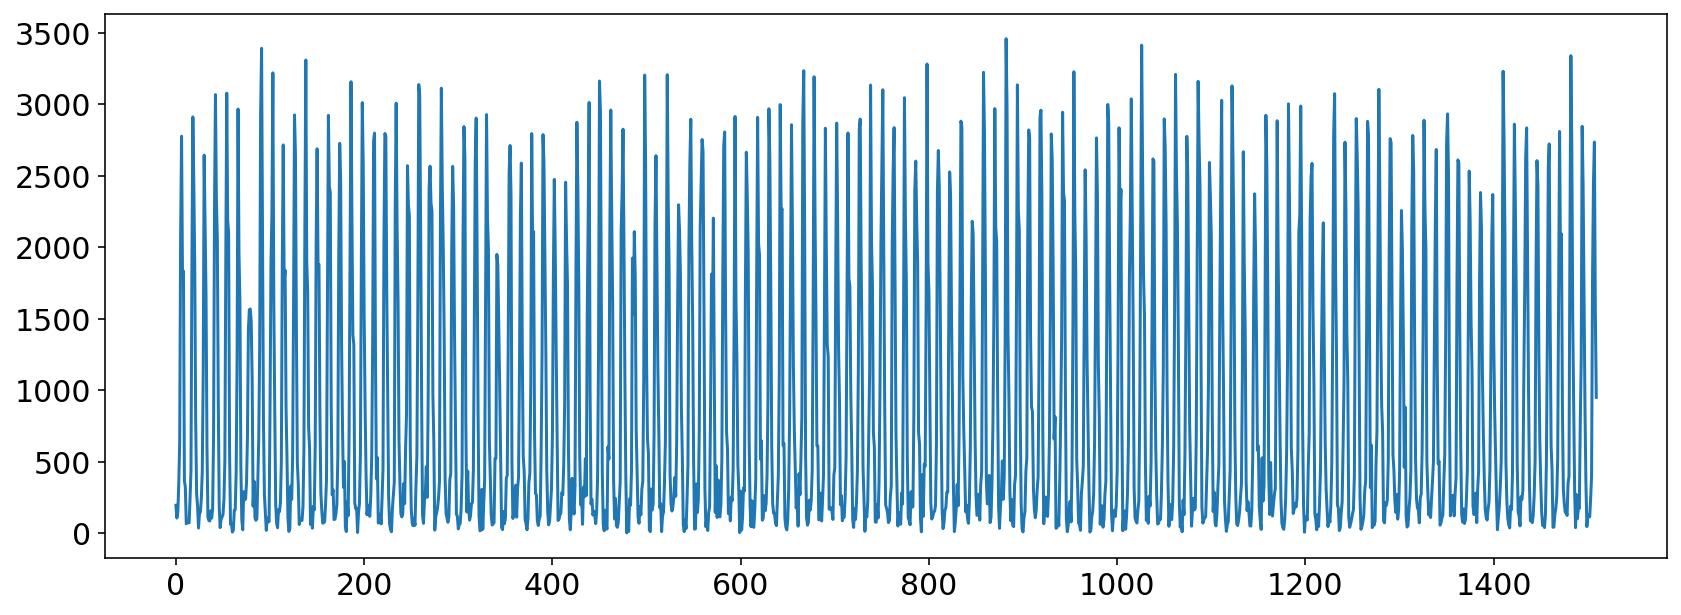

In [ ]:
filepath = "drive/MyDrive/SSA/rain_m.txt"

rain_df = pd.read_csv(filepath, sep = '\t', header=None)
rain = []
for i in range(146):
  rain = rain + [m for m in rain_df.iloc[i]] 

SIZE = 1510;
rain_m = np.array(rain[:SIZE])
plt.figure(figsize=(14,5))
#plt.xlabel('xlabel', fontsize=16)
#plt.ylabel('ylabel', fontsize=16)
rc('xtick', labelsize=15) 
rc('ytick', labelsize=15) 
plt.plot(rain_m);

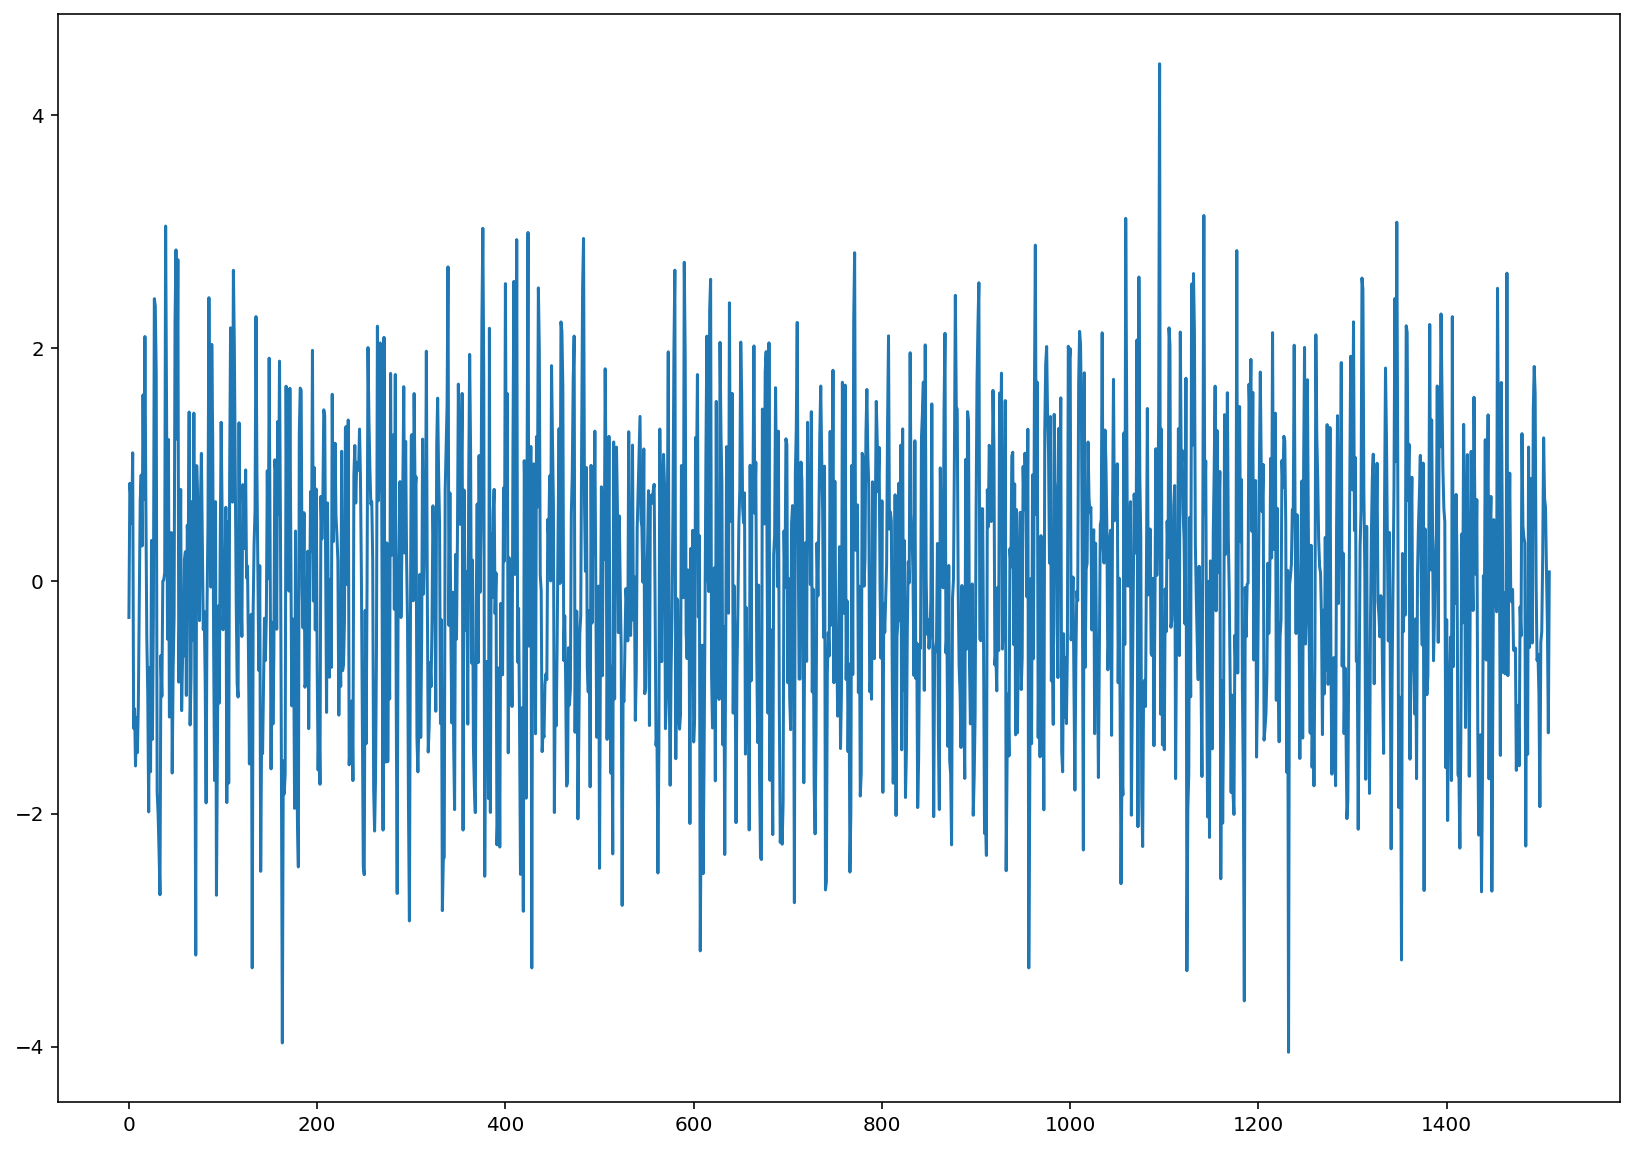

In [ ]:
# sin
SIZE = 1510;
np.random.seed(RANDOM_SEED)
T = 12

tsSin_sig = np.sin(np.arange(SIZE) * 2 * np.pi / T)
#tsSin_sig = (np.sin(np.arange(SIZE) * 2 * np.pi / T) + 1.6 * np.sin(np.arange(SIZE) * 2 * np.pi / (T+2))) * (\
#np.cos(np.arange(SIZE) * 2 * np.pi / (144*3)) + 5)

tsSin = tsSin_sig + np.sqrt((tsSin_sig**2).mean() / 0.5) * np.random.normal(size=SIZE)
plt.plot(tsSin);

In [ ]:
TRAIN_SIZE, VAL_SIZE, TEST_SIZE = 1000, 500, 10;
seq_len = 48;

assert TRAIN_SIZE + VAL_SIZE + TEST_SIZE == SIZE, "wrong TRAIN and VAL sizes"

ssa = edict({
    'L' : TRAIN_SIZE//2,
    'ssa_groups' : list(range(1,8)), #[1,2,3,4,5,6,7],
    'rssa' : rssa
})

# split_data
data = splitData(rain_m, seq_len, TRAIN_SIZE, VAL_SIZE, TEST_SIZE, ssa, val_ssa = True)
#data_sig = splitData(tsSin_sig, seq_len, TRAIN_SIZE, VAL_SIZE, TEST_SIZE, ssa, val_ssa = False)

  0%|          | 1/452 [00:01<11:23,  1.51s/it]From cffi callback <function _processevents at 0x7f37ba732830>:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/rpy2/rinterface_lib/callbacks.py", line 274, in _processevents
    @ffi_proxy.callback(ffi_proxy._processevents_def,
KeyboardInterrupt
100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


In [ ]:
data.val.X_ssa

tensor([[-0.3450,  0.8813,  1.9626,  ..., -0.8017, -0.7501, -0.8028],
        [ 0.8811,  1.9624,  1.8802,  ..., -0.7488, -0.8010, -0.3455],
        [ 1.9625,  1.8803,  0.8764,  ..., -0.8005, -0.3493,  0.8797],
        ...,
        [-0.1356, -0.6082, -0.8249,  ...,  1.8778,  1.8653,  0.8529],
        [-0.6082, -0.8249, -0.9319,  ...,  1.8656,  0.8532, -0.1306],
        [-0.8249, -0.9318, -0.8550,  ...,  0.8534, -0.1306, -0.6005]])

In [ ]:
train_ds = Dataset(data.train.X, data.train.y.reshape(-1, 1))

valid_ds = Dataset(data.val.X, data.val.y.reshape(-1, 1))
#valid_ds_ssa = Dataset(data.val.X_ssa, data.val.y.reshape(-1, 1))

In [ ]:
# sine
#ann_hidden = 100
#rnn_hidden = 65
#gru_hidden = 100
#lstm_hidden = 55

# dsine
#ann_hidden = 55
#rnn_hidden = 70
#gru_hidden = 100
#lstm_hidden = 80

# india_rain
ann_hidden = 60
rnn_hidden = 90
gru_hidden = 65
lstm_hidden = 95

## Fully Connected

In [ ]:
fcnet = NeuralNetRegressor(  FCModel
                         , module__input_size=24
                         , module__hidden_size=ann_hidden
                         , module__output_size=1
                           
                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience = 50)
                         ]
                         , train_split= predefined_split(valid_ds)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

fcnet_ssa = NeuralNetRegressor(  FCModel
                         , module__input_size=24
                         , module__hidden_size=ann_hidden
                         , module__output_size=1       
                        
                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds_ssa)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

In [ ]:
torch.manual_seed(RANDOM_SEED)
fcnet.fit(data.train.X, data.train.y.reshape(-1, 1));
fcnet.history[-1]

{'batches': [{'train_batch_size': 976, 'train_loss': 0.0703197717666626},
  {'valid_batch_size': 226, 'valid_loss': 0.06712563335895538}],
 'dur': 0.014145135879516602,
 'epoch': 611,
 'train_batch_count': 1,
 'train_loss': 0.0703197717666626,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.06712563335895538,
 'valid_loss_best': False}

In [ ]:
torch.manual_seed(RANDOM_SEED)
fcnet_ssa.fit(data.train.X_ssa, data.train.y.reshape(-1, 1));
fcnet_ssa.history[-1]

{'batches': [{'train_batch_size': 976, 'train_loss': 0.07083605229854584},
  {'valid_batch_size': 226, 'valid_loss': 0.06250783801078796}],
 'dur': 0.011909246444702148,
 'epoch': 533,
 'train_batch_count': 1,
 'train_loss': 0.07083605229854584,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.06250783801078796,
 'valid_loss_best': False}

## RNN

In [ ]:
rnnnet = NeuralNetRegressor(  RNN
                         , module__input_size = 1
                         , module__hidden_size = rnn_hidden
                         , module__output_size=1
                         #, module__device = device


                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

rnnnet_ssa = NeuralNetRegressor(  RNN
                         , module__input_size = 1
                         , module__hidden_size = rnn_hidden
                         , module__output_size=1
                         #, module__device = device


                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

In [ ]:
torch.manual_seed(RANDOM_SEED)
rnnnet.fit(data.train.X, data.train.y.reshape(-1, 1));
rnnnet.history[-1]

{'batches': [{'train_batch_size': 976, 'train_loss': 0.06974302232265472},
  {'valid_batch_size': 226, 'valid_loss': 0.06647493690252304}],
 'dur': 0.06289052963256836,
 'epoch': 160,
 'train_batch_count': 1,
 'train_loss': 0.06974302232265472,
 'train_loss_best': False,
 'valid_batch_count': 1,
 'valid_loss': 0.06647493690252304,
 'valid_loss_best': False}

In [ ]:
torch.manual_seed(RANDOM_SEED)
rnnnet_ssa.fit(data.train.X_ssa, data.train.y.reshape(-1, 1));
rnnnet_ssa.history[-1]

{'batches': [{'train_batch_size': 976, 'train_loss': 0.07202058285474777},
  {'valid_batch_size': 226, 'valid_loss': 0.066562220454216}],
 'dur': 0.060016632080078125,
 'epoch': 155,
 'train_batch_count': 1,
 'train_loss': 0.07202058285474777,
 'train_loss_best': False,
 'valid_batch_count': 1,
 'valid_loss': 0.066562220454216,
 'valid_loss_best': False}

## GRU

In [ ]:
grunet = NeuralNetRegressor(  GRU
                         , module__input_size = 1
                         , module__hidden_size = gru_hidden
                         , module__output_size=1
                         #, module__device = device


                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

grunet_ssa = NeuralNetRegressor(  GRU
                         , module__input_size = 1
                         , module__hidden_size = gru_hidden
                         , module__output_size=1
                         #, module__device = device


                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

In [ ]:
torch.manual_seed(RANDOM_SEED)
grunet.fit(data.train.X, data.train.y.reshape(-1, 1));
grunet.history[-1]

{'batches': [{'train_batch_size': 976, 'train_loss': 0.0697331354022026},
  {'valid_batch_size': 226, 'valid_loss': 0.06275386363267899}],
 'dur': 0.12862634658813477,
 'epoch': 414,
 'train_batch_count': 1,
 'train_loss': 0.0697331354022026,
 'train_loss_best': False,
 'valid_batch_count': 1,
 'valid_loss': 0.06275386363267899,
 'valid_loss_best': False}

In [ ]:
torch.manual_seed(RANDOM_SEED)
grunet_ssa.fit(data.train.X_ssa, data.train.y.reshape(-1, 1));
grunet_ssa.history[-1]

{'batches': [{'train_batch_size': 976, 'train_loss': 0.07183767855167389},
  {'valid_batch_size': 226, 'valid_loss': 0.08792394399642944}],
 'dur': 0.12439656257629395,
 'epoch': 156,
 'train_batch_count': 1,
 'train_loss': 0.07183767855167389,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.08792394399642944,
 'valid_loss_best': False}

## LSTM

In [ ]:
lstmnet = NeuralNetRegressor(  LSTM
                         , module__input_size = 1
                         , module__hidden_size = lstm_hidden
                         , module__output_size=1
                         #, module__device = device


                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

lstmnet_ssa = NeuralNetRegressor(  LSTM
                         , module__input_size = 1
                         , module__hidden_size = lstm_hidden
                         , module__output_size=1
                        # , module__device = device


                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds_ssa)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

In [ ]:
torch.manual_seed(RANDOM_SEED)
lstmnet.fit(data.train.X, data.train.y.reshape(-1, 1));
lstmnet.history[-1]

{'batches': [{'train_batch_size': 976, 'train_loss': 0.07260837405920029},
  {'valid_batch_size': 226, 'valid_loss': 0.06207582727074623}],
 'dur': 0.2855713367462158,
 'epoch': 370,
 'train_batch_count': 1,
 'train_loss': 0.07260837405920029,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.06207582727074623,
 'valid_loss_best': False}

In [ ]:
torch.manual_seed(RANDOM_SEED)
lstmnet_ssa.fit(data.train.X_ssa, data.train.y.reshape(-1, 1));
lstmnet_ssa.history[-1]

{'batches': [{'train_batch_size': 976, 'train_loss': 0.07173985242843628},
  {'valid_batch_size': 226, 'valid_loss': 0.06100989133119583}],
 'dur': 0.28281641006469727,
 'epoch': 248,
 'train_batch_count': 1,
 'train_loss': 0.07173985242843628,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.06100989133119583,
 'valid_loss_best': False}

## Results

In [ ]:
pc_ann =  getPredCases(fcnet.module_.to('cpu'), data, tomorrow = True, y_ssa=False, ssa = None)
pc_ssa_ann =  getPredCases(fcnet_ssa.module_.to('cpu'), data, tomorrow = True, y_ssa=False, ssa = ssa)
#====================
pc_rnn =  getPredCases(rnnnet.module_.to('cpu'), data, tomorrow = True, y_ssa=False, ssa = None)
pc_ssa_rnn =  getPredCases(rnnnet_ssa.module_.to('cpu'), data, tomorrow = True, y_ssa=False, ssa = ssa)
#====================
pc_gru =  getPredCases(grunet.module_.to('cpu'), data, tomorrow = True, y_ssa=False, ssa = None)
pc_ssa_gru =  getPredCases(grunet_ssa.module_.to('cpu'), data, tomorrow = True, y_ssa=False, ssa = ssa)
#====================
pc_lstm =  getPredCases(lstmnet.module_.to('cpu'), data, tomorrow = True, y_ssa=False, ssa = None)
pc_ssa_lstm =  getPredCases(lstmnet_ssa.module_.to('cpu'), data, tomorrow = True, y_ssa=False, ssa = ssa)

100%|██████████| 250/250 [00:00<00:00, 557.33it/s]


In [ ]:
errs = {'ANN' : getRMSE(rain_m[-TEST_SIZE:], pc_ann)
        , 'SSA-ANN' : getRMSE(rain_m[-TEST_SIZE:], pc_ssa_ann)
        , 'RNN' : getRMSE(rain_m[-TEST_SIZE:], pc_rnn)
        , 'SSA-RNN' : getRMSE(rain_m[-TEST_SIZE:], pc_ssa_rnn)
        , 'GRU' : getRMSE(rain_m[-TEST_SIZE:], pc_gru)
        , 'SSA-GRU' : getRMSE(rain_m[-TEST_SIZE:], pc_ssa_gru)
        , 'LSTM' : getRMSE(rain_m[-TEST_SIZE:], pc_lstm)
        , 'SSA-LSTM' : getRMSE(rain_m[-TEST_SIZE:], pc_ssa_lstm)
        }
pd.DataFrame().from_dict(errs, orient='index').T

ANN     SSA-ANN         RNN  ...     SSA-GRU        LSTM    SSA-LSTM
0  223.540602  219.889018  220.378617  ...  219.102821  229.615421  217.187251

[1 rows x 8 columns]

In [ ]:
errs = {'ANN' : getRMSE(tsSin_sig[-TEST_SIZE:], pc_ann)
        , 'SSA-ANN' : getRMSE(tsSin_sig[-TEST_SIZE:], pc_ssa_ann)
        , 'RNN' : getRMSE(tsSin_sig[-TEST_SIZE:], pc_rnn)
        , 'SSA-RNN' : getRMSE(tsSin_sig[-TEST_SIZE:], pc_ssa_rnn)
        , 'GRU' : getRMSE(tsSin_sig[-TEST_SIZE:], pc_gru)
        , 'SSA-GRU' : getRMSE(tsSin_sig[-TEST_SIZE:], pc_ssa_gru)
        , 'LSTM' : getRMSE(tsSin_sig[-TEST_SIZE:], pc_lstm)
        , 'SSA-LSTM' : getRMSE(tsSin_sig[-TEST_SIZE:], pc_ssa_lstm)
        }
pd.DataFrame().from_dict(errs, orient='index').T

ANN   SSA-ANN       RNN  ...   SSA-GRU      LSTM  SSA-LSTM
0  0.356541  0.738724  0.293228  ...  0.417707  0.272393  0.353813

[1 rows x 8 columns]

sine 24, L = половина, r = 1:

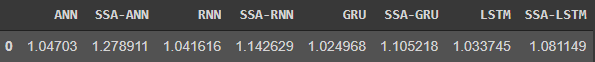

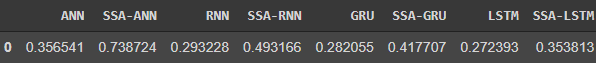

sine 24, L = половина, r = 2:

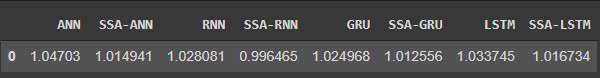

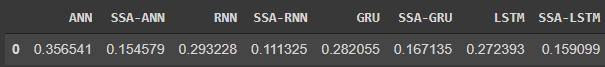

sine 24, L = половина, r = 4:

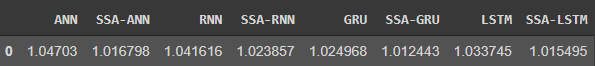

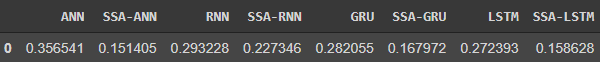

dsine 26, L = 130, r = 4:

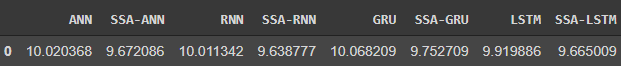

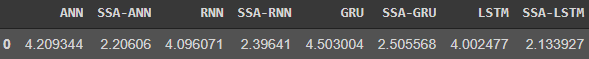

dsine 26, L = 130, r = 8:

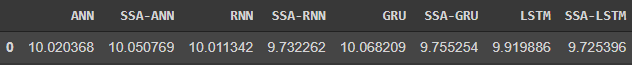

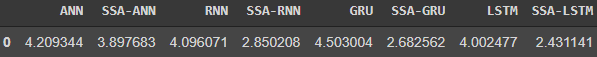

dsine 26, L = 130, r = 12:

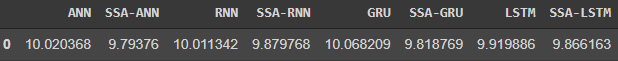

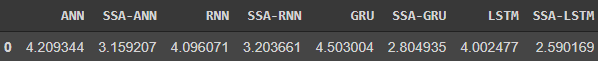

dsine 26, L = 130, r = 16:

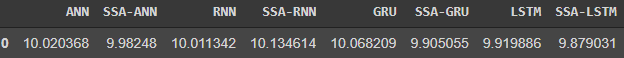

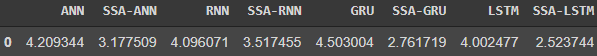


dsine 26, L = половина, r = 4:

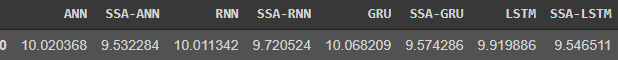

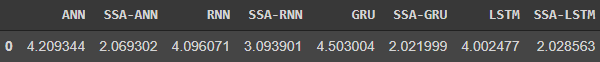

dsine 26, L = половина, r = 8:

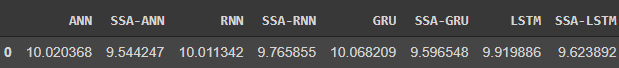

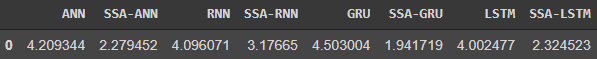

dsine 26, L = половина, r = 12:

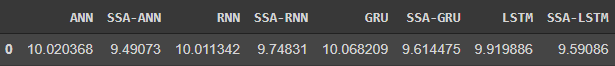

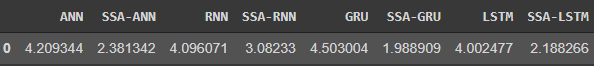

dsine 26, L = половина, r = 16:

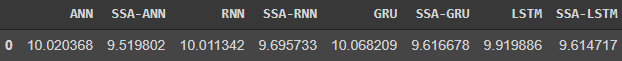

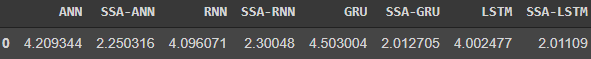

indian_rain 24, L = половина, r = 5:

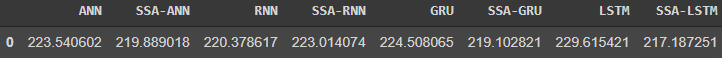

indian_rain 24, L = половина, r = 7:

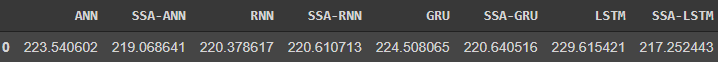

indian_rain 24, L = половина, r = 9:

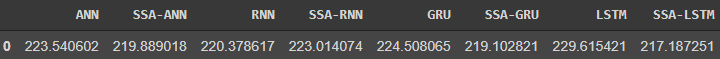

In [ ]:
def saveStats(lPreds, ground_truth, columns = None):
    res = np.zeros(16*250).reshape(-1, 250)
    for i in range(0, len(lPreds)):
        res[2*i] = lPreds[i]
        res[2*i+1] = (lPreds[i] - ground_truth)**2
    res_df = pd.DataFrame(res.T)
    if columns is not None:
      res_df.columns = columns;
    res_df.to_csv("file.csv")
    return res_df

## GridSearchCV for LSTM

In [ ]:
GridSearchLoop('sine', list(range(12, 500, 12)), RANDOM_SEED = RANDOM_SEED)

Saved: ann, 168. Time: 2022-02-21 12:18:05.634780
Saved: rnn, 168. Time: 2022-02-21 12:21:29.052125
Saved: gru, 168. Time: 2022-02-21 12:26:23.042729
Saved: lstm, 168. Time: 2022-02-21 12:32:39.632156
Saved: ann, 192. Time: 2022-02-21 12:32:59.857667
Saved: rnn, 192. Time: 2022-02-21 12:36:49.099565
Saved: gru, 192. Time: 2022-02-21 12:42:05.860474
Saved: lstm, 192. Time: 2022-02-21 12:49:07.706244
Saved: ann, 420. Time: 2022-02-21 12:49:22.041938
Saved: rnn, 420. Time: 2022-02-21 12:54:45.839591
Saved: gru, 420. Time: 2022-02-21 13:03:30.400163
Saved: lstm, 420. Time: 2022-02-21 13:12:17.499917


In [ ]:
def createFolder(path):
  try:
    os.mkdir(path)
  except OSError as e:
    print("Создать директорию %s не удалось" % e)
  except FileExistsError:
    print(f"File {path} already exists")

def makePrediction(net, data):
  preds = getPredsTomorrow(
                net.module_.to('cpu')
              , data.ts[:TRAIN_SIZE][-data.seq_len:]
              , data.ts[TRAIN_SIZE : (TRAIN_SIZE+VAL_SIZE)] 
              , data.scaler
              , VAL_SIZE
              , data.seq_len
              , verbose = False
              )
          
  pc = data.scaler.inverse_transform(
            np.expand_dims(preds, axis=0)
              ).flatten()
  return pc

def searchBestSeriesValueByGrid(time_series, models, folder, T_lens, hl_lens, RANDOM_SEED):
  for T in T_lens:
    createFolder(f'drive/MyDrive/SSA/{folder}/{str(T)}')

    data = splitData(time_series, T, TRAIN_SIZE, VAL_SIZE, TEST_SIZE, ssa, val_ssa = False)
    valid_ds = Dataset(data.val.X, data.val.y.reshape(-1, 1))


    for model in models:
      lResults = []
      best_score = 100000

      for hl in hl_lens:
        net = NeuralNetRegressor( model[0]
                              , module__input_size = T if model[1] == 'ann' else 1 
                              , module__hidden_size = hl
                              , module__output_size = 1
                              #, module__device = device


                              , callbacks = [
                                            MyEarlyStopping(monitor='valid_loss', patience = 50) 
                              ]
                              , train_split= predefined_split(valid_ds)
                              , max_epochs = 5000
                              , optimizer=torch.optim.Adam
                              , lr=0.001
                              , batch_size = -1
                              , verbose=0
                              , device = device
                              , criterion = torch.nn.modules.loss.MSELoss
                              #, optimizer__weight_decay=0.01
                              )
          
        torch.manual_seed(RANDOM_SEED)
        net.fit(data.train.X, data.train.y.reshape(-1, 1))
        
        pc = makePrediction(net, data)

        lResults.append( getRMSE(time_series[TRAIN_SIZE:(TRAIN_SIZE+VAL_SIZE)], pc) )
    
      with open(f'drive/MyDrive/SSA/{folder}/{str(T)}/{model[1]}_series.txt', 'w') as f:
        for item in lResults:
          f.write("%s\n" % item)

      print(f"Saved: {model[1]}, {T}. Time: {datetime.datetime.now()}")

In [ ]:
models = [(FCModel, 'ann')
            , (RNN, 'rnn')
            , (GRU, 'gru')
            , (LSTM, 'lstm')]

searchBestSeriesValueByGrid(rain_m, models, 'indian_rain', list(range(372, 500, 36)), list(range(10, 101, 15)), RANDOM_SEED = RANDOM_SEED)


Создать директорию [Errno 17] File exists: 'drive/MyDrive/SSA/indian_rain/372' не удалось
Saved: ann, 372. Time: 2022-02-22 12:11:03.147480
Saved: rnn, 372. Time: 2022-02-22 12:16:02.378735
Saved: gru, 372. Time: 2022-02-22 12:23:02.140399
Saved: lstm, 372. Time: 2022-02-22 12:29:25.113551
Saved: ann, 408. Time: 2022-02-22 12:29:34.560317
Saved: rnn, 408. Time: 2022-02-22 12:35:27.973500
Saved: gru, 408. Time: 2022-02-22 12:46:23.319283
Saved: lstm, 408. Time: 2022-02-22 12:54:04.451386
Saved: ann, 444. Time: 2022-02-22 12:54:15.257093
Saved: rnn, 444. Time: 2022-02-22 12:59:36.181333
Saved: gru, 444. Time: 2022-02-22 13:07:07.708034
Saved: lstm, 444. Time: 2022-02-22 13:13:49.830535
Saved: ann, 480. Time: 2022-02-22 13:14:00.357011
Saved: rnn, 480. Time: 2022-02-22 13:18:41.734580
Saved: gru, 480. Time: 2022-02-22 13:25:54.427054
Saved: lstm, 480. Time: 2022-02-22 13:31:46.888504


In [ ]:
def GridSearchLoop(folder, seq_lens, RANDOM_SEED):
  models = [(FCModel, 'ann')
            , (RNN, 'rnn')
            , (GRU, 'gru')
            , (LSTM, 'lstm')]

  params = list(range(10, 101, 5))

  for sl in seq_lens:

    if os.path.isdir(f'drive/MyDrive/SSA/{folder}/{str(sl)}') is not True:
      try:
        os.mkdir(f'drive/MyDrive/SSA/{folder}/{str(sl)}')
      except OSError:
        print ("Создать директорию %s не удалось" % path)

      data = splitData(tsSin, sl, TRAIN_SIZE, VAL_SIZE, TEST_SIZE, ssa, val_ssa = False)
      valid_ds = Dataset(data.val.X, data.val.y.reshape(-1, 1))

      for model in models:
        lResultsSeries = []
        lResultsSignal = []
        best_score = 100000
        best_param = None

        for param in params:
          net = NeuralNetRegressor( model[0]
                              , module__input_size = sl if model[1] == 'ann' else 1 
                              , module__hidden_size = param
                              , module__output_size = 1
                              #, module__device = device


                              , callbacks = [
                                            MyEarlyStopping(monitor='valid_loss', patience = 50) 
                              ]
                              , train_split= predefined_split(valid_ds)
                              , max_epochs = 5000
                              , optimizer=torch.optim.Adam
                              , lr=0.001
                              , batch_size = -1
                              , verbose=0
                              , device = device
                              , criterion = torch.nn.modules.loss.MSELoss
                              #, optimizer__weight_decay=0.01
                              )
          
          torch.manual_seed(RANDOM_SEED)
          net.fit(data.train.X, data.train.y.reshape(-1, 1))
        
          preds = getPredsTomorrow(
                net.module_.to('cpu')
              , data.ts[:TRAIN_SIZE][-data.seq_len:]
              , data.ts[TRAIN_SIZE : (TRAIN_SIZE+VAL_SIZE)] 
              , data.scaler
              , VAL_SIZE
              , data.seq_len
              , verbose = False
              )
          
          pc = data.scaler.inverse_transform(
            np.expand_dims(preds, axis=0)
              ).flatten()

          

          if (best_score > net.history[-1]['valid_loss']):
              best_score = net.history[-1]['valid_loss']
              best_param = param

          lResultsSeries.append( getRMSE(tsSin[TRAIN_SIZE:(TRAIN_SIZE+VAL_SIZE)], pc) )
          lResultsSignal.append( getRMSE(tsSin_sig[TRAIN_SIZE:(TRAIN_SIZE+VAL_SIZE)], pc) )

        with open(f'drive/MyDrive/SSA/{folder}/{str(sl)}/{model[1]}_series.txt', 'w') as f:
          for item in lResultsSeries:
            f.write("%s\n" % item)

        with open(f'drive/MyDrive/SSA/{folder}/{str(sl)}/{model[1]}_signal.txt', 'w') as f:
          for item in lResultsSignal:
            f.write("%s\n" % item)

        print(f"Saved: {model[1]}, {sl}. Time: {datetime.datetime.now()}")

In [ ]:
def customGridSearch(params, train_ds, val_ds, RANDOM_SEED):
  lResultsSeries = []
  lResultsSignal = []
  best_score = 100000
  best_param = None

  for param in params:
    net = NeuralNetRegressor( LSTM
                         , module__input_size = 1
                         , module__hidden_size = param
                         , module__output_size = 1
                         #, module__device = device


                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience = 50) 
                         ]
                         , train_split= predefined_split(val_ds)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device
                         , criterion = torch.nn.modules.loss.MSELoss
                         #, optimizer__weight_decay=0.01
                         )
    
    torch.manual_seed(RANDOM_SEED)
    net.fit(train_ds[0], train_ds[1])
    #pc =  getPredCases(net.module_.to('cpu'), data, tomorrow = True, y_ssa=False, ssa = None)
  
    preds = getPredsTomorrow(
          net.module_.to('cpu')
        , data.ts[:TRAIN_SIZE][-data.seq_len:]
        , data.ts[TRAIN_SIZE : (TRAIN_SIZE+VAL_SIZE)] 
        , data.scaler
        , VAL_SIZE
        , data.seq_len
        )
    
    #seq = applySSA(data.ts[:data.train.size], ssa)
    #seq = seq[-data.seq_len:]
    #preds = getPredsTomorrow(
    #      lstmnet.module_.to('cpu')
    #    , seq
    #    , data_test.test.ts_ssa
    #    , data.scaler_ssa
    #    , VAL_SIZE
    #    , data.seq_len
    #    )
    
    pc = data.scaler.inverse_transform(
       np.expand_dims(preds, axis=0)
        ).flatten()

    

    print(
          "Param:", param
          , "; Loss series:", getRMSE(tsSin[TRAIN_SIZE:(TRAIN_SIZE+VAL_SIZE)], pc)
          , "; Loss signal:", getRMSE(tsSin_sig[TRAIN_SIZE:(TRAIN_SIZE+VAL_SIZE)], pc)
          ) 

    if (best_score > net.history[-1]['valid_loss']):
        best_score = net.history[-1]['valid_loss']
        best_param = param

    lResultsSeries.append( getRMSE(tsSin[TRAIN_SIZE:(TRAIN_SIZE+VAL_SIZE)], pc) )
    lResultsSignal.append( getRMSE(tsSin_sig[TRAIN_SIZE:(TRAIN_SIZE+VAL_SIZE)], pc) )

  return best_param, (lResultsSeries, lResultsSignal)

In [ ]:
 _, lRNN = customGridSearch(list(range(10, 101, 5)), (data.train.X, data.train.y.reshape(-1, 1)), valid_ds, RANDOM_SEED = RANDOM_SEED)

100%|██████████| 500/500 [00:01<00:00, 328.98it/s]


Param: 10 ; Loss series: 1.0300846753508677 ; Loss signal: 0.23738245156706583


100%|██████████| 500/500 [00:01<00:00, 334.90it/s]

Param: 15 ; Loss series: 1.0252137780002792 ; Loss signal: 0.2394115560996176



100%|██████████| 500/500 [00:01<00:00, 321.20it/s]

Param: 20 ; Loss series: 1.0272822668408619 ; Loss signal: 0.21789971692710544



100%|██████████| 500/500 [00:01<00:00, 325.32it/s]


Param: 25 ; Loss series: 1.0247540678765925 ; Loss signal: 0.20899272401160646


100%|██████████| 500/500 [00:01<00:00, 312.95it/s]

Param: 30 ; Loss series: 1.0282558058165676 ; Loss signal: 0.22757005630437904



100%|██████████| 500/500 [00:01<00:00, 317.80it/s]

Param: 35 ; Loss series: 1.0235837470361637 ; Loss signal: 0.19775567798735097



100%|██████████| 500/500 [00:01<00:00, 315.94it/s]

Param: 40 ; Loss series: 1.0266249100509572 ; Loss signal: 0.22193310718391032



100%|██████████| 500/500 [00:01<00:00, 306.93it/s]


Param: 45 ; Loss series: 1.024073980896611 ; Loss signal: 0.20911542155600893


100%|██████████| 500/500 [00:01<00:00, 313.26it/s]

Param: 50 ; Loss series: 1.0276055697241402 ; Loss signal: 0.20979948926428157



100%|██████████| 500/500 [00:01<00:00, 298.57it/s]

Param: 55 ; Loss series: 1.0259907285915584 ; Loss signal: 0.20684555792167955



100%|██████████| 500/500 [00:01<00:00, 289.71it/s]


Param: 60 ; Loss series: 1.0259909644742562 ; Loss signal: 0.2160224279841432


100%|██████████| 500/500 [00:01<00:00, 293.73it/s]

Param: 65 ; Loss series: 1.0254396342360004 ; Loss signal: 0.2107317079219329



100%|██████████| 500/500 [00:01<00:00, 289.57it/s]


Param: 70 ; Loss series: 1.0259592454826971 ; Loss signal: 0.2067035749397715


100%|██████████| 500/500 [00:01<00:00, 285.88it/s]


Param: 75 ; Loss series: 1.026471497239222 ; Loss signal: 0.2009195981892608


100%|██████████| 500/500 [00:01<00:00, 288.40it/s]


Param: 80 ; Loss series: 1.027687951536981 ; Loss signal: 0.21180052054954585


100%|██████████| 500/500 [00:01<00:00, 272.41it/s]


Param: 85 ; Loss series: 1.0269312101694505 ; Loss signal: 0.20575012042112065


100%|██████████| 500/500 [00:01<00:00, 270.69it/s]


Param: 90 ; Loss series: 1.0271698361113908 ; Loss signal: 0.19892382345154017


100%|██████████| 500/500 [00:01<00:00, 259.66it/s]


Param: 95 ; Loss series: 1.0260101098299594 ; Loss signal: 0.1995112489639009


100%|██████████| 500/500 [00:01<00:00, 257.07it/s]

Param: 100 ; Loss series: 1.025376899416245 ; Loss signal: 0.19848459354578848


In [ ]:
path = 'data/results/'
folder = 'sine'
names = ['ann','rnn','gru','lstm']

print(path)
dPlotData = collectPlotData(path, folder, names)

values = []

for name in names:
    plot_data = getDataFrameFromDict(dPlotData, name)
    top3_hl = plot_data.groupby('hidden layer').mean().sort_values('rmse').index[:3]
    print(top3_hl)
    top3_df = plot_data.loc[plot_data['hidden layer'].isin(top3_hl)]
    for i, rmse_value in enumerate(top3_df.groupby('T').mean().rmse.values):
        values.append([rmse_value, name, top3_df.groupby('T').mean().rmse.index[i]])
        
path += 'SSA/'
print(path)
dPlotData = collectPlotData(path, folder, names)

for name in names:
    plot_data = getDataFrameFromDict(dPlotData, name)
    top3_hl = plot_data.groupby('hidden layer').mean().sort_values('rmse').index[:3]
    print(top3_hl)
    top3_df = plot_data.loc[plot_data['hidden layer'].isin(top3_hl)]
    for i, rmse_value in enumerate(top3_df.groupby('T').mean().rmse.values):
        values.append([rmse_value, name + '_ssa', top3_df.groupby('T').mean().rmse.index[i]])
        
plot_data = pd.DataFrame(values, columns = ['rmse', 'model', 'T'])

In [ ]:
folder = 'sine'
name = 'lstm'

with open(f'drive/MyDrive/SSA/{folder}/{str(seq_len)}/{name}_series.txt', 'w') as f:
    for item in lRNN[0]:
        f.write("%s\n" % item)

with open(f'drive/MyDrive/SSA/{folder}/{str(seq_len)}/{name}_signal.txt', 'w') as f:
    for item in lRNN[1]:
        f.write("%s\n" % item)

0.011824857649826296


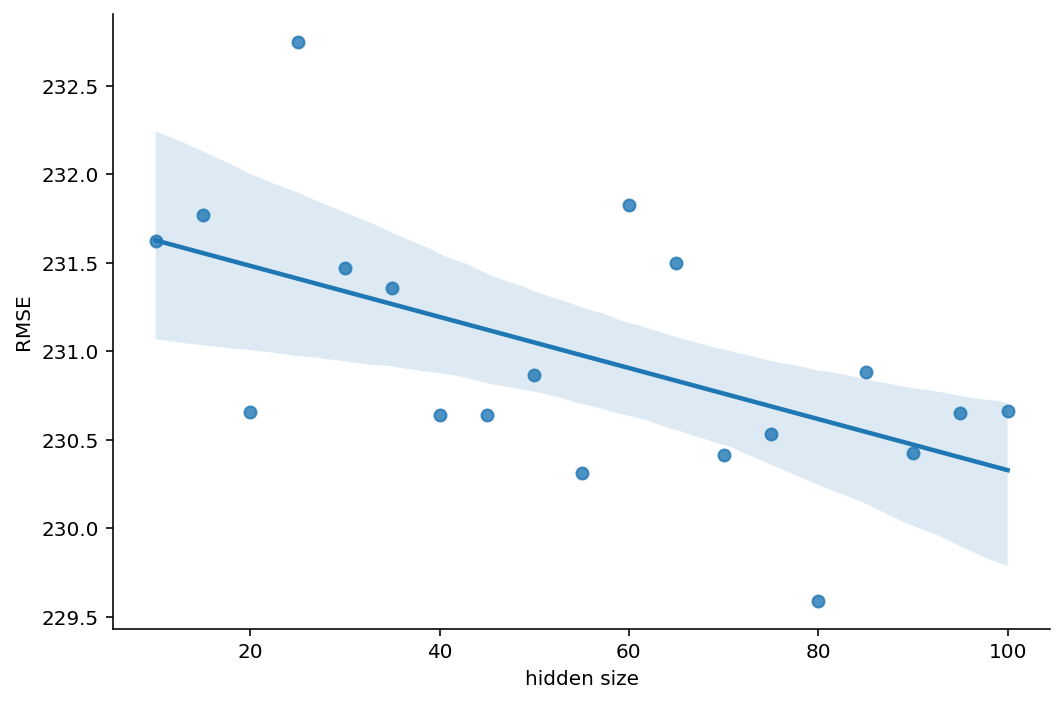

In [ ]:
folder = 'indian_rain'
seq_len = 24
name = 'gru'

x_axis = list(range(10, 101, 5))

l1 = np.loadtxt(f'drive/MyDrive/SSA/{folder}/{str(seq_len)}/{name}_ssa_series.txt')
#l2 = np.loadtxt(f'drive/MyDrive/SSA/{folder}/{str(seq_len)}/{name}_signal.txt')

sns.lmplot(x="hidden size", y="RMSE", data=pd.DataFrame(np.array([x_axis, l1]).T, columns=['hidden size','RMSE']), height=5, aspect=1.5);
#sns.lmplot(x="hidden size", y="RMSE", data=pd.DataFrame(np.array([x_axis, l2]).T, columns=['hidden size','RMSE']), height=5, aspect=1.5);

X2 = sm.add_constant(x_axis)
est = sm.OLS(l1, X2)
est2 = est.fit()

print(est2.pvalues[1])

#est = sm.OLS(l2, X2)
#est2 = est.fit()

#print(est2.pvalues[1])

In [ ]:
folder = 'indian_rain'
names = ['ann','rnn','gru','lstm']
seq_lens = list(range(12, 500, 36))

results = {}

x_except = set()
for name in names:
  lSeries = []

  for sl in seq_lens:
    #data_series = None
    try:
        data_signal = np.loadtxt(f'drive/MyDrive/SSA/{folder}/{sl}/{name}_series.txt')
    except OSError:
      x_except.add(sl)
      print(f"Can't open {sl} folder, {name} method")

    lSeries.append(data_signal)

  results.update({name : lSeries})

In [ ]:
plot_data = np.array(results['ann'])

NameError: ignored

In [ ]:
res = []
for i in range(len(plot_data.T)):
  for k, x in enumerate(plot_data.T[i]):
    res.append([x, 12 + k*36, 10 + i*15])

In [ ]:
sns.scatterplot(x="T", y="rmse", data=pd.DataFrame(res, columns=['rmse', 'T', 'hidden layer']), hue='hidden layer', palette = 'flare');

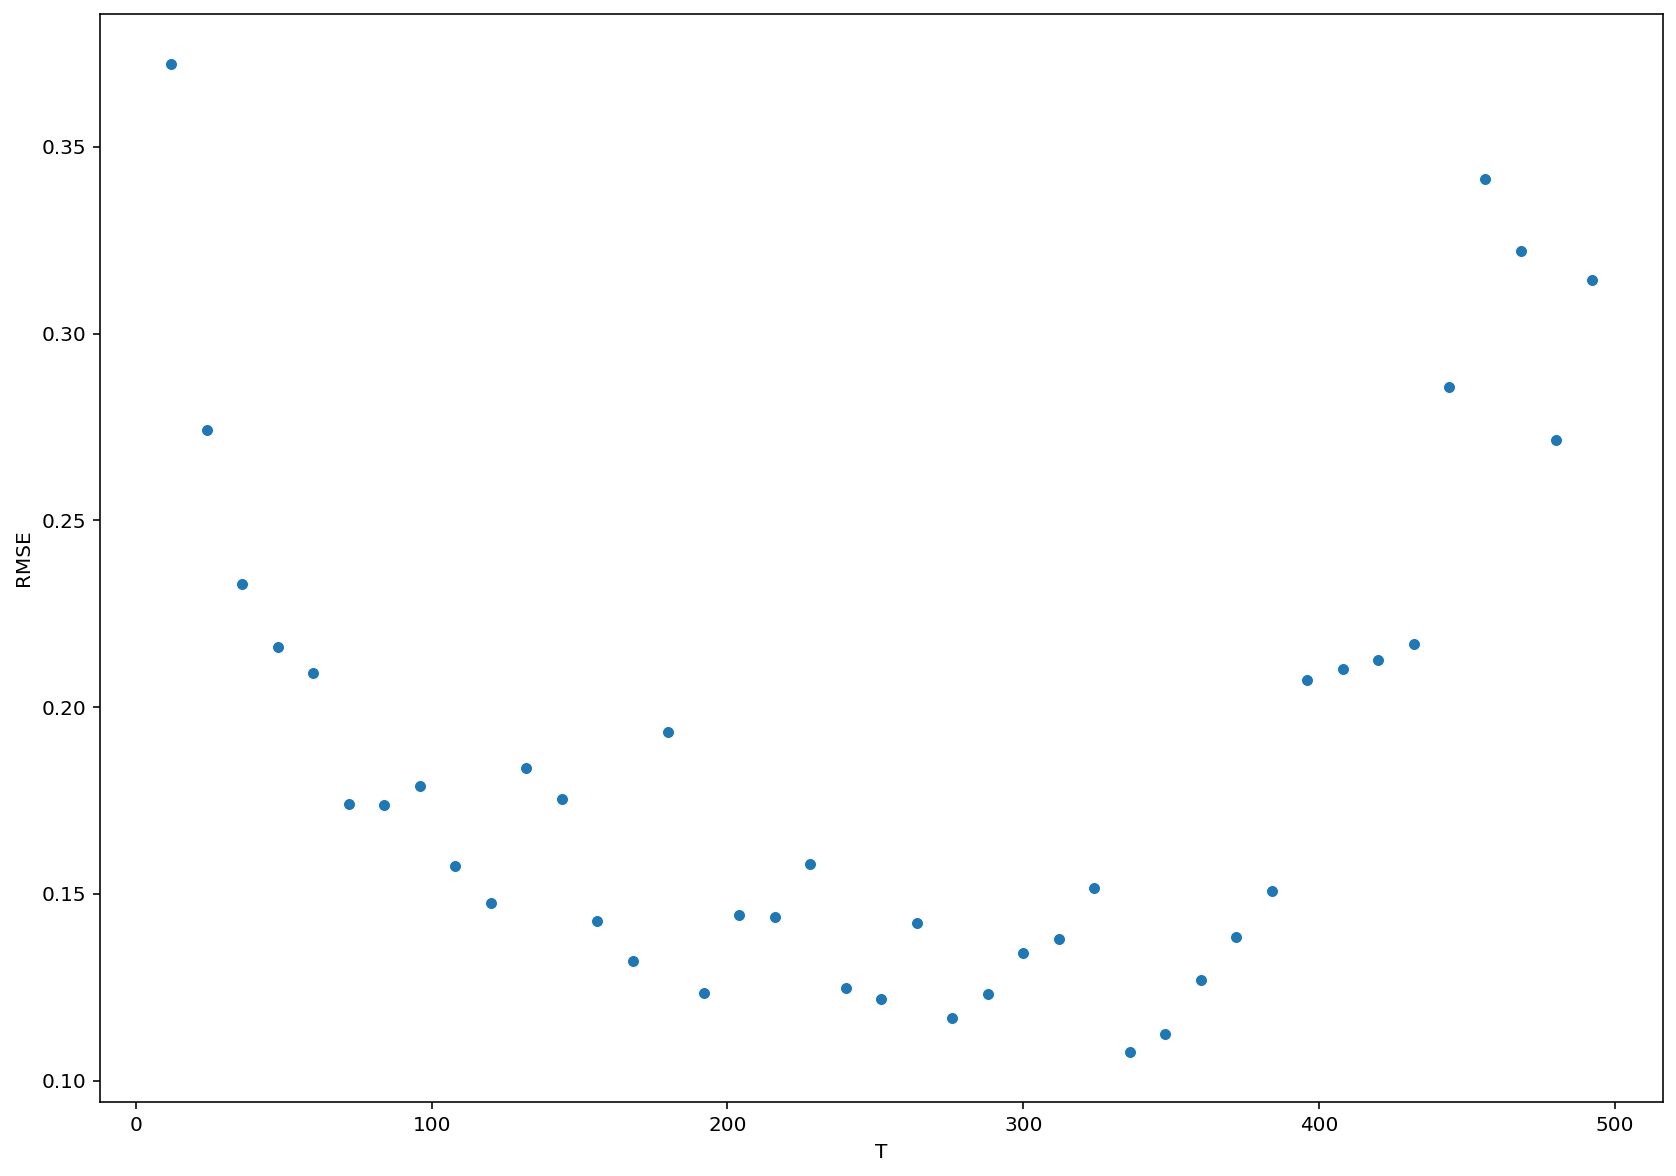

In [ ]:
sns.scatterplot(x="T", y="RMSE", data=pd.DataFrame(np.array([x_axis, plot_data.T[10]]).T, columns=['T','RMSE']));

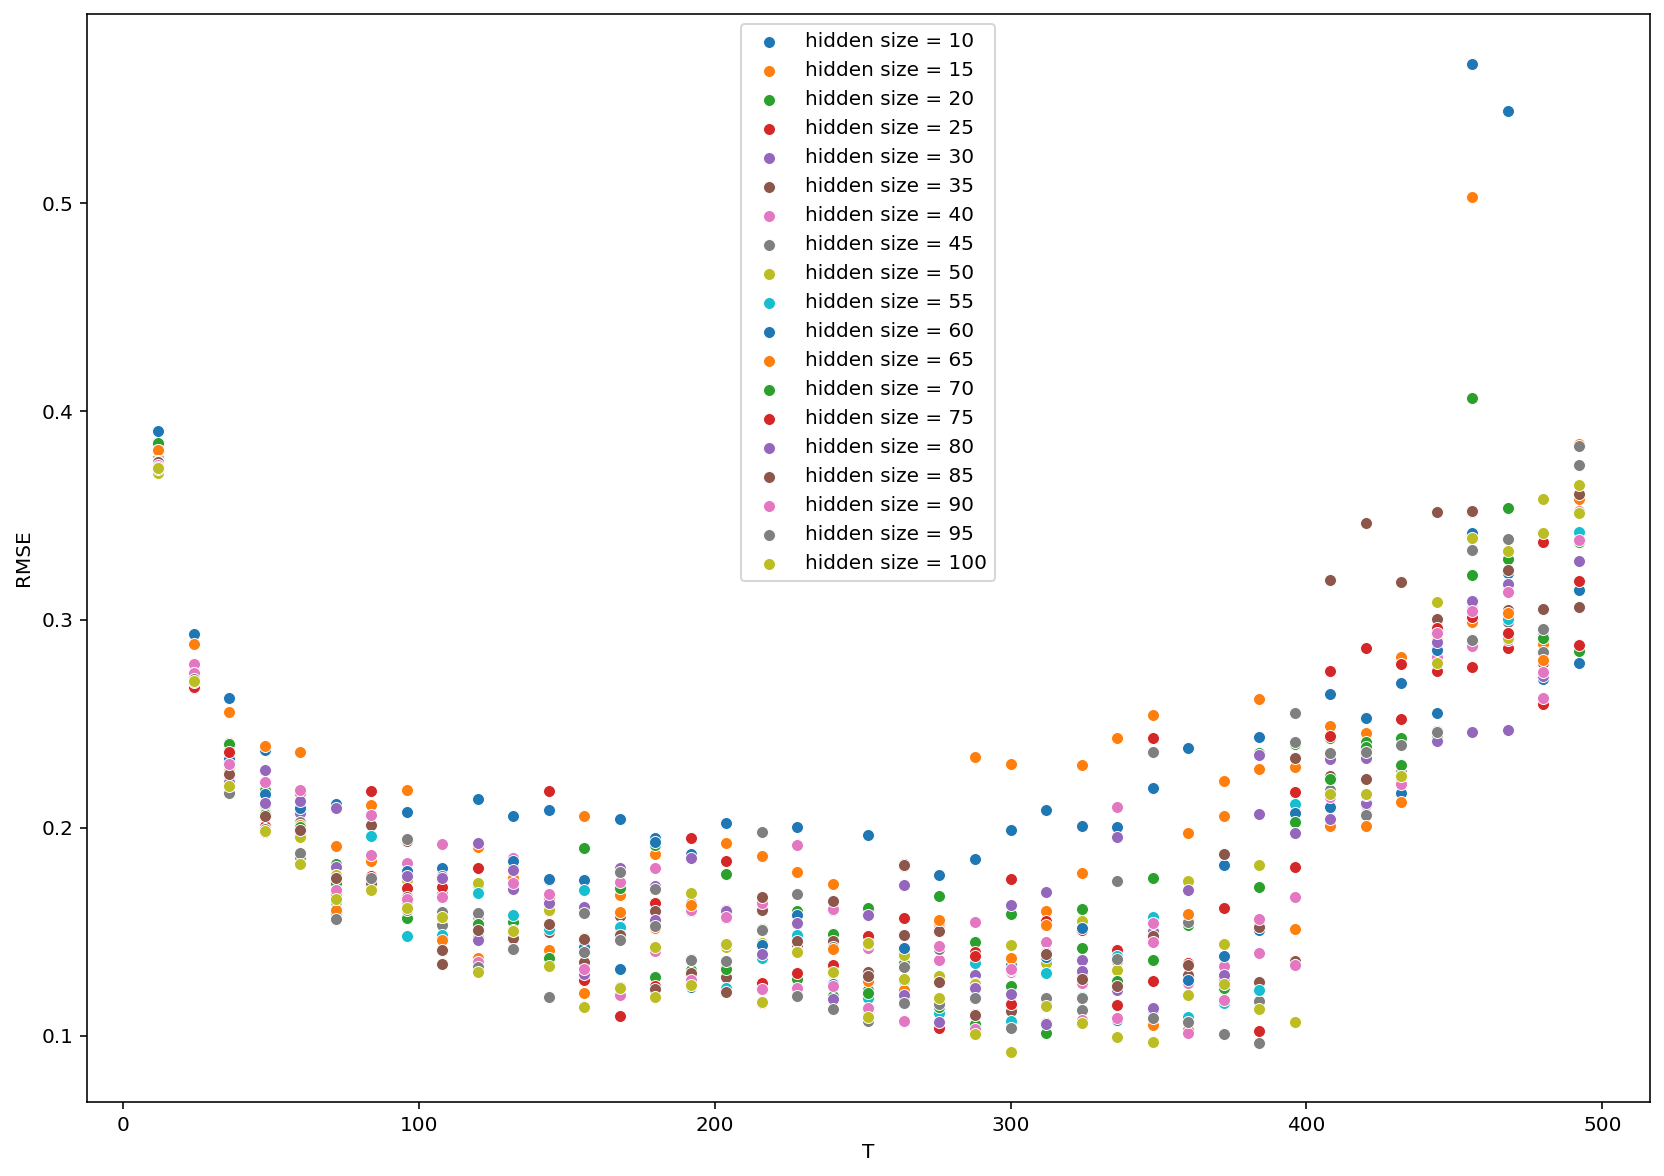

In [ ]:
x_axis = list(range(12, 500, 12))

fig, ax = plt.subplots()
for i, rmse in enumerate(plot_data.T):
    sns.scatterplot(x="T", y="RMSE", data=pd.DataFrame(np.array([x_axis, rmse]).T, columns=['T','RMSE']), ax = ax, label = f"hidden size = {10 + i*5}", palette='magma');
    ax.legend(loc = 0)

In [ ]:
plot_data.T[0]


array([0.43074276, 0.35193496, 0.28530297, 0.31328755, 0.27294608,
       0.26018257, 0.27804096, 0.27237576, 0.24996169, 0.26245991,
       0.2333612 , 0.2131939 , 0.25075243, 0.29656907, 0.2649685 ,
       0.27460108, 0.25880192, 0.27292943, 0.24748778, 0.22842866,
       0.25978592, 0.25892191, 0.254498  , 0.23117788, 0.23222317,
       0.28507766, 0.26140496, 0.25675128, 0.26334386, 0.21821035,
       0.25316329, 0.35281093, 0.18587548, 0.25780354, 0.30462395,
       0.27697042, 0.31169253, 0.2723897 , 0.26218645, 0.26225583,
       0.38689932])

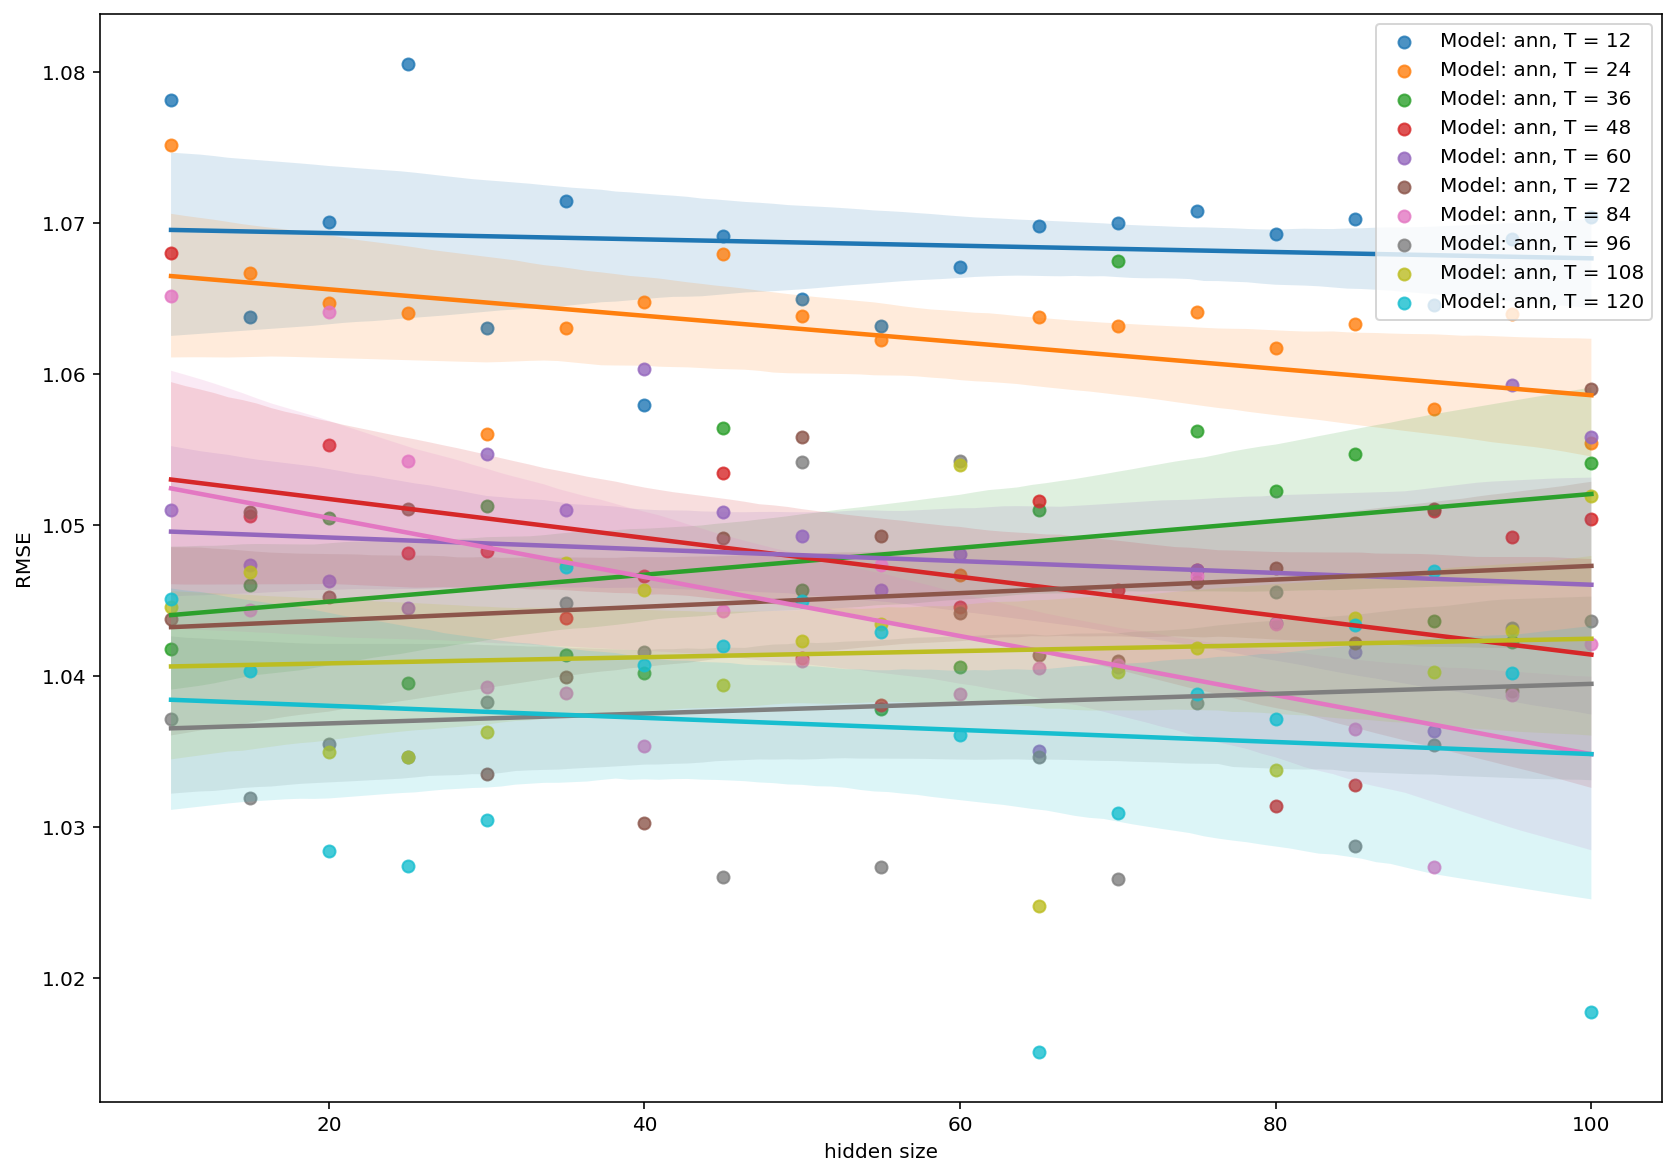

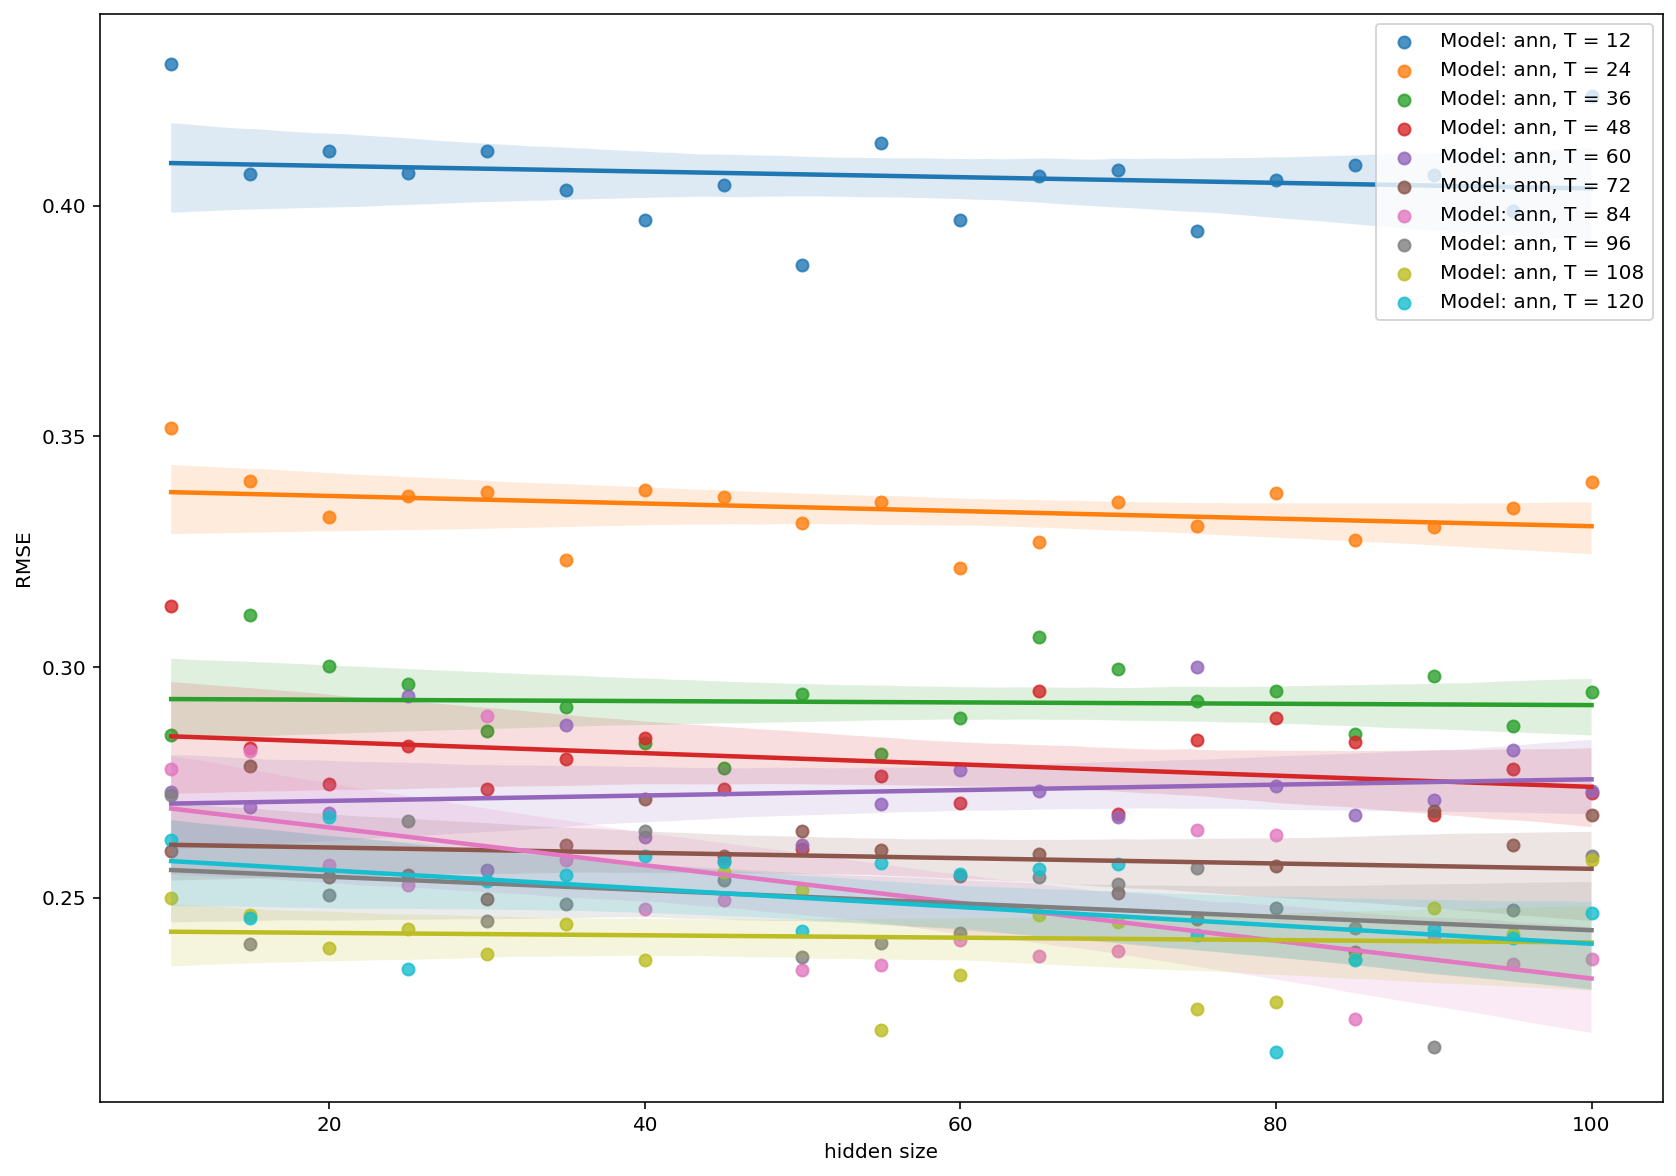

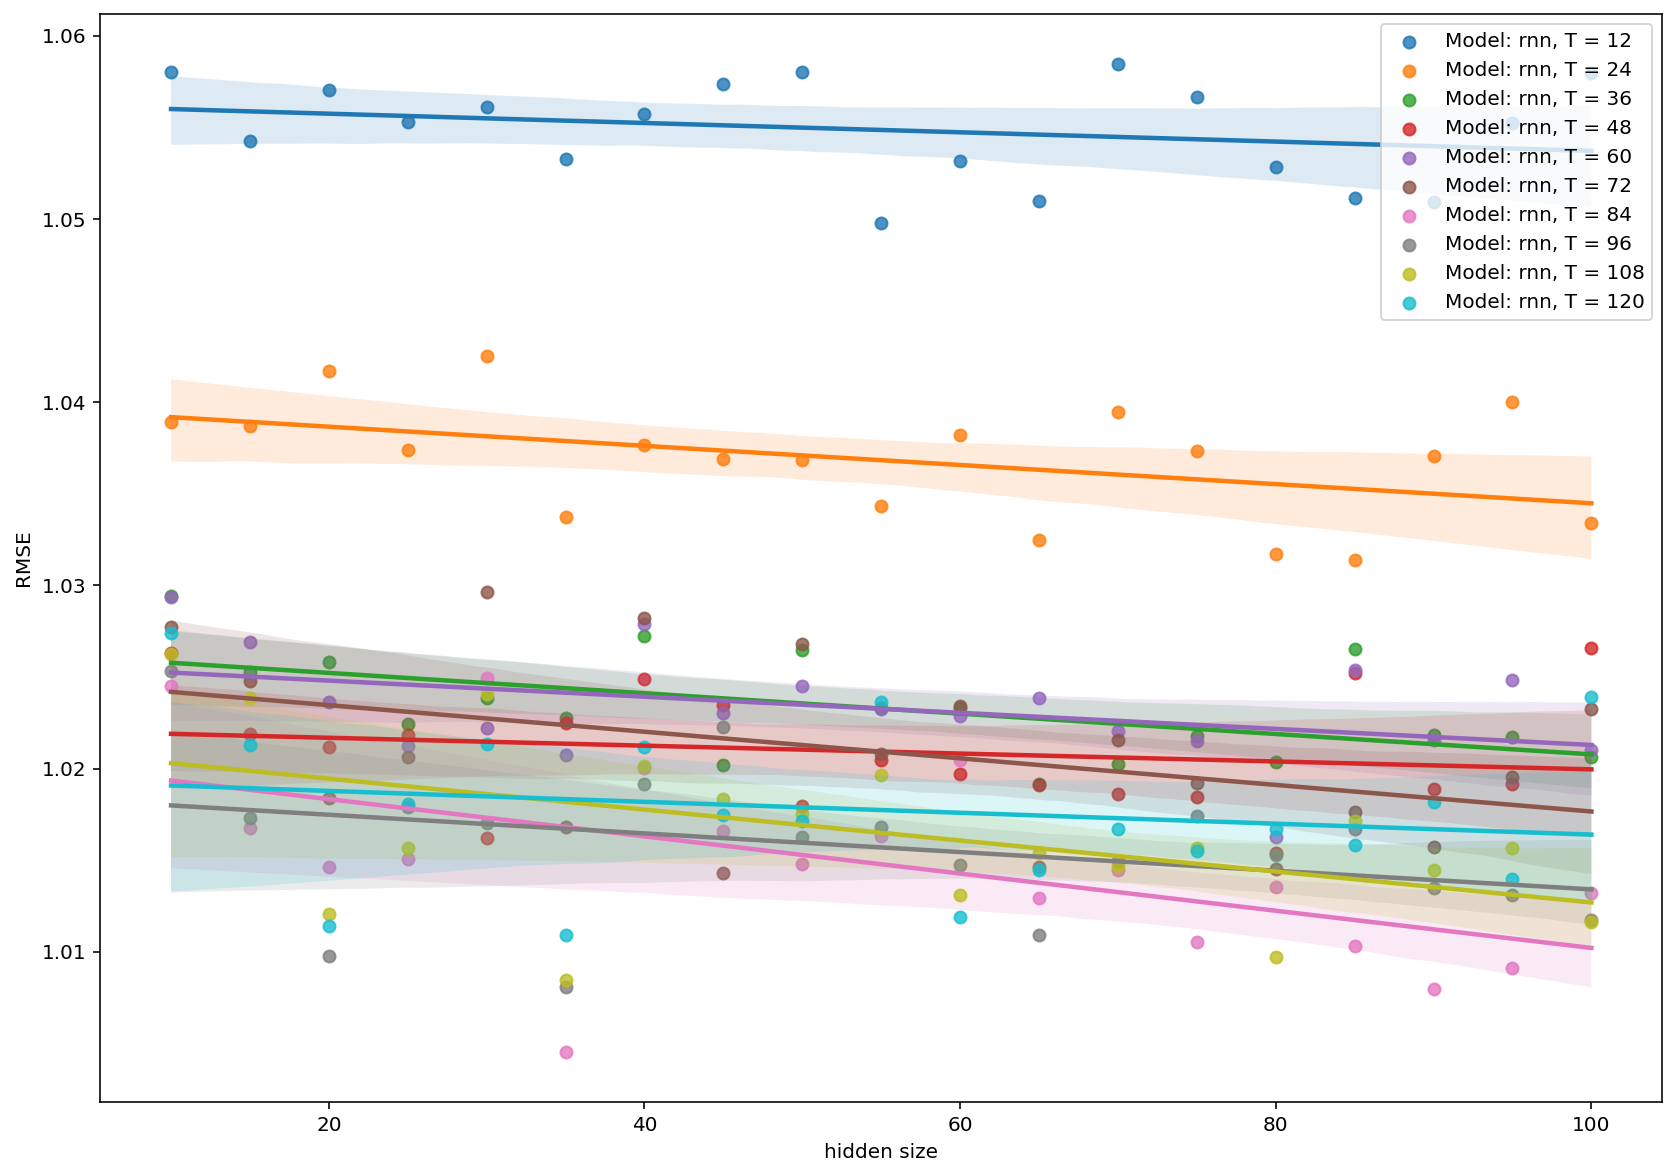

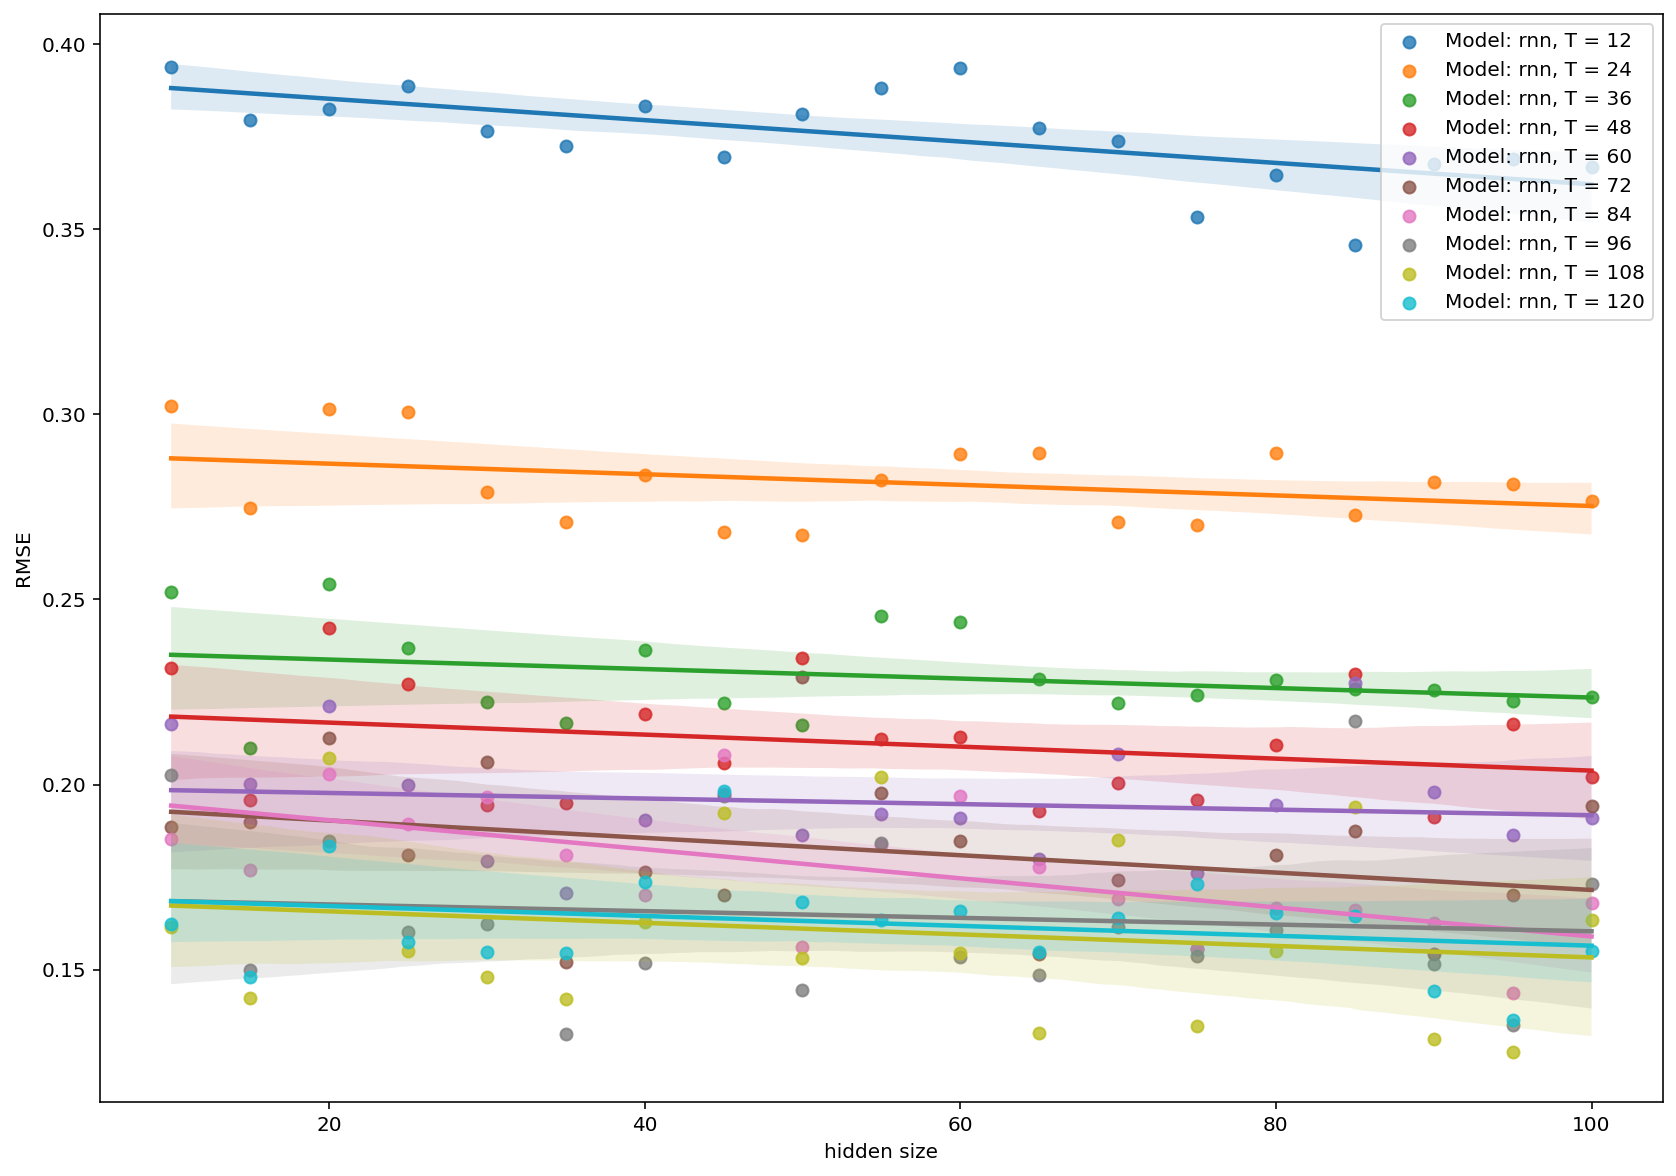

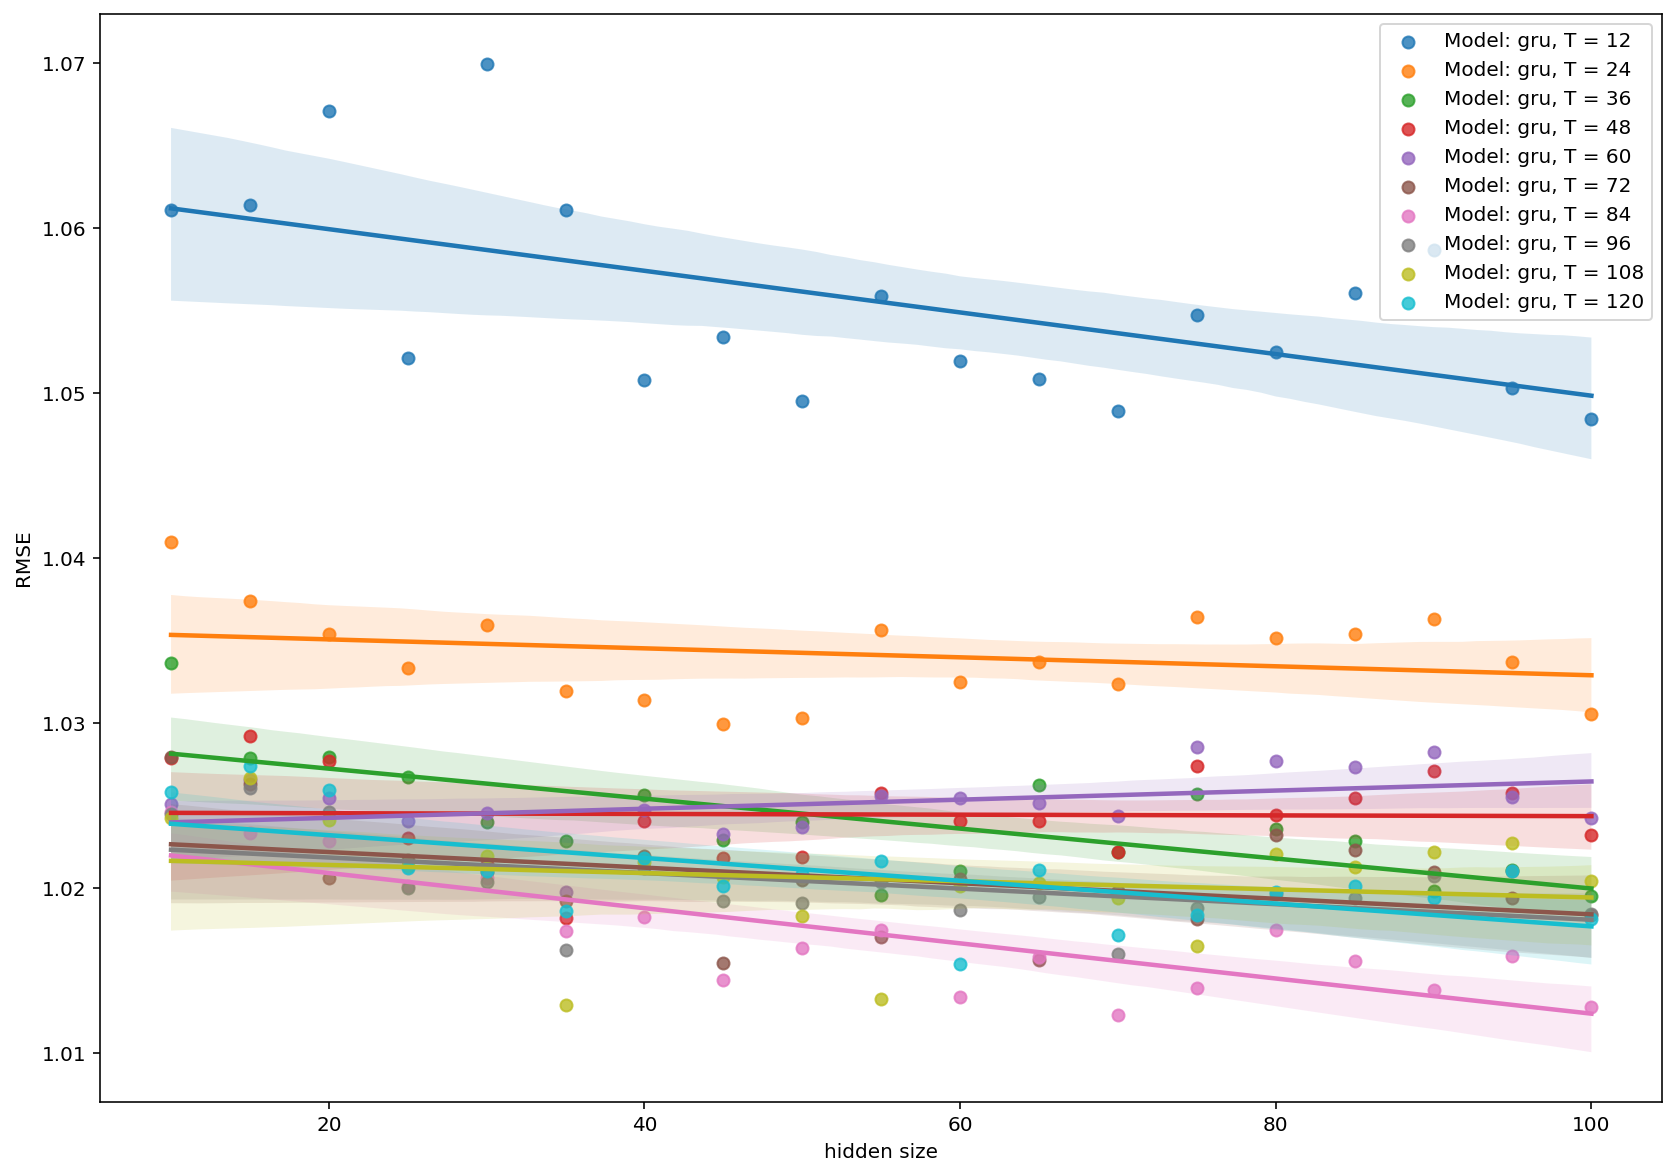

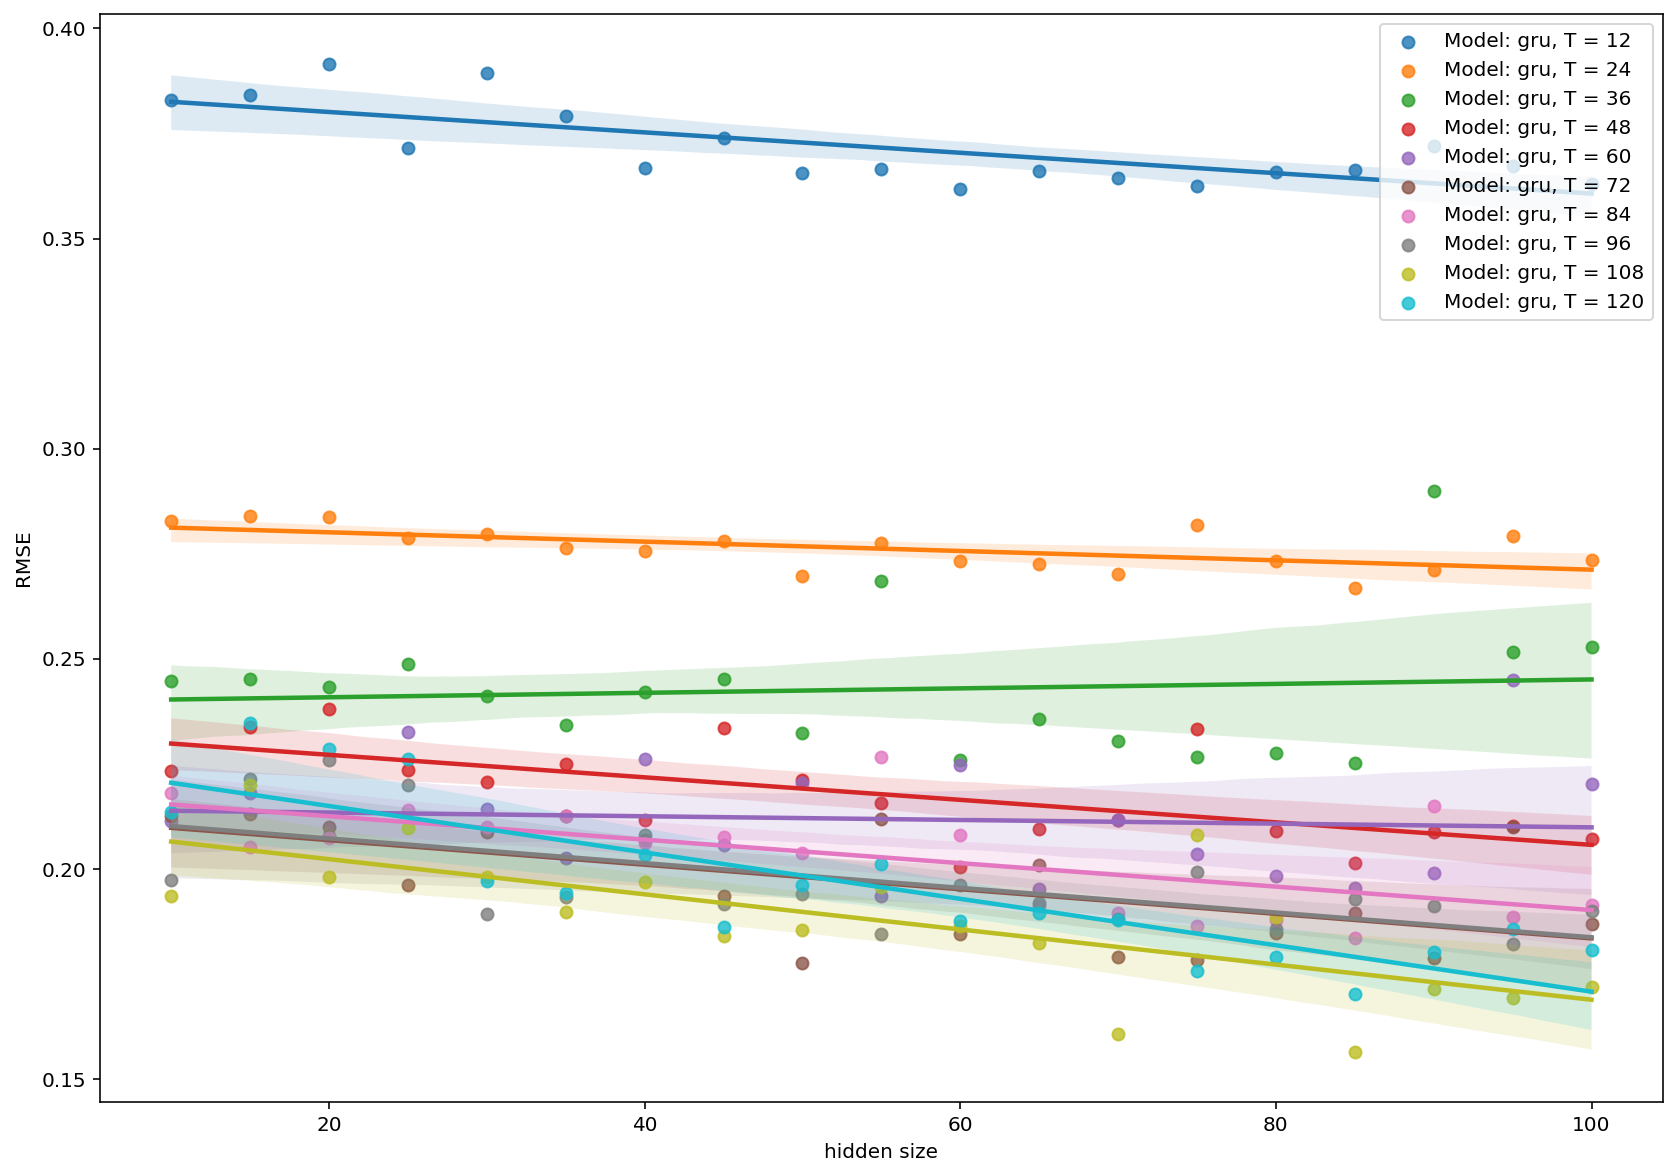

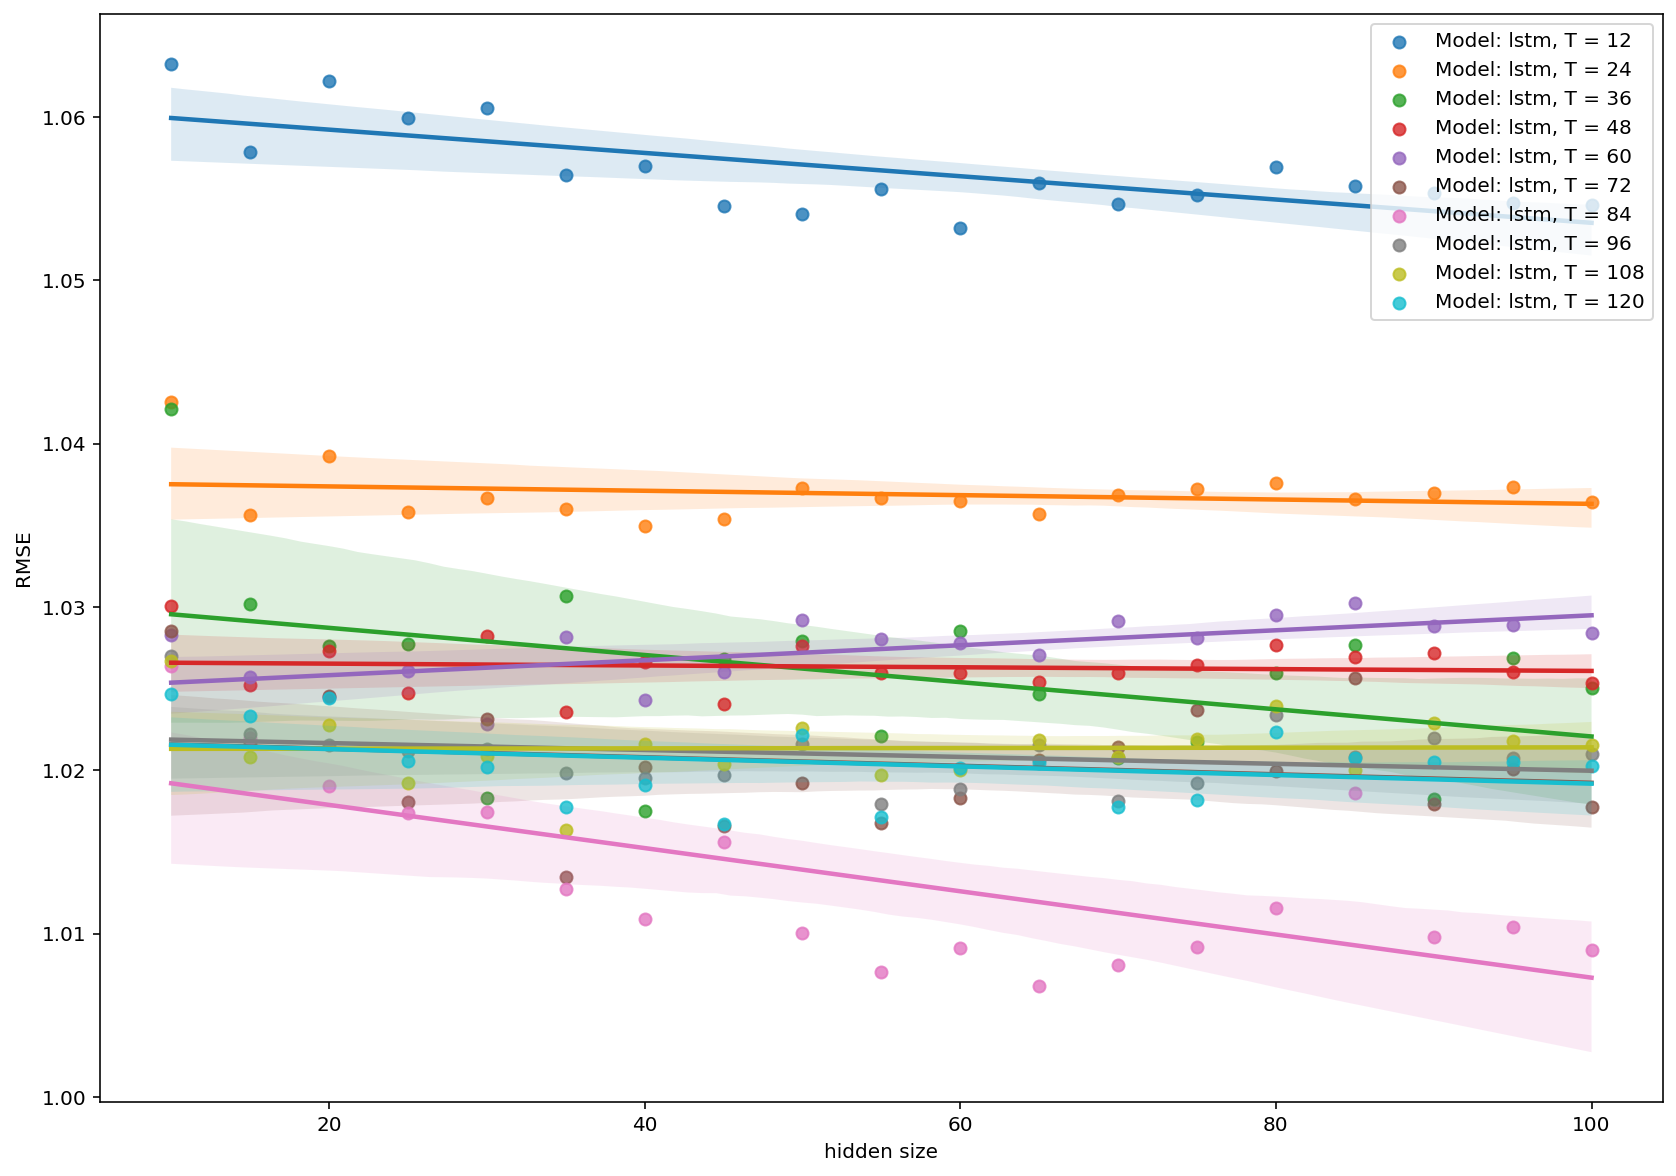

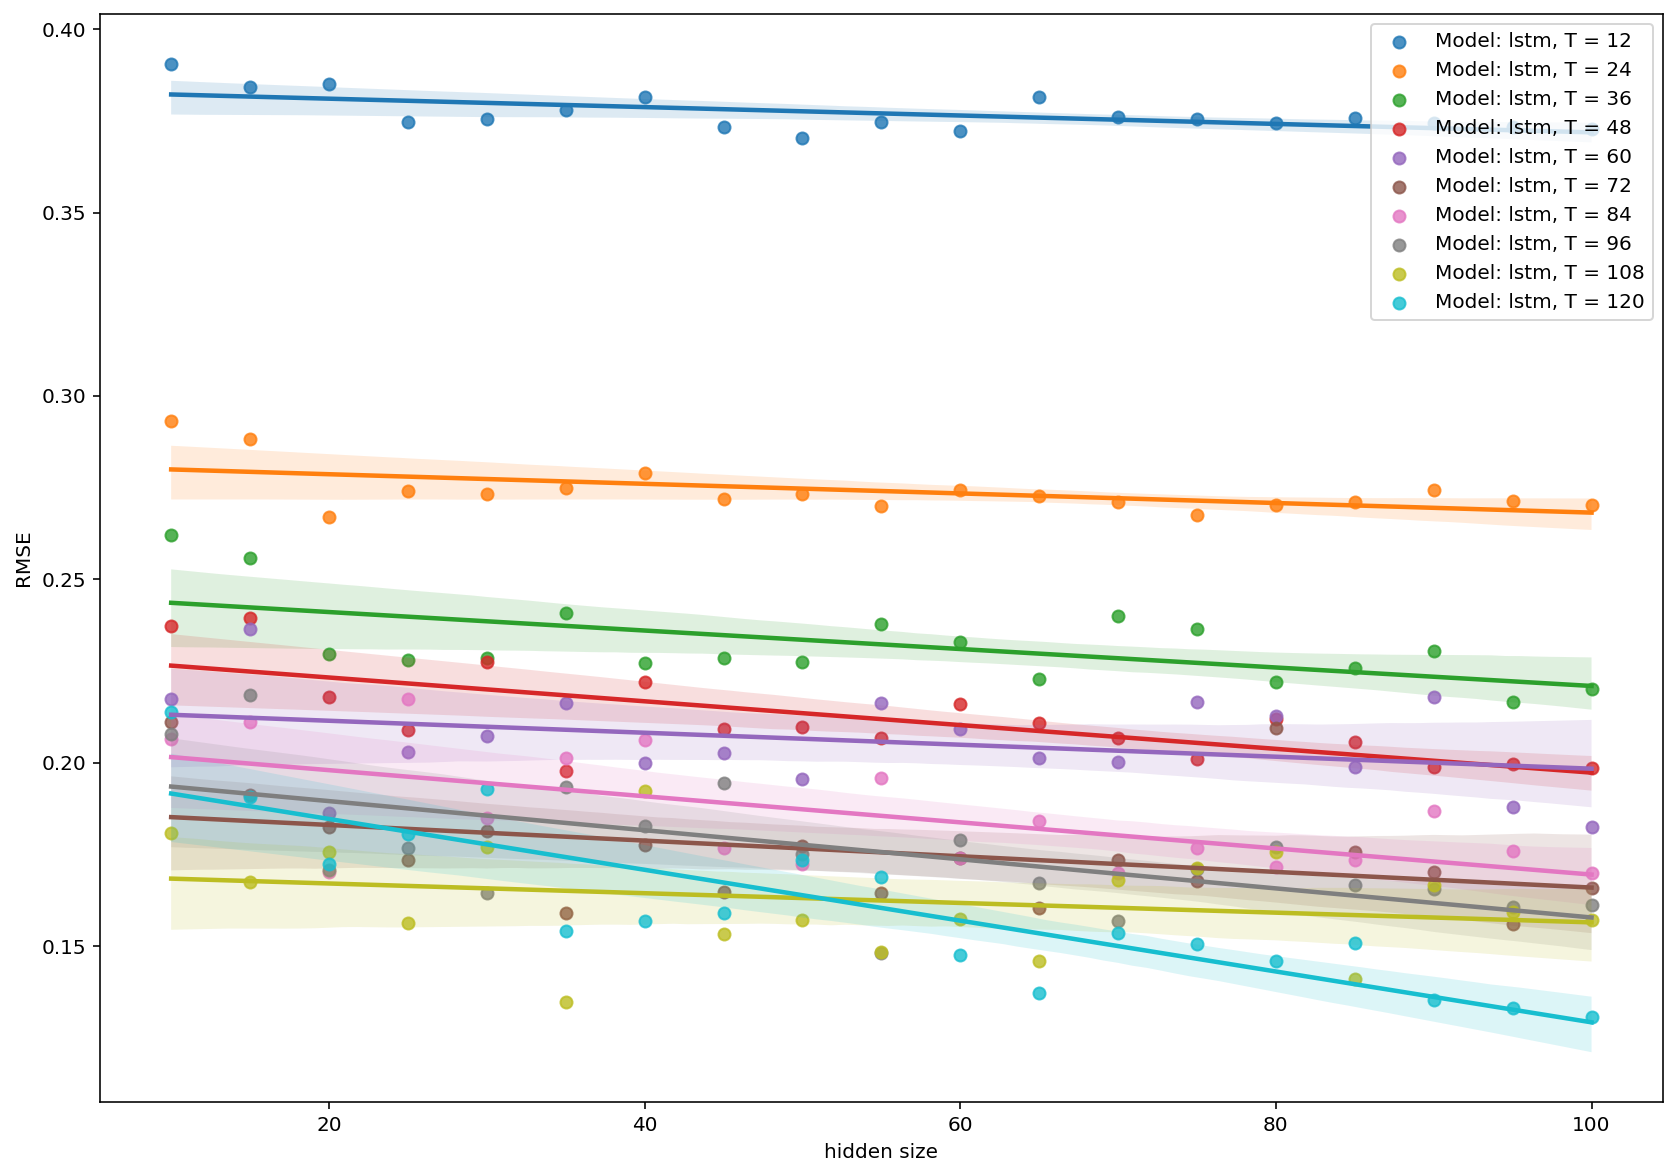

In [ ]:
##===================================
##    PLOT ALL REGRESSION GRAPHS
##===================================

folder = 'sine'
names = ['ann','rnn','gru','lstm']
seq_lens = list(range(12, 121, 12))

x_axis = list(range(10, 101, 5))

for name in names:
  lSeries = []
  lSignal = []

  fig, ax = plt.subplots()
  for sl in seq_lens:
    
    plot_data = np.loadtxt(f'drive/MyDrive/SSA/{folder}/{sl}/{name}_series.txt')
    sns.regplot(x="hidden size", y="RMSE", data=pd.DataFrame(np.array([x_axis, plot_data]).T, columns=['hidden size','RMSE']), ax = ax, label = f"Model: {name}, T = {sl}");
    ax.legend(loc = 1)
  

  fig, ax = plt.subplots()
  for sl in seq_lens:
    plot_data = np.loadtxt(f'drive/MyDrive/SSA/{folder}/{sl}/{name}_signal.txt')
    sns.regplot(x="hidden size", y="RMSE", data=pd.DataFrame(np.array([x_axis, plot_data]).T, columns=['hidden size','RMSE']), ax = ax, label = f"Model: {name}, T = {sl}");
    ax.legend(loc = 1)

NameError: ignored

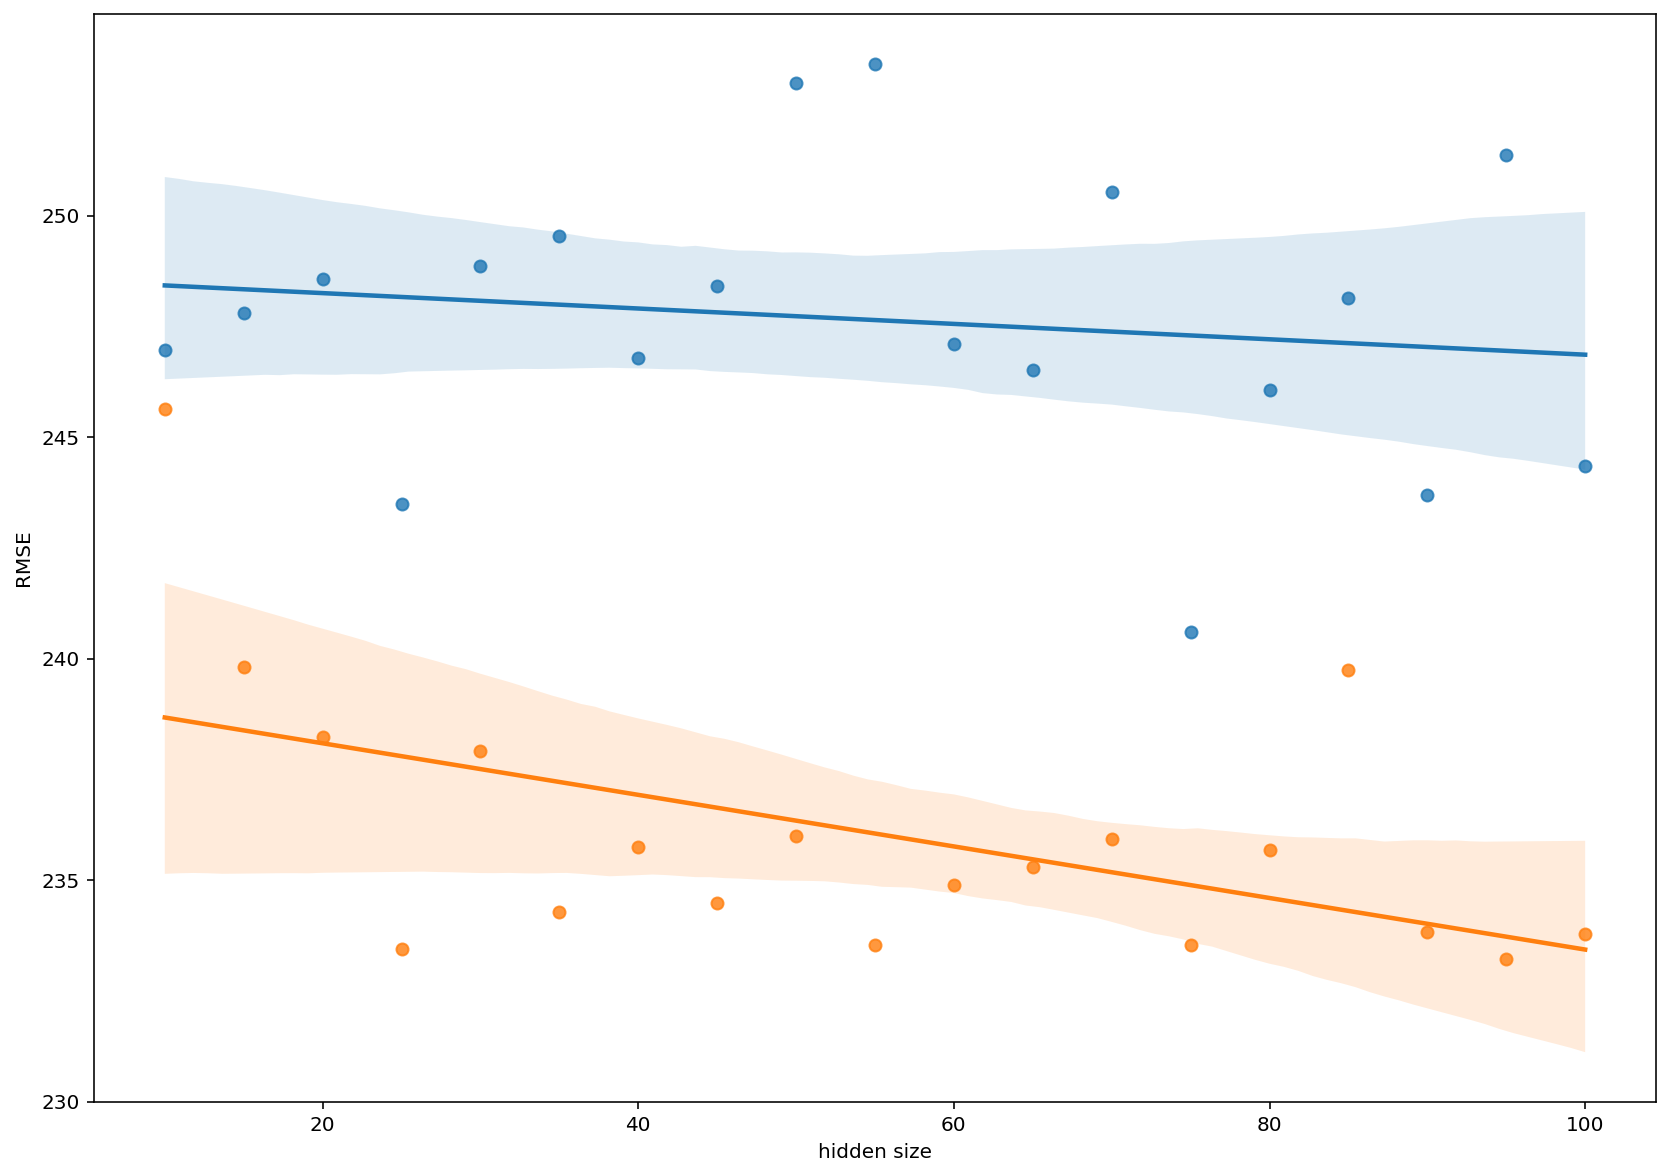

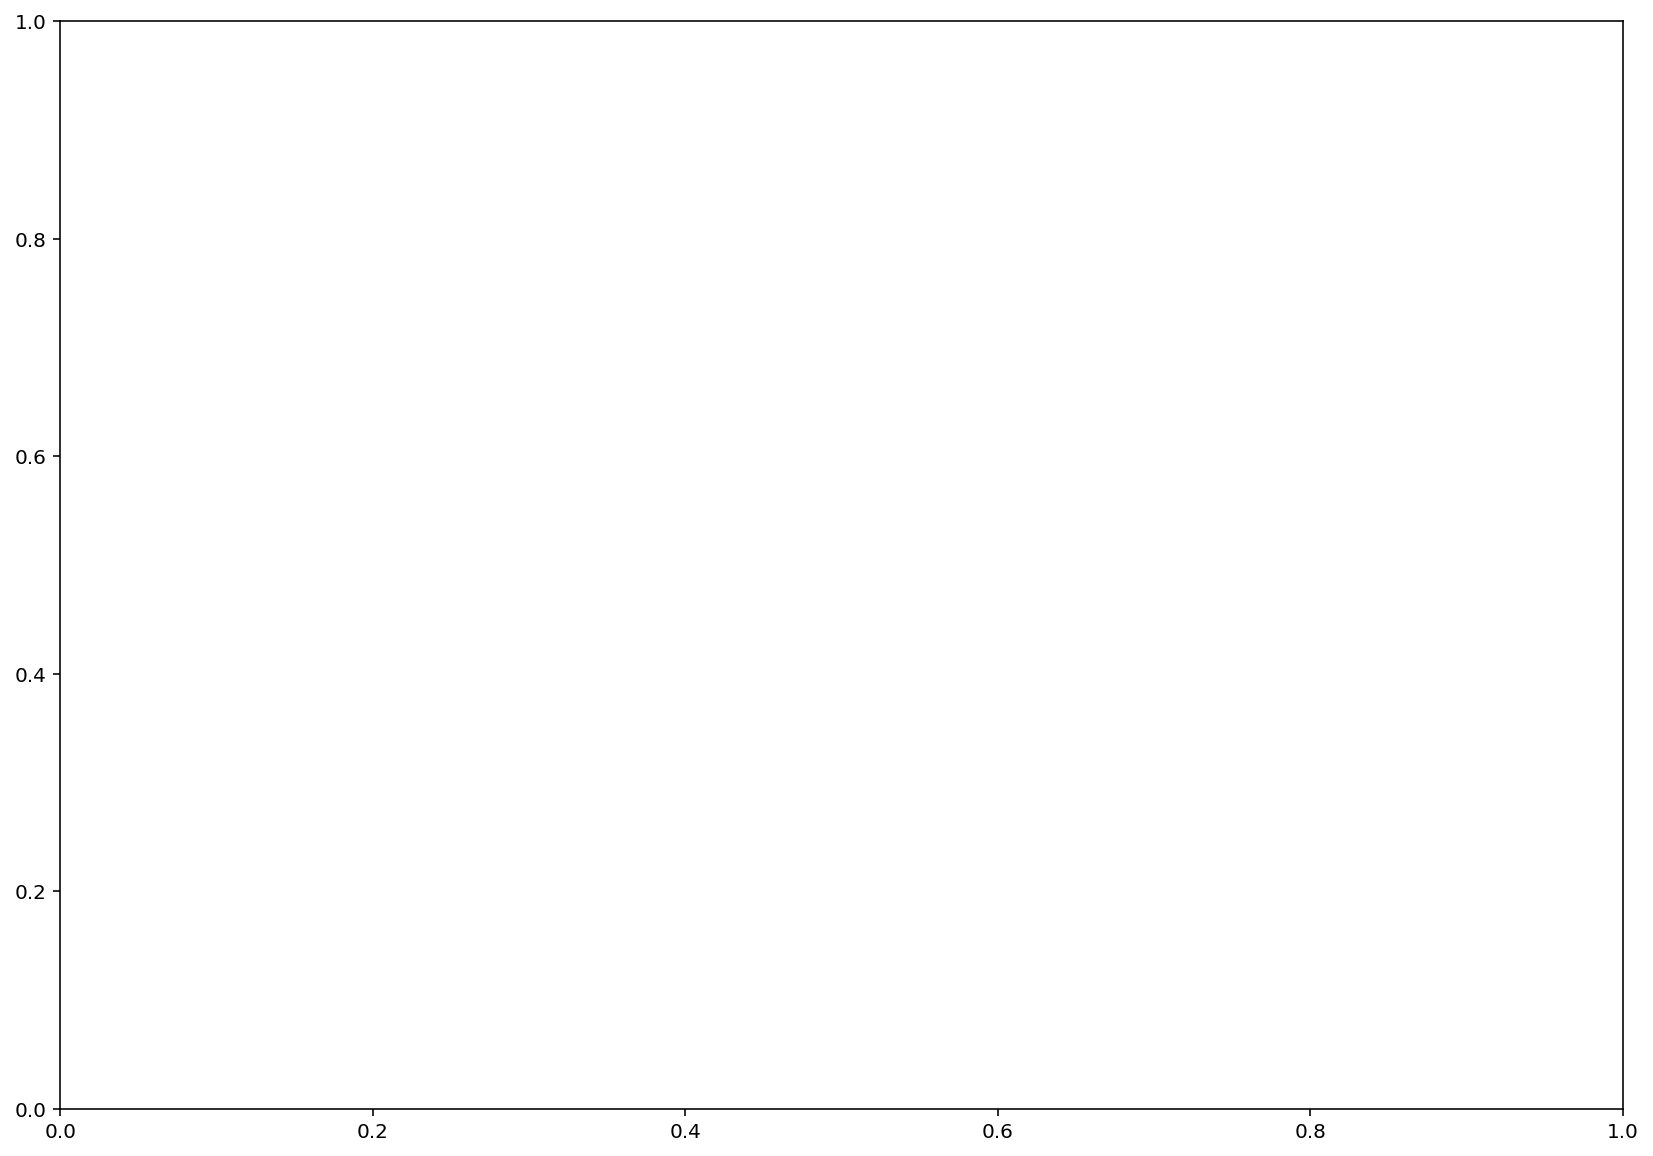

In [ ]:
folder = 'indian_rain'

name = 'gru'

x_axis = list(range(10, 101, 5))

l11 = np.loadtxt(f'drive/MyDrive/SSA/{folder}/12/{name}_series.txt')
l12 = np.loadtxt(f'drive/MyDrive/SSA/{folder}/24/{name}_series.txt')
#l21 = np.loadtxt(f'drive/MyDrive/SSA/{folder}/13/{name}_signal.txt')
#l22 = np.loadtxt(f'drive/MyDrive/SSA/{folder}/26/{name}_signal.txt')

fig, ax = plt.subplots()

sns.regplot(x="hidden size", y="RMSE", 
           data=pd.DataFrame(np.array([x_axis, l11]).T, columns=['hidden size','RMSE'])
           , ax = ax);
sns.regplot(x="hidden size", y="RMSE", 
           data=pd.DataFrame(np.array([x_axis, l12]).T, columns=['hidden size','RMSE'])
          , ax = ax);


fig, ax = plt.subplots()

sns.regplot(x="hidden size", y="RMSE", 
           data=pd.DataFrame(np.array([x_axis, l21]).T, columns=['hidden size','RMSE'])
           , ax = ax);
sns.regplot(x="hidden size", y="RMSE", 
           data=pd.DataFrame(np.array([x_axis, l22]).T, columns=['hidden size','RMSE'])
          , ax = ax);

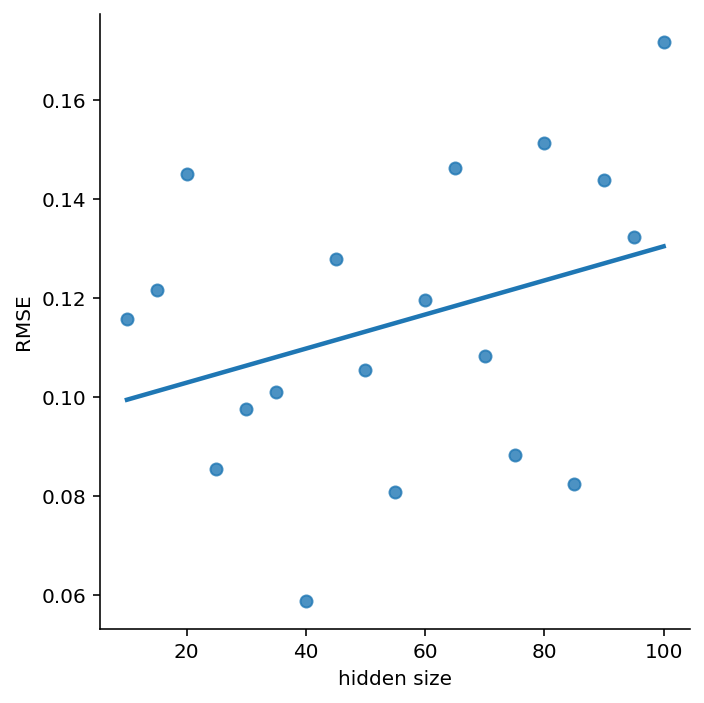

In [ ]:
sns.lmplot(x="hidden size", y="RMSE", data=pd.DataFrame(np.array([list(range(10, 101, 5)), lANN]).T, columns=['hidden size','RMSE']), ci=None);

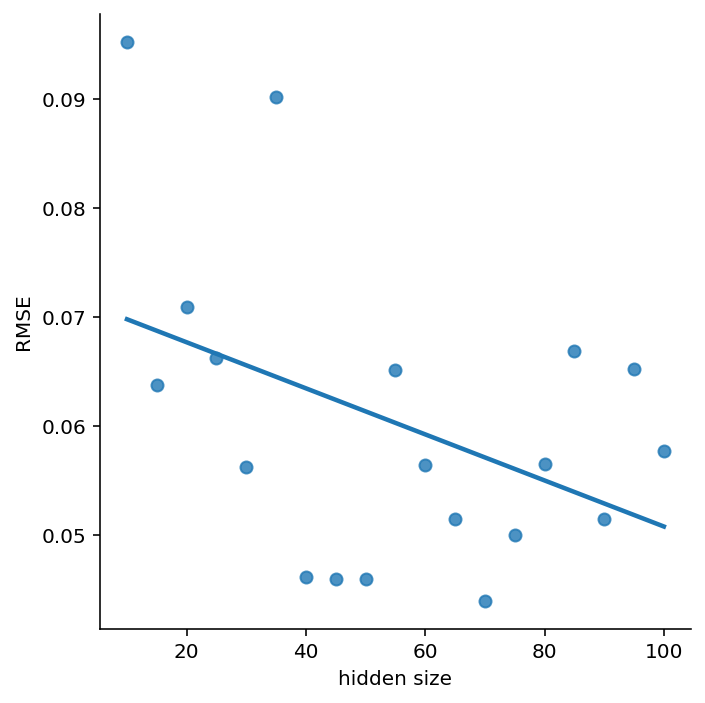

In [ ]:
sns.lmplot(x="hidden size", y="RMSE", data=pd.DataFrame(np.array([list(range(10, 101, 5)), lRNN]).T, columns=['hidden size','RMSE']), ci=None);

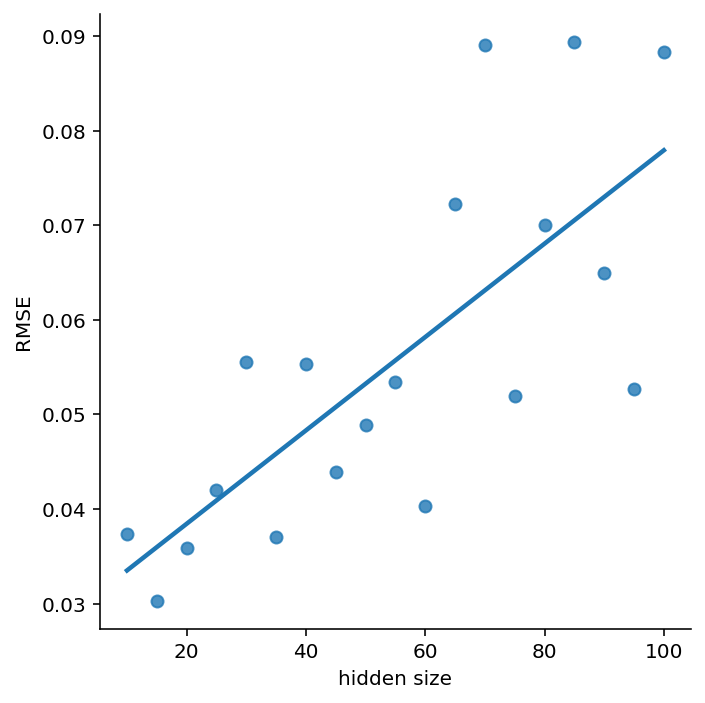

In [ ]:
sns.lmplot(x="hidden size", y="RMSE", data=pd.DataFrame(np.array([list(range(10, 101, 5)), lLSTM]).T, columns=['hidden size','RMSE']), ci=None);

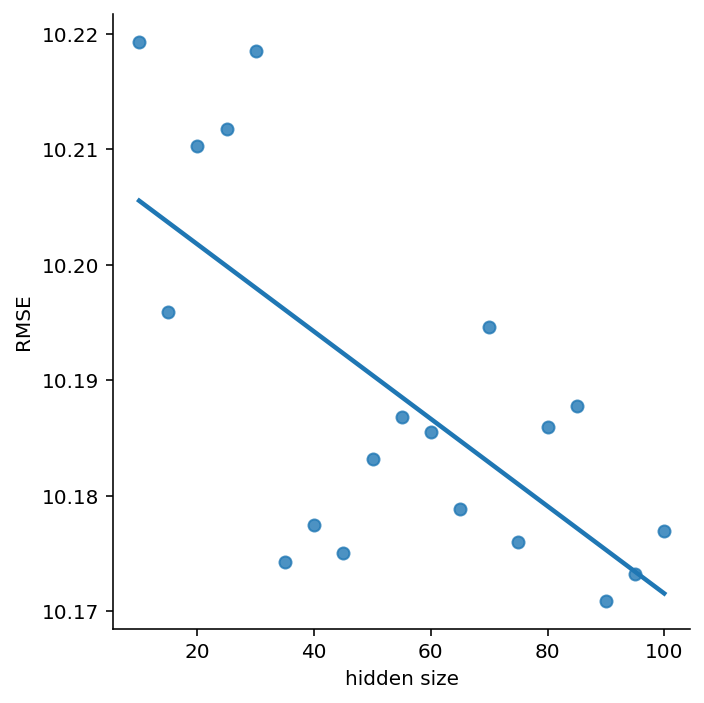

In [ ]:
sns.lmplot(x="hidden size", y="RMSE", data=pd.DataFrame(np.array([list(range(10, 101, 5)), lGRU]).T, columns=['hidden size','RMSE']), ci=None);

In [ ]:
res = np.zeros(len(list(range(10, 101, 5))))

for i in range(10):
  _, lANN = customGridSearch(list(range(10, 101, 5)), (data.train.X, data.train.y.reshape(-1, 1)), valid_ds, RANDOM_SEED = RANDOM_SEED + i)
  res += np.array(lRNN)

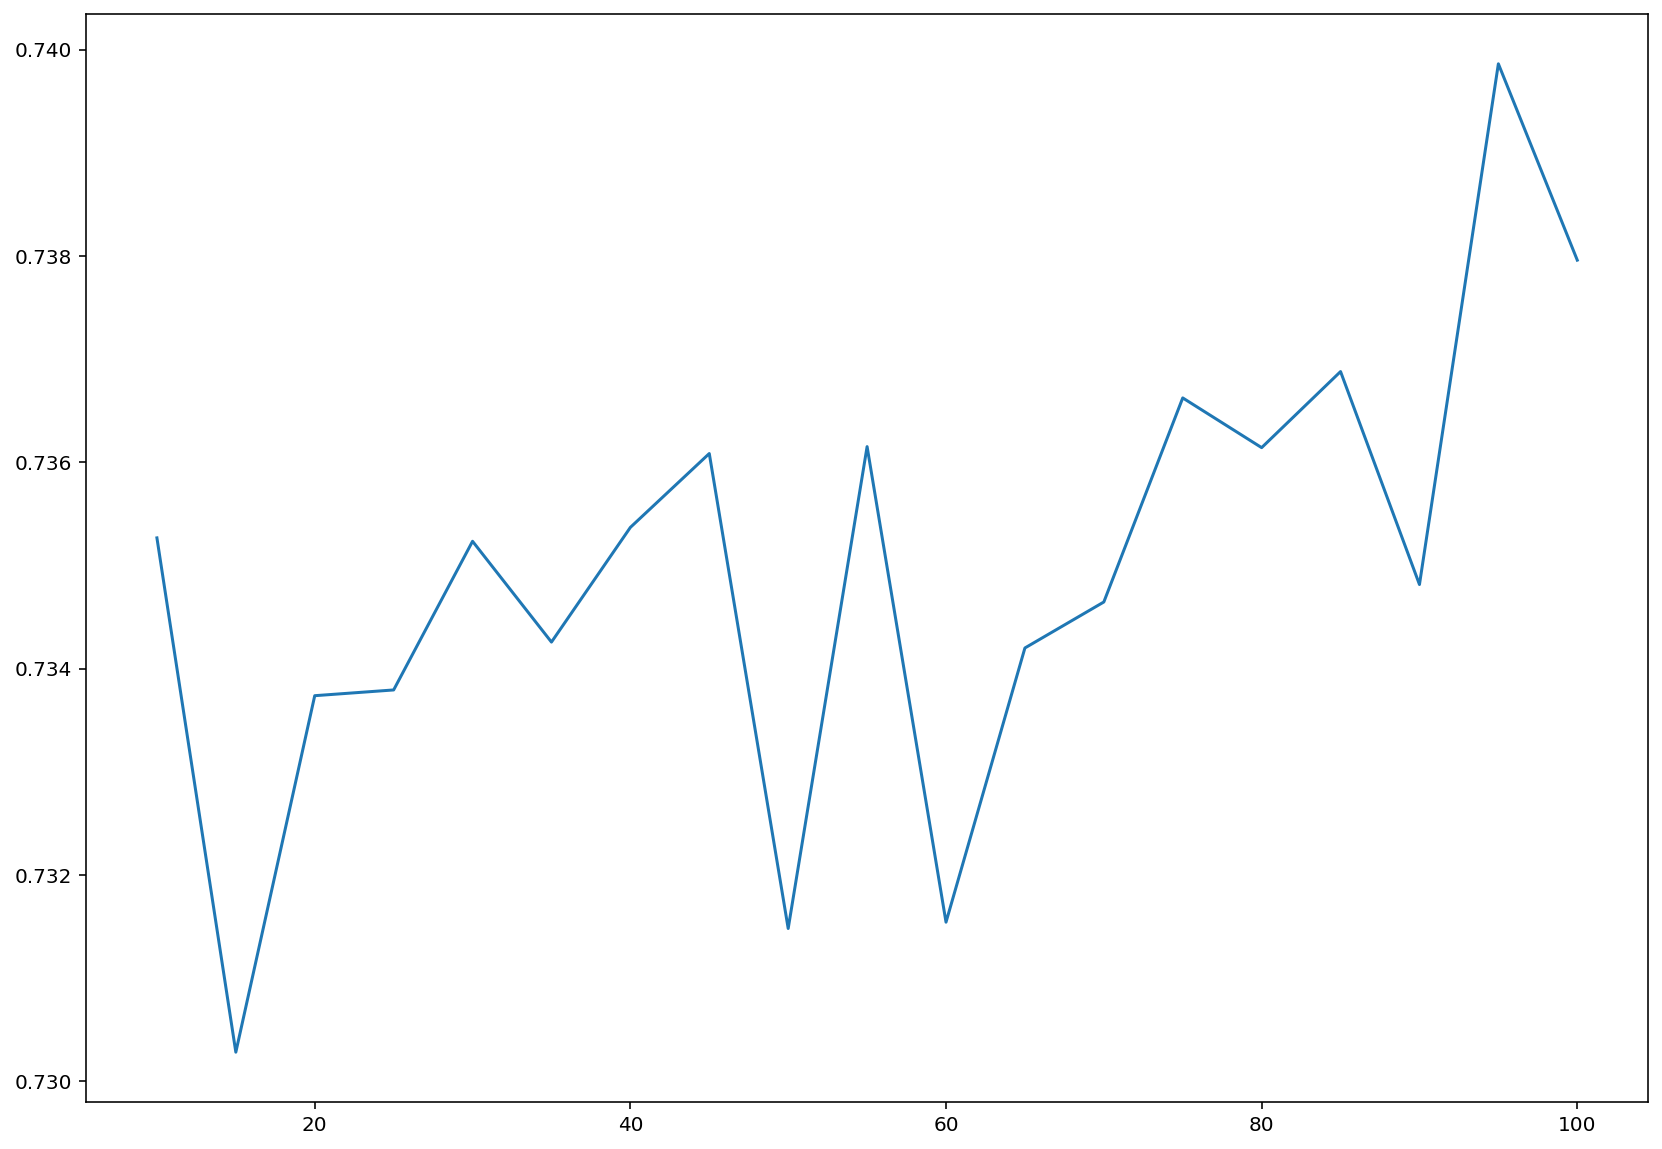

In [ ]:
plt.plot(list(range(10, 101, 5)), res / 10)

In [ ]:
_, lRNN = customGridSearch(list(range(10, 101, 5)), (data.train.X, data.train.y.reshape(-1, 1)), valid_ds, RANDOM_SEED = RANDOM_SEED)

Param:  10 ; Loss:  0.7530879378318787
Param:  15 ; Loss:  0.734074592590332
Param:  20 ; Loss:  0.745476245880127
Param:  25 ; Loss:  0.7492629885673523
Param:  30 ; Loss:  0.7505567073822021
Param:  35 ; Loss:  0.7414951920509338
Param:  40 ; Loss:  0.7702997326850891
Param:  45 ; Loss:  0.7545102834701538
Param:  50 ; Loss:  0.7598825693130493
Param:  55 ; Loss:  0.7432661056518555
Param:  60 ; Loss:  0.7363592982292175
Param:  65 ; Loss:  0.7478481531143188
Param:  70 ; Loss:  0.7500174641609192
Param:  75 ; Loss:  0.7534358501434326
Param:  80 ; Loss:  0.746361494064331
Param:  85 ; Loss:  0.7452532052993774
Param:  90 ; Loss:  0.758103609085083
Param:  95 ; Loss:  0.7615625858306885
Param:  100 ; Loss:  0.76808762550354


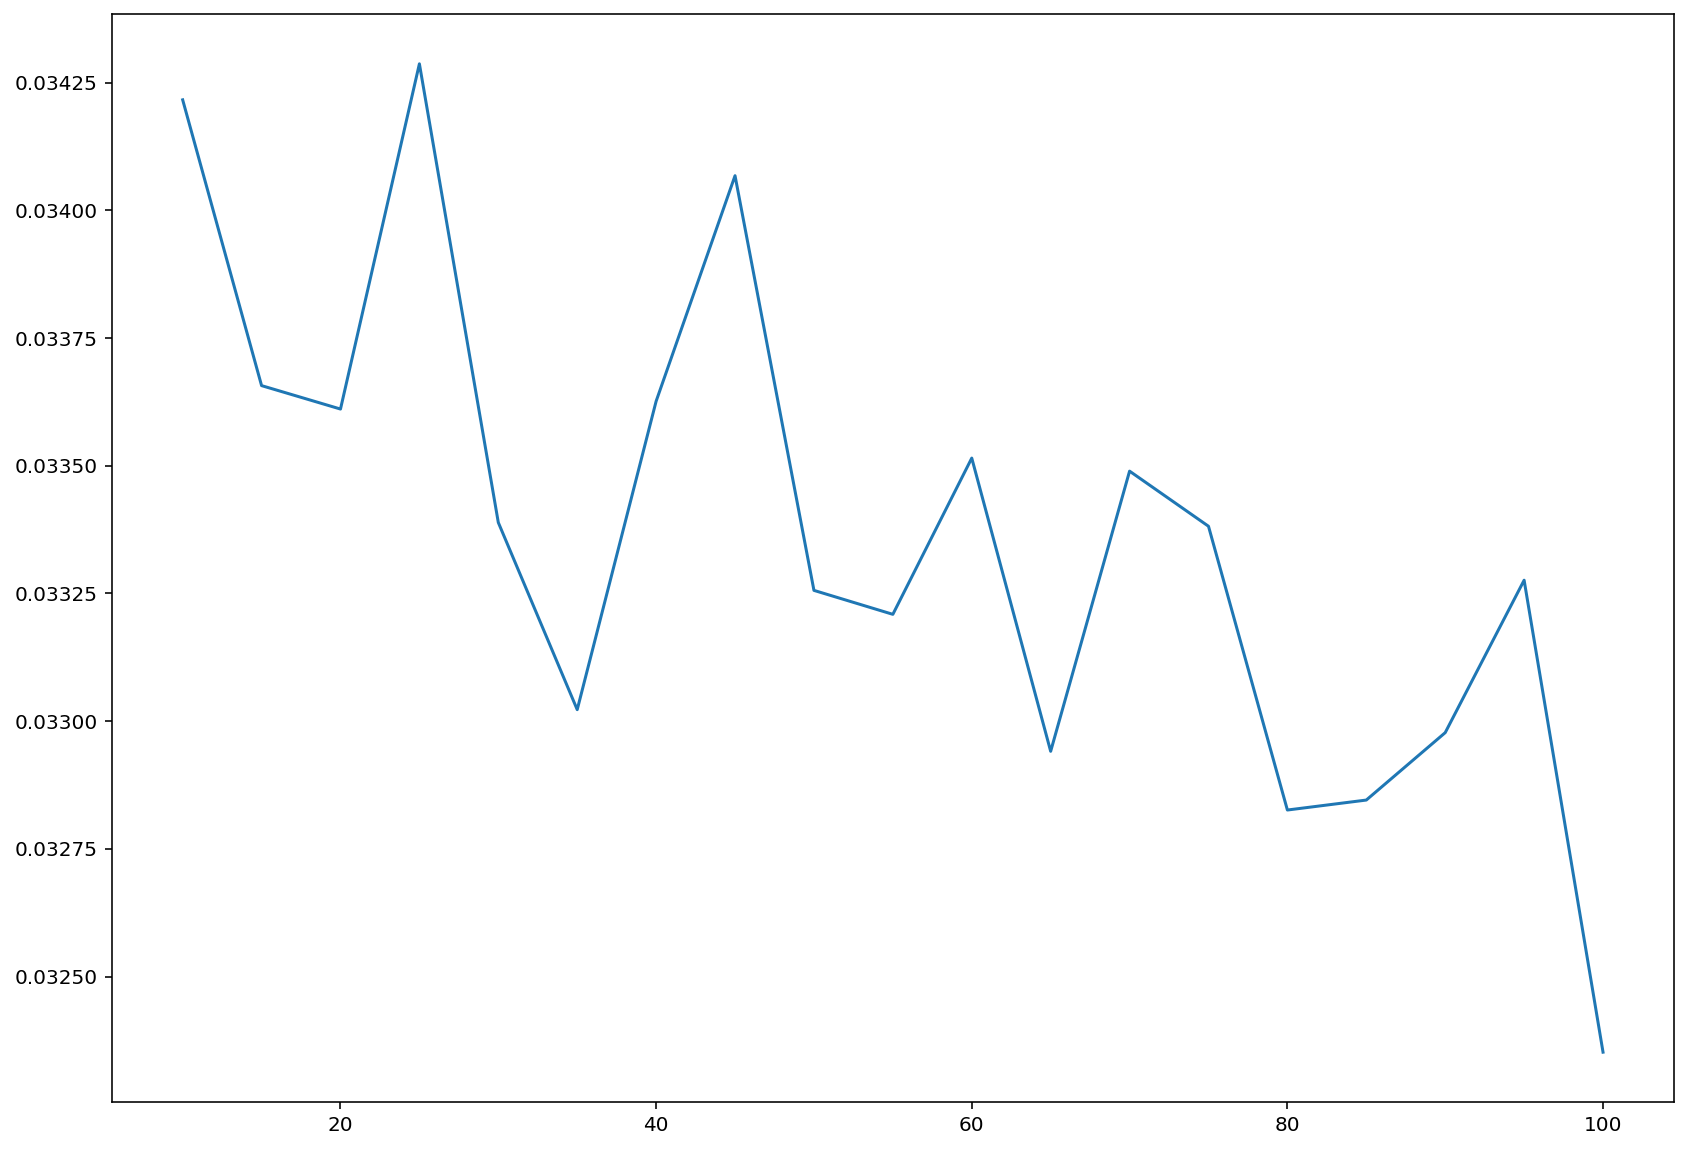

In [ ]:
plt.plot(list(range(10, 101, 5)), lANN)

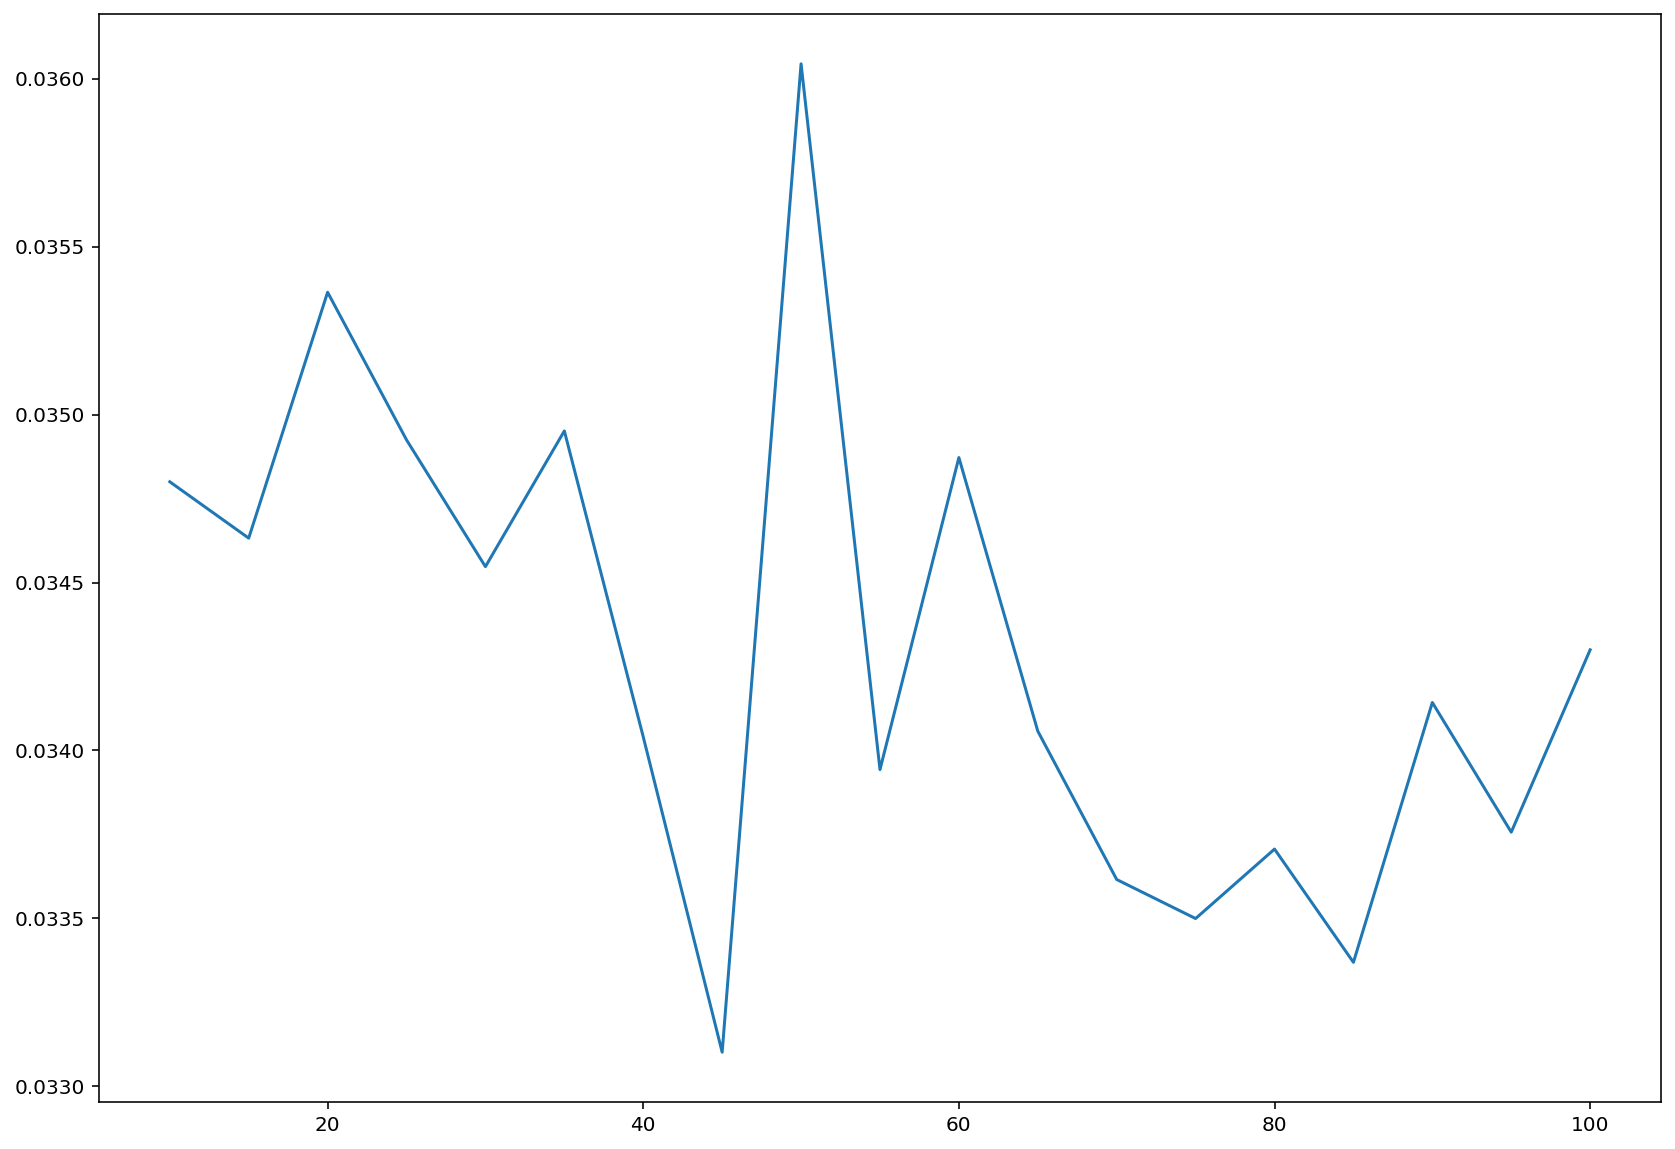

In [ ]:
plt.plot(list(range(10, 101, 5)), lRNN)

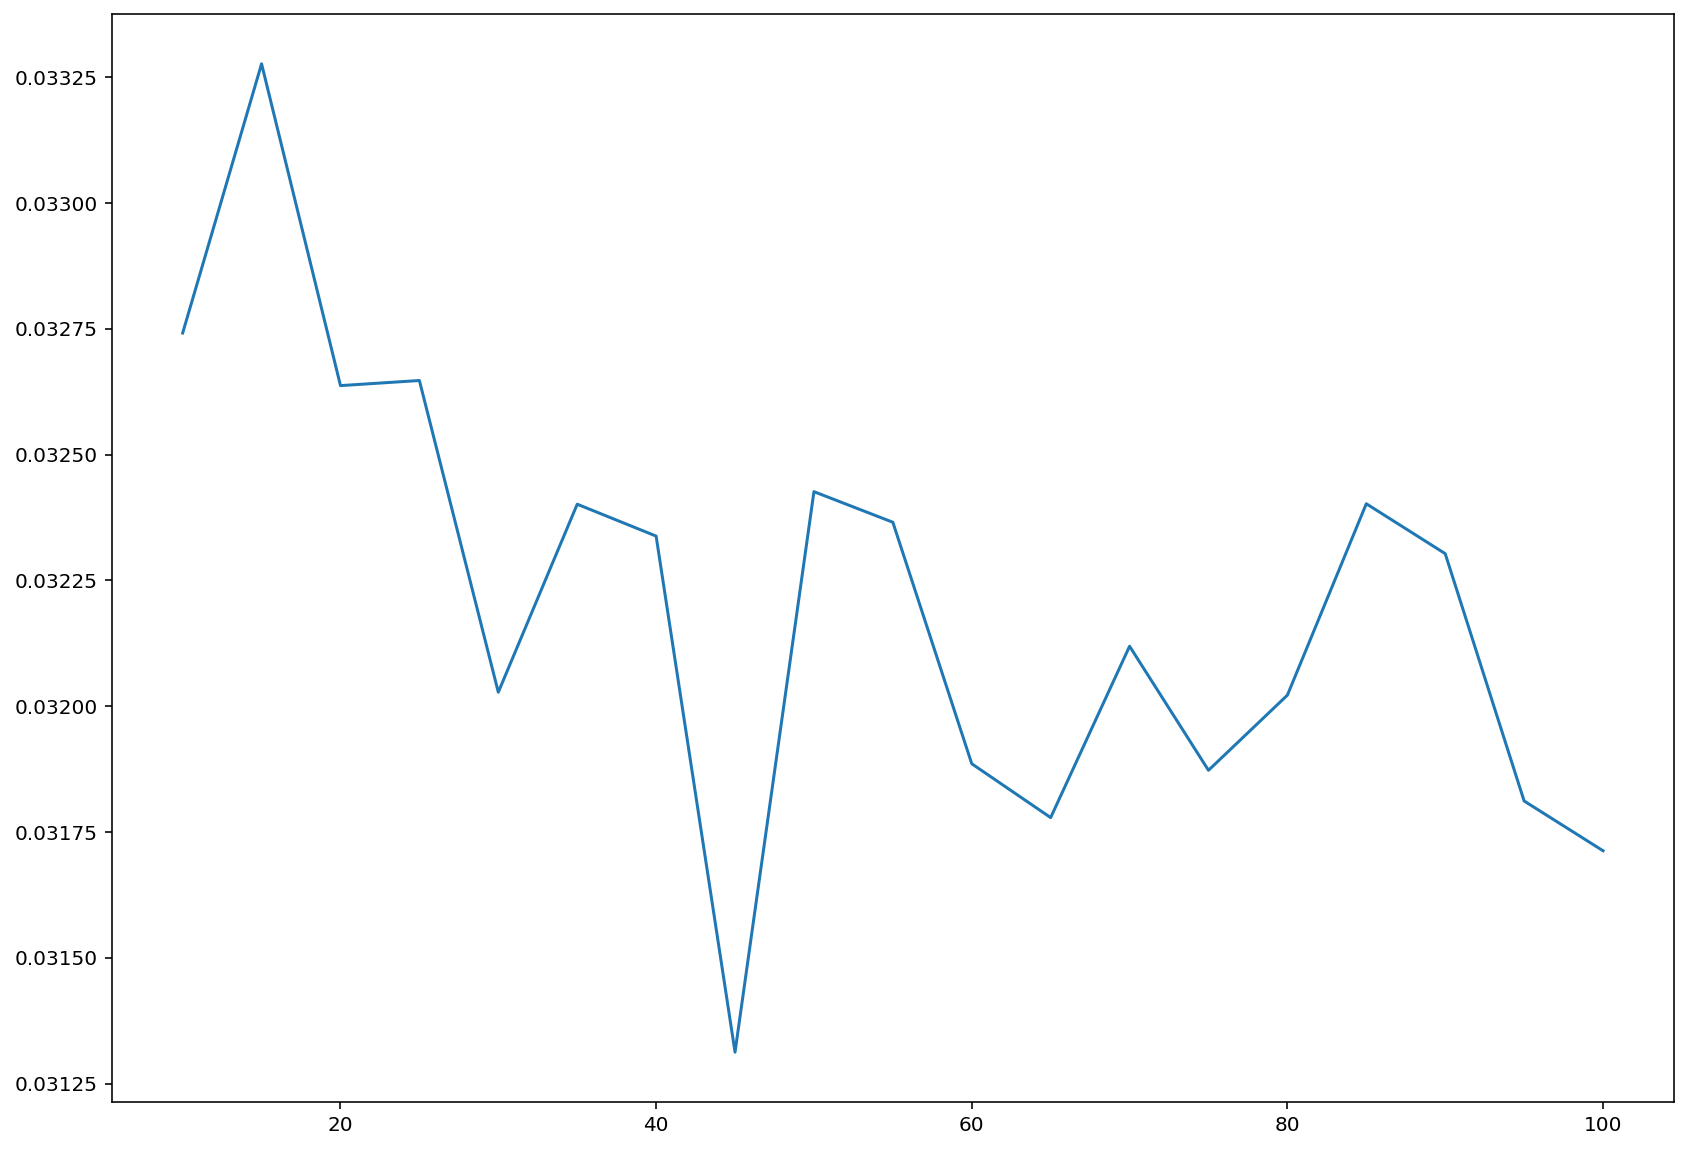

In [ ]:
plt.plot(list(range(10, 101, 5)), lGRU)

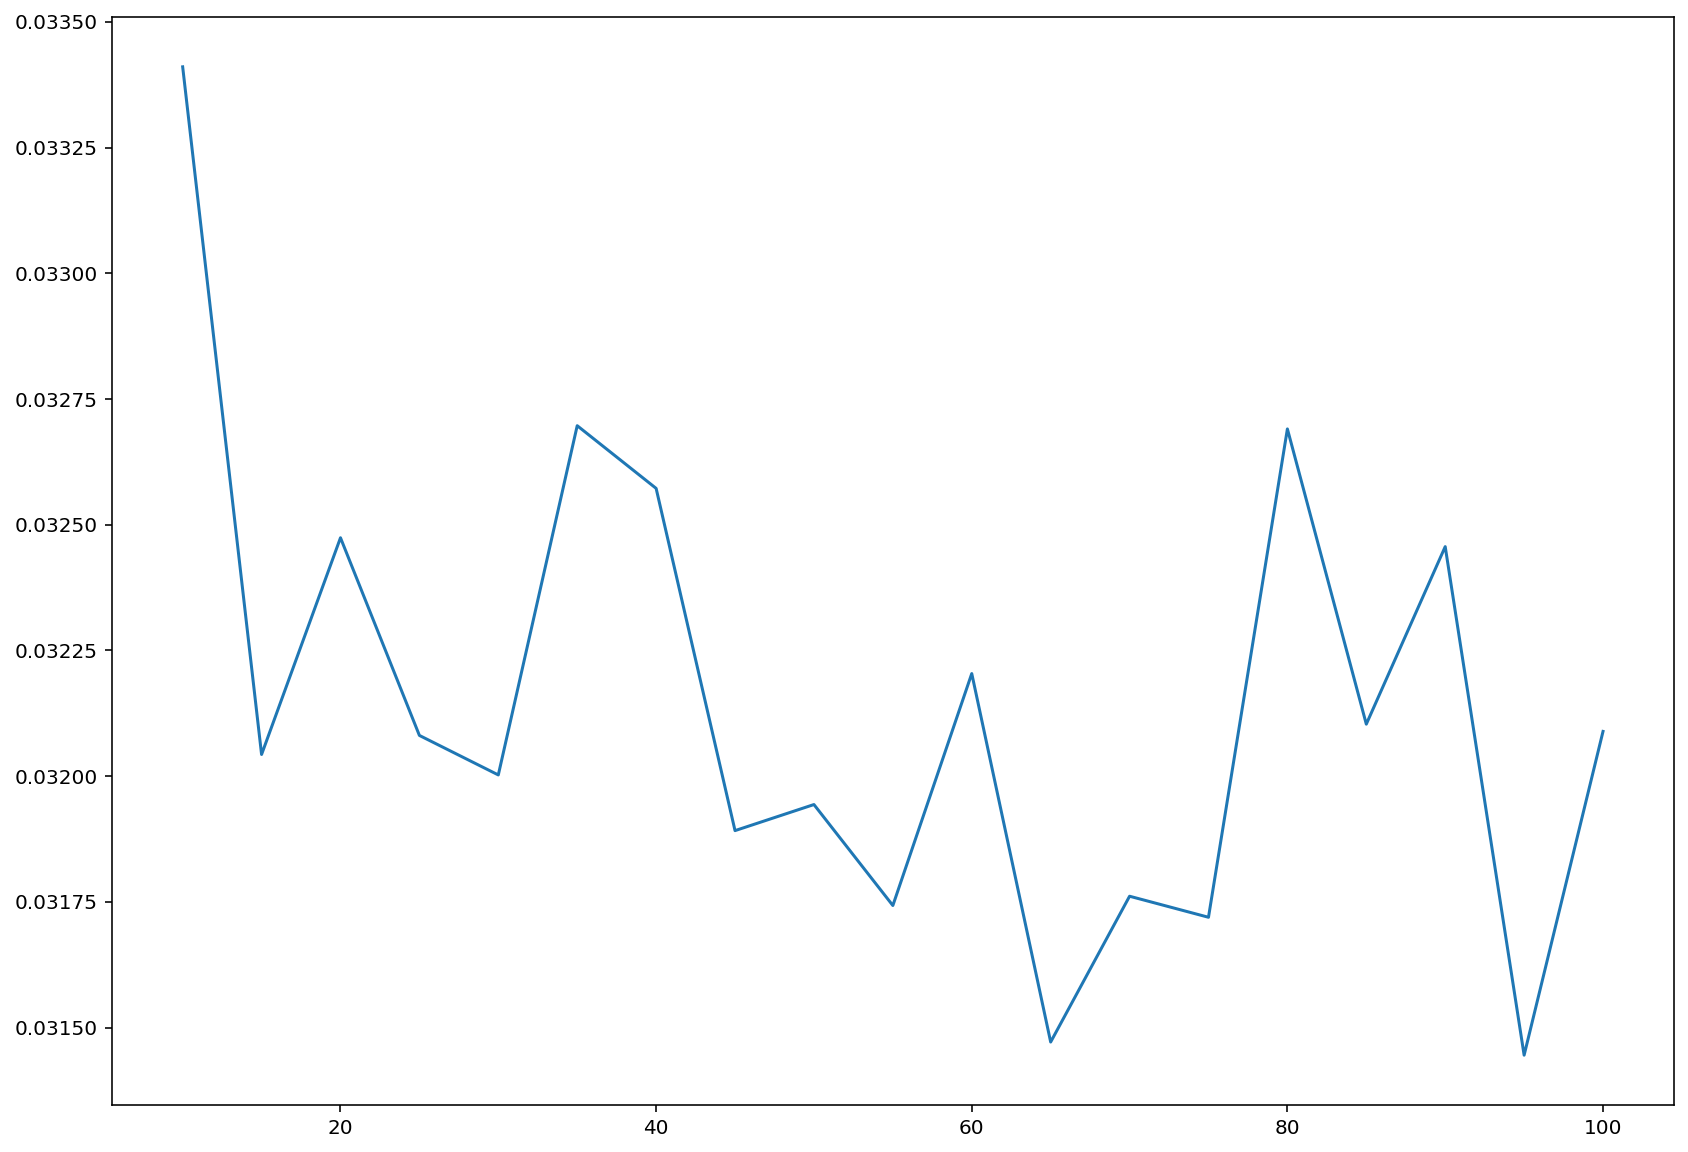

In [ ]:
plt.plot(list(range(10, 101, 5)), lLSTM)

# EOP

In [ ]:
data = pd.read_csv("drive/MyDrive/SSA/month_data.csv", sep = ";")
SIZE = len(data)
data.head()

Year  Month    x_pole    y_pole       LOD
0  1962      1 -0.044944  0.225739  0.001229
1  1962      2 -0.050477  0.244412  0.001359
2  1962      3  0.004930  0.258291  0.001503
3  1962      4  0.065315  0.234968  0.001664
4  1962      5  0.093417  0.198508  0.001639

## X_POLE

In [ ]:
#ts_x = np.array(data.x_pole)
ts_x = np.array(pd.read_csv("drive/MyDrive/SSA/x_no_trend.csv", sep = ",")['ts_x'])
TRAIN_SIZE, VAL_SIZE, TEST_SIZE = 500, 109, 108;
seq_len = 36;

assert TRAIN_SIZE + VAL_SIZE + TEST_SIZE == SIZE, "wrong TRAIN and VAL sizes"

ssa_xpole = edict({
    'L' : TRAIN_SIZE//2,
    'ssa_groups' : list(range(1,29)),
    'rssa' : rssa
})

data_xpole = splitData(ts_x, seq_len, TRAIN_SIZE, VAL_SIZE, TEST_SIZE, ssa_xpole, val_ssa = True)

100%|██████████| 108/108 [00:24<00:00,  4.39it/s]


### SKORCH

In [ ]:
train_ds = Dataset(data_xpole.train.X, data_xpole.train.y.reshape(-1, 1))

valid_ds = Dataset(data_xpole.val.X, data_xpole.val.y.reshape(-1, 1))
valid_ds_ssa = Dataset(data_xpole.val.X_ssa, data_xpole.val.y.reshape(-1, 1))

### Fully Connected

In [ ]:
fcnet = NeuralNetRegressor(  FCModel
                         , module__inputSize=seq_len
                         , module__hiddenLayer=50
                         , module__outputSize=1
                           
                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience = 50)
                         ]
                         , train_split= predefined_split(valid_ds)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

fcnet_ssa = NeuralNetRegressor(  FCModel
                         , module__inputSize=seq_len
                         , module__hiddenLayer=50
                         , module__outputSize=1       
                        
                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds_ssa)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

In [ ]:
torch.manual_seed(RANDOM_SEED)
fcnet.fit(data_xpole.train.X, data_xpole.train.y.reshape(-1, 1));
fcnet.history[-1]

{'batches': [{'train_batch_size': 464, 'train_loss': 0.0023811813443899155},
  {'valid_batch_size': 73, 'valid_loss': 0.006959104910492897}],
 'dur': 0.007598400115966797,
 'epoch': 1826,
 'train_batch_count': 1,
 'train_loss': 0.0023811813443899155,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.006959104910492897,
 'valid_loss_best': False}

In [ ]:
torch.manual_seed(RANDOM_SEED)
fcnet_ssa.fit(data_xpole.train.X_ssa, data_xpole.train.y.reshape(-1, 1));
fcnet_ssa.history[-1]

{'batches': [{'train_batch_size': 464, 'train_loss': 0.0031900678295642138},
  {'valid_batch_size': 73, 'valid_loss': 0.014727236703038216}],
 'dur': 0.0075566768646240234,
 'epoch': 1887,
 'train_batch_count': 1,
 'train_loss': 0.0031900678295642138,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.014727236703038216,
 'valid_loss_best': False}

### RNN

In [ ]:
rnnnet = NeuralNetRegressor(  RNN
                         , module__input_size = 1
                         , module__hidden_size = 12
                         , module__output_size=1
                         #, module__device = device


                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

rnnnet_ssa = NeuralNetRegressor(  RNN
                         , module__input_size = 1
                         , module__hidden_size = 12
                         , module__output_size=1
                         #, module__device = device


                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

In [ ]:
torch.manual_seed(RANDOM_SEED)
rnnnet.fit(data_xpole.train.X, data_xpole.train.y.reshape(-1, 1));
rnnnet.history[-1]

{'batches': [{'train_batch_size': 464, 'train_loss': 0.008627615869045258},
  {'valid_batch_size': 73, 'valid_loss': 0.008275371976196766}],
 'dur': 0.01407313346862793,
 'epoch': 765,
 'train_batch_count': 1,
 'train_loss': 0.008627615869045258,
 'train_loss_best': False,
 'valid_batch_count': 1,
 'valid_loss': 0.008275371976196766,
 'valid_loss_best': False}

In [ ]:
torch.manual_seed(RANDOM_SEED)
rnnnet_ssa.fit(data_xpole.train.X_ssa, data_xpole.train.y.reshape(-1, 1));
rnnnet_ssa.history[-1]

{'batches': [{'train_batch_size': 464, 'train_loss': 0.009011260233819485},
  {'valid_batch_size': 73, 'valid_loss': 0.01796112395823002}],
 'dur': 0.013368606567382812,
 'epoch': 470,
 'train_batch_count': 1,
 'train_loss': 0.009011260233819485,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.01796112395823002,
 'valid_loss_best': False}

### GRU

In [ ]:
grunet = NeuralNetRegressor(  GRU
                         , module__input_size = 1
                         , module__hidden_size = 12
                         , module__output_size=1
                         #, module__device = device


                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

grunet_ssa = NeuralNetRegressor(  GRU
                         , module__input_size = 1
                         , module__hidden_size = 12
                         , module__output_size=1
                         #, module__device = device


                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

In [ ]:
torch.manual_seed(RANDOM_SEED)
grunet.fit(data_xpole.train.X, data_xpole.train.y.reshape(-1, 1));
grunet.history[-1]

{'batches': [{'train_batch_size': 464, 'train_loss': 0.004549730569124222},
  {'valid_batch_size': 73, 'valid_loss': 0.007796714548021555}],
 'dur': 0.015597820281982422,
 'epoch': 2383,
 'train_batch_count': 1,
 'train_loss': 0.004549730569124222,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.007796714548021555,
 'valid_loss_best': False}

In [ ]:
torch.manual_seed(RANDOM_SEED)
grunet_ssa.fit(data_xpole.train.X_ssa, data_xpole.train.y.reshape(-1, 1));
grunet_ssa.history[-1]

{'batches': [{'train_batch_size': 464, 'train_loss': 0.00944311823695898},
  {'valid_batch_size': 73, 'valid_loss': 0.021529581397771835}],
 'dur': 0.015157222747802734,
 'epoch': 1055,
 'train_batch_count': 1,
 'train_loss': 0.00944311823695898,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.021529581397771835,
 'valid_loss_best': False}

### LSTM

In [ ]:
lstmnet = NeuralNetRegressor(  LSTM
                         , module__input_size = 1
                         , module__hidden_size = 12
                         , module__output_size=1
                         #, module__device = device


                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

lstmnet_ssa = NeuralNetRegressor(  LSTM
                         , module__input_size = 1
                         , module__hidden_size = 12
                         , module__output_size=1
                        # , module__device = device


                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds_ssa)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

In [ ]:
torch.manual_seed(RANDOM_SEED)
lstmnet.fit(data_xpole.train.X, data_xpole.train.y.reshape(-1, 1));
lstmnet.history[-1]

{'batches': [{'train_batch_size': 464, 'train_loss': 0.01837810128927231},
  {'valid_batch_size': 73, 'valid_loss': 0.038312528282403946}],
 'dur': 0.01492929458618164,
 'epoch': 389,
 'train_batch_count': 1,
 'train_loss': 0.01837810128927231,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.038312528282403946,
 'valid_loss_best': False}

In [ ]:
torch.manual_seed(RANDOM_SEED)
lstmnet_ssa.fit(data_xpole.train.X_ssa, data_xpole.train.y.reshape(-1, 1));
lstmnet_ssa.history[-1]

{'batches': [{'train_batch_size': 464, 'train_loss': 0.024569742381572723},
  {'valid_batch_size': 73, 'valid_loss': 0.061708539724349976}],
 'dur': 0.014352083206176758,
 'epoch': 355,
 'train_batch_count': 1,
 'train_loss': 0.024569742381572723,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.061708539724349976,
 'valid_loss_best': False}

### Results

In [ ]:
pc_ann =  getPredCases(fcnet.module_.to('cpu'), data_xpole, tomorrow = True, y_ssa=False, ssa = None)
pc_ssa_ann =  getPredCases(fcnet_ssa.module_.to('cpu'), data_xpole, tomorrow = True, y_ssa=False, ssa = ssa_xpole)
#====================
pc_rnn =  getPredCases(rnnnet.module_.to('cpu'), data_xpole, tomorrow = True, y_ssa=False, ssa = None)
pc_ssa_rnn =  getPredCases(rnnnet_ssa.module_.to('cpu'), data_xpole, tomorrow = True, y_ssa=False, ssa = ssa_xpole)
#====================
pc_gru =  getPredCases(grunet.module_.to('cpu'), data_xpole, tomorrow = True, y_ssa=False, ssa = None)
pc_ssa_gru =  getPredCases(grunet_ssa.module_.to('cpu'), data_xpole, tomorrow = True, y_ssa=False, ssa = ssa_xpole)
#====================
pc_lstm =  getPredCases(lstmnet.module_.to('cpu'), data_xpole, tomorrow = True, y_ssa=False, ssa = None)
pc_ssa_lstm =  getPredCases(lstmnet_ssa.module_.to('cpu'), data_xpole, tomorrow = True, y_ssa=False, ssa = ssa_xpole)

100%|██████████| 108/108 [00:00<00:00, 387.65it/s]


In [ ]:
errs = {'ANN' : getRMSE(ts_x[-TEST_SIZE:], pc_ann)
        , 'SSA-ANN' : getRMSE(ts_x[-TEST_SIZE:], pc_ssa_ann)
        , 'RNN' : getRMSE(ts_x[-TEST_SIZE:], pc_rnn)
        , 'SSA-RNN' : getRMSE(ts_x[-TEST_SIZE:], pc_ssa_rnn)
        , 'GRU' : getRMSE(ts_x[-TEST_SIZE:], pc_gru)
        , 'SSA-GRU' : getRMSE(ts_x[-TEST_SIZE:], pc_ssa_gru)
        , 'LSTM' : getRMSE(ts_x[-TEST_SIZE:], pc_lstm)
        , 'SSA-LSTM' : getRMSE(ts_x[-TEST_SIZE:], pc_ssa_lstm)
        }
pd.DataFrame().from_dict(errs, orient='index').T

ANN   SSA-ANN       RNN  ...   SSA-GRU      LSTM  SSA-LSTM
0  0.009796  0.021877  0.010755  ...  0.023937  0.026634   0.02664

[1 rows x 8 columns]

> r = 7
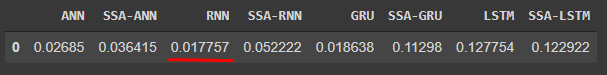

> r = 23 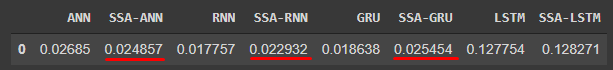

> r = 50 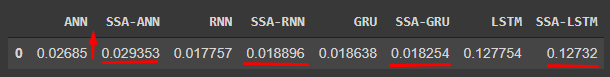



In [ ]:
getStat([pc_ann, pc_ssa_ann, pc_rnn, pc_ssa_rnn, pc_gru, pc_ssa_gru, pc_lstm, pc_ssa_lstm], ts_x[-TEST_SIZE:])

0             1  ...             6             7
0  0.000000e+00  9.984773e-13  ...  3.467227e-17  4.178209e-17
1  9.984773e-13  0.000000e+00  ...  2.166531e-13  1.539312e-14
2  2.244323e-13  1.502317e-11  ...  5.589319e-16  1.564644e-18
3  2.148942e-14  1.510927e-11  ...  3.596252e-16  6.096744e-19
4  3.182611e-12  1.585566e-12  ...  1.252222e-13  6.312492e-16
5  6.406357e-15  3.322905e-14  ...  1.441478e-12  7.065801e-17
6  3.467227e-17  2.166531e-13  ...  0.000000e+00  1.101871e-11
7  4.178209e-17  1.539312e-14  ...  1.101871e-11  0.000000e+00

[8 rows x 8 columns]

In [ ]:
0.000347375044

0.000347375044

## Y_POLE

In [ ]:
#ts_y = np.array(data.y_pole)[::-1]
ts_y = np.array(pd.read_csv("drive/MyDrive/SSA/y_no_trend.csv", sep = ",")['ts_y'])
TRAIN_SIZE, VAL_SIZE, TEST_SIZE = 500, 109, 108;
seq_len = 12;

assert TRAIN_SIZE + VAL_SIZE + TEST_SIZE == SIZE, "wrong TRAIN and VAL sizes"

ssa_ypole = edict({
    'L' : TRAIN_SIZE//2,
    'ssa_groups' : list(range(1,24)),
    'rssa' : rssa
})

data_ypole = splitData(ts_y, seq_len, TRAIN_SIZE, VAL_SIZE, TEST_SIZE, ssa_ypole, val_ssa = True)

100%|██████████| 108/108 [00:22<00:00,  4.70it/s]


### SKORCH

In [ ]:
train_ds = Dataset(data_ypole.train.X, data_ypole.train.y.reshape(-1, 1))

valid_ds = Dataset(data_ypole.val.X, data_ypole.val.y.reshape(-1, 1))
valid_ds_ssa = Dataset(data_ypole.val.X_ssa, data_ypole.val.y.reshape(-1, 1))

### Fully Connected

In [ ]:
fcnet = NeuralNetRegressor(  FCModel
                         , module__inputSize=12
                         , module__hiddenLayer=50
                         , module__outputSize=1
                           
                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience = 50)
                         ]
                         , train_split= predefined_split(valid_ds)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

fcnet_ssa = NeuralNetRegressor(  FCModel
                         , module__inputSize=12
                         , module__hiddenLayer=50
                         , module__outputSize=1       
                        
                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds_ssa)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

In [ ]:
torch.manual_seed(RANDOM_SEED)
fcnet.fit(data_ypole.train.X, data_ypole.train.y.reshape(-1, 1));
fcnet.history[-1]

{'batches': [{'train_batch_size': 488, 'train_loss': 0.05197548866271973},
  {'valid_batch_size': 97, 'valid_loss': 0.07427354156970978}],
 'dur': 0.008229494094848633,
 'epoch': 108,
 'train_batch_count': 1,
 'train_loss': 0.05197548866271973,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.07427354156970978,
 'valid_loss_best': False}

In [ ]:
torch.manual_seed(RANDOM_SEED)
fcnet_ssa.fit(data_ypole.train.X_ssa, data_ypole.train.y.reshape(-1, 1));
fcnet_ssa.history[-1]

{'batches': [{'train_batch_size': 488, 'train_loss': 0.053275782614946365},
  {'valid_batch_size': 97, 'valid_loss': 0.12494394928216934}],
 'dur': 0.00822138786315918,
 'epoch': 106,
 'train_batch_count': 1,
 'train_loss': 0.053275782614946365,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.12494394928216934,
 'valid_loss_best': False}

### RNN

In [ ]:
rnnnet = NeuralNetRegressor(  RNN
                         , module__input_size = 1
                         , module__hidden_size = 12
                         , module__output_size=1
                         #, module__device = device


                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

rnnnet_ssa = NeuralNetRegressor(  RNN
                         , module__input_size = 1
                         , module__hidden_size = 12
                         , module__output_size=1
                         #, module__device = device


                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

In [ ]:
torch.manual_seed(RANDOM_SEED)
rnnnet.fit(data_ypole.train.X, data_ypole.train.y.reshape(-1, 1));
rnnnet.history[-1]

{'batches': [{'train_batch_size': 488, 'train_loss': 0.022036423906683922},
  {'valid_batch_size': 97, 'valid_loss': 0.027122851461172104}],
 'dur': 0.009392738342285156,
 'epoch': 192,
 'train_batch_count': 1,
 'train_loss': 0.022036423906683922,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.027122851461172104,
 'valid_loss_best': False}

In [ ]:
torch.manual_seed(RANDOM_SEED)
rnnnet_ssa.fit(data_ypole.train.X_ssa, data_ypole.train.y.reshape(-1, 1));
rnnnet_ssa.history[-1]

{'batches': [{'train_batch_size': 488, 'train_loss': 0.0071416799910366535},
  {'valid_batch_size': 97, 'valid_loss': 0.008991891518235207}],
 'dur': 0.00996541976928711,
 'epoch': 500,
 'train_batch_count': 1,
 'train_loss': 0.0071416799910366535,
 'train_loss_best': False,
 'valid_batch_count': 1,
 'valid_loss': 0.008991891518235207,
 'valid_loss_best': False}

### GRU

In [ ]:
grunet = NeuralNetRegressor(  GRU
                         , module__input_size = 1
                         , module__hidden_size = 12
                         , module__output_size=1
                         #, module__device = device


                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

grunet_ssa = NeuralNetRegressor(  GRU
                         , module__input_size = 1
                         , module__hidden_size = 12
                         , module__output_size=1
                         #, module__device = device


                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

In [ ]:
torch.manual_seed(RANDOM_SEED)
grunet.fit(data_ypole.train.X, data_ypole.train.y.reshape(-1, 1));
grunet.history[-1]

{'batches': [{'train_batch_size': 488, 'train_loss': 0.00319917150773108},
  {'valid_batch_size': 97, 'valid_loss': 0.0031759205739945173}],
 'dur': 0.016191959381103516,
 'epoch': 3411,
 'train_batch_count': 1,
 'train_loss': 0.00319917150773108,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.0031759205739945173,
 'valid_loss_best': False}

In [ ]:
torch.manual_seed(RANDOM_SEED)
grunet_ssa.fit(data_ypole.train.X_ssa, data_ypole.train.y.reshape(-1, 1));
grunet_ssa.history[-1]

{'batches': [{'train_batch_size': 488, 'train_loss': 0.007125126197934151},
  {'valid_batch_size': 97, 'valid_loss': 0.006808694917708635}],
 'dur': 0.010132551193237305,
 'epoch': 1262,
 'train_batch_count': 1,
 'train_loss': 0.007125126197934151,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.006808694917708635,
 'valid_loss_best': False}

### LSTM

In [ ]:
lstmnet = NeuralNetRegressor(  LSTM
                         , module__input_size = 1
                         , module__hidden_size = 12
                         , module__output_size=1
                         #, module__device = device


                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

lstmnet_ssa = NeuralNetRegressor(  LSTM
                         , module__input_size = 1
                         , module__hidden_size = 12
                         , module__output_size=1
                        # , module__device = device


                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds_ssa)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

In [ ]:
torch.manual_seed(RANDOM_SEED)
lstmnet.fit(data_ypole.train.X, data_ypole.train.y.reshape(-1, 1));
lstmnet.history[-1]

{'batches': [{'train_batch_size': 488, 'train_loss': 0.003140342654660344},
  {'valid_batch_size': 97, 'valid_loss': 0.0030203319620341063}],
 'dur': 0.010876178741455078,
 'epoch': 4853,
 'train_batch_count': 1,
 'train_loss': 0.003140342654660344,
 'train_loss_best': False,
 'valid_batch_count': 1,
 'valid_loss': 0.0030203319620341063,
 'valid_loss_best': False}

In [ ]:
torch.manual_seed(RANDOM_SEED)
lstmnet_ssa.fit(data_ypole.train.X_ssa, data_ypole.train.y.reshape(-1, 1));
lstmnet_ssa.history[-1]

{'batches': [{'train_batch_size': 488, 'train_loss': 0.007016412448137999},
  {'valid_batch_size': 97, 'valid_loss': 0.0413714237511158}],
 'dur': 0.009901285171508789,
 'epoch': 1070,
 'train_batch_count': 1,
 'train_loss': 0.007016412448137999,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.0413714237511158,
 'valid_loss_best': False}

### Results

In [ ]:
pc_ann =  getPredCases(fcnet.module_.to('cpu'), data_ypole, tomorrow = True, y_ssa=False, ssa = None)
pc_ssa_ann =  getPredCases(fcnet_ssa.module_.to('cpu'), data_ypole, tomorrow = True, y_ssa=False, ssa = ssa_ypole)
#====================
pc_rnn =  getPredCases(rnnnet.module_.to('cpu'), data_ypole, tomorrow = True, y_ssa=False, ssa = None)
pc_ssa_rnn =  getPredCases(rnnnet_ssa.module_.to('cpu'), data_ypole, tomorrow = True, y_ssa=False, ssa = ssa_ypole)
#====================
pc_gru =  getPredCases(grunet.module_.to('cpu'), data_ypole, tomorrow = True, y_ssa=False, ssa = None)
pc_ssa_gru =  getPredCases(grunet_ssa.module_.to('cpu'), data_ypole, tomorrow = True, y_ssa=False, ssa = ssa_ypole)
#====================
pc_lstm =  getPredCases(lstmnet.module_.to('cpu'), data_ypole, tomorrow = True, y_ssa=False, ssa = None)
pc_ssa_lstm =  getPredCases(lstmnet_ssa.module_.to('cpu'), data_ypole, tomorrow = True, y_ssa=False, ssa = ssa_ypole)

100%|██████████| 108/108 [00:00<00:00, 850.07it/s]


In [ ]:
errs = {'ANN' : getRMSE(ts_y[-TEST_SIZE:], pc_ann)
        , 'SSA-ANN' : getRMSE(ts_y[-TEST_SIZE:], pc_ssa_ann)
        , 'RNN' : getRMSE(ts_y[-TEST_SIZE:], pc_rnn)
        , 'SSA-RNN' : getRMSE(ts_y[-TEST_SIZE:], pc_ssa_rnn)
        , 'GRU' : getRMSE(ts_y[-TEST_SIZE:], pc_gru)
        , 'SSA-GRU' : getRMSE(ts_y[-TEST_SIZE:], pc_ssa_gru)
        , 'LSTM' : getRMSE(ts_y[-TEST_SIZE:], pc_lstm)
        , 'SSA-LSTM' : getRMSE(ts_y[-TEST_SIZE:], pc_ssa_lstm)
        }
pd.DataFrame().from_dict(errs, orient='index').T

ANN  SSA-ANN       RNN  ...   SSA-GRU      LSTM  SSA-LSTM
0  0.030852  0.03417  0.017784  ...  0.016408  0.007965   0.02024

[1 rows x 8 columns]

> r = 7 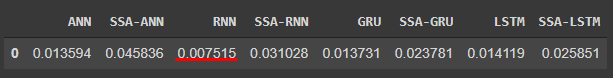

> r = 23 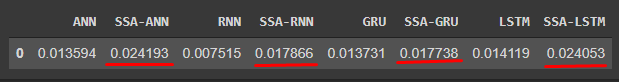

> r = 50 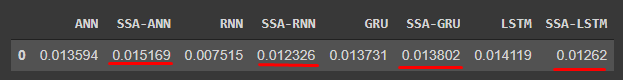

In [ ]:
0.000093161104

9.3161104e-05

## LOD

In [ ]:
ts_LOD = np.array(data.LOD)
TRAIN_SIZE, VAL_SIZE, TEST_SIZE = 500, 109, 108;
seq_len = 12;

assert TRAIN_SIZE + VAL_SIZE + TEST_SIZE == SIZE, "wrong TRAIN and VAL sizes"

ssa_LOD = edict({
    'L' : TRAIN_SIZE//2,
    'ssa_groups' : list(range(1,29)),
    'rssa' : rssa
})

data_LOD = splitData(ts_LOD, seq_len, TRAIN_SIZE, VAL_SIZE, TEST_SIZE, ssa_LOD, val_ssa = True)

100%|██████████| 108/108 [00:24<00:00,  4.46it/s]


### SKORCH

In [ ]:
train_ds = Dataset(data_LOD.train.X, data_LOD.train.y.reshape(-1, 1))

valid_ds = Dataset(data_LOD.val.X, data_LOD.val.y.reshape(-1, 1))
valid_ds_ssa = Dataset(data_LOD.val.X_ssa, data_LOD.val.y.reshape(-1, 1))

### Fully Connected

In [ ]:
fcnet = NeuralNetRegressor(  FCModel
                         , module__inputSize=12
                         , module__hiddenLayer=50
                         , module__outputSize=1
                           
                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience = 50)
                         ]
                         , train_split= predefined_split(valid_ds)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

fcnet_ssa = NeuralNetRegressor(  FCModel
                         , module__inputSize=12
                         , module__hiddenLayer=50
                         , module__outputSize=1       
                        
                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds_ssa)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

In [ ]:
torch.manual_seed(RANDOM_SEED)
fcnet.fit(data_LOD.train.X, data_LOD.train.y.reshape(-1, 1));
fcnet.history[-1]

{'batches': [{'train_batch_size': 488, 'train_loss': 0.03509680926799774},
  {'valid_batch_size': 97, 'valid_loss': 0.046080656349658966}],
 'dur': 0.007677793502807617,
 'epoch': 876,
 'train_batch_count': 1,
 'train_loss': 0.03509680926799774,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.046080656349658966,
 'valid_loss_best': False}

In [ ]:
torch.manual_seed(RANDOM_SEED)
fcnet_ssa.fit(data_LOD.train.X_ssa, data_LOD.train.y.reshape(-1, 1));
fcnet_ssa.history[-1]

{'batches': [{'train_batch_size': 488, 'train_loss': 0.02289324812591076},
  {'valid_batch_size': 97, 'valid_loss': 0.03671436384320259}],
 'dur': 0.008488655090332031,
 'epoch': 600,
 'train_batch_count': 1,
 'train_loss': 0.02289324812591076,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.03671436384320259,
 'valid_loss_best': False}

### RNN

In [ ]:
rnnnet = NeuralNetRegressor(  RNN
                         , module__input_size = 1
                         , module__hidden_size = 12
                         , module__output_size=1
                         #, module__device = device


                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

rnnnet_ssa = NeuralNetRegressor(  RNN
                         , module__input_size = 1
                         , module__hidden_size = 12
                         , module__output_size=1
                         #, module__device = device


                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

In [ ]:
torch.manual_seed(RANDOM_SEED)
rnnnet.fit(data_LOD.train.X, data_LOD.train.y.reshape(-1, 1));
rnnnet.history[-1]

{'batches': [{'train_batch_size': 488, 'train_loss': 0.07333986461162567},
  {'valid_batch_size': 97, 'valid_loss': 0.0842060074210167}],
 'dur': 0.010556936264038086,
 'epoch': 422,
 'train_batch_count': 1,
 'train_loss': 0.07333986461162567,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.0842060074210167,
 'valid_loss_best': False}

In [ ]:
torch.manual_seed(RANDOM_SEED)
rnnnet_ssa.fit(data_LOD.train.X_ssa, data_LOD.train.y.reshape(-1, 1));
rnnnet_ssa.history[-1]

{'batches': [{'train_batch_size': 488, 'train_loss': 0.04024979844689369},
  {'valid_batch_size': 97, 'valid_loss': 0.05528062954545021}],
 'dur': 0.009513616561889648,
 'epoch': 662,
 'train_batch_count': 1,
 'train_loss': 0.04024979844689369,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.05528062954545021,
 'valid_loss_best': False}

### GRU

In [ ]:
grunet = NeuralNetRegressor(  GRU
                         , module__input_size = 1
                         , module__hidden_size = 12
                         , module__output_size=1
                         #, module__device = device


                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

grunet_ssa = NeuralNetRegressor(  GRU
                         , module__input_size = 1
                         , module__hidden_size = 12
                         , module__output_size=1
                         #, module__device = device


                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

In [ ]:
torch.manual_seed(RANDOM_SEED)
grunet.fit(data_LOD.train.X, data_LOD.train.y.reshape(-1, 1));
grunet.history[-1]

{'batches': [{'train_batch_size': 488, 'train_loss': 0.1334223449230194},
  {'valid_batch_size': 97, 'valid_loss': 0.2172834724187851}],
 'dur': 0.009918451309204102,
 'epoch': 395,
 'train_batch_count': 1,
 'train_loss': 0.1334223449230194,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.2172834724187851,
 'valid_loss_best': False}

In [ ]:
torch.manual_seed(RANDOM_SEED)
grunet_ssa.fit(data_LOD.train.X_ssa, data_LOD.train.y.reshape(-1, 1));
grunet_ssa.history[-1]

{'batches': [{'train_batch_size': 488, 'train_loss': 0.12469540536403656},
  {'valid_batch_size': 97, 'valid_loss': 0.20445504784584045}],
 'dur': 0.010083675384521484,
 'epoch': 403,
 'train_batch_count': 1,
 'train_loss': 0.12469540536403656,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.20445504784584045,
 'valid_loss_best': False}

### LSTM

In [ ]:
lstmnet = NeuralNetRegressor(  LSTM
                         , module__input_size = 1
                         , module__hidden_size = 12
                         , module__output_size=1
                         #, module__device = device


                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

lstmnet_ssa = NeuralNetRegressor(  LSTM
                         , module__input_size = 1
                         , module__hidden_size = 12
                         , module__output_size=1
                        # , module__device = device


                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds_ssa)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

In [ ]:
torch.manual_seed(RANDOM_SEED)
lstmnet.fit(data_LOD.train.X, data_LOD.train.y.reshape(-1, 1));
lstmnet.history[-1]

{'batches': [{'train_batch_size': 488, 'train_loss': 0.2475397288799286},
  {'valid_batch_size': 97, 'valid_loss': 0.2366761565208435}],
 'dur': 0.010988473892211914,
 'epoch': 139,
 'train_batch_count': 1,
 'train_loss': 0.2475397288799286,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.2366761565208435,
 'valid_loss_best': False}

In [ ]:
torch.manual_seed(RANDOM_SEED)
lstmnet_ssa.fit(data_LOD.train.X_ssa, data_LOD.train.y.reshape(-1, 1));
lstmnet_ssa.history[-1]

{'batches': [{'train_batch_size': 488, 'train_loss': 0.23478133976459503},
  {'valid_batch_size': 97, 'valid_loss': 0.2300971895456314}],
 'dur': 0.016509532928466797,
 'epoch': 155,
 'train_batch_count': 1,
 'train_loss': 0.23478133976459503,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.2300971895456314,
 'valid_loss_best': False}

### Results

In [ ]:
pc_ann =  getPredCases(fcnet.module_.to('cpu'), data_LOD, tomorrow = True, y_ssa=False, ssa = None)
pc_ssa_ann =  getPredCases(fcnet_ssa.module_.to('cpu'), data_LOD, tomorrow = True, y_ssa=False, ssa = ssa_LOD)
#====================
pc_rnn =  getPredCases(rnnnet.module_.to('cpu'), data_LOD, tomorrow = True, y_ssa=False, ssa = None)
pc_ssa_rnn =  getPredCases(rnnnet_ssa.module_.to('cpu'), data_LOD, tomorrow = True, y_ssa=False, ssa = ssa_LOD)
#====================
pc_gru =  getPredCases(grunet.module_.to('cpu'), data_LOD, tomorrow = True, y_ssa=False, ssa = None)
pc_ssa_gru =  getPredCases(grunet_ssa.module_.to('cpu'), data_LOD, tomorrow = True, y_ssa=False, ssa = ssa_LOD)
#====================
pc_lstm =  getPredCases(lstmnet.module_.to('cpu'), data_LOD, tomorrow = True, y_ssa=False, ssa = None)
pc_ssa_lstm =  getPredCases(lstmnet_ssa.module_.to('cpu'), data_LOD, tomorrow = True, y_ssa=False, ssa = ssa_LOD)

100%|██████████| 108/108 [00:00<00:00, 869.93it/s]


In [ ]:
errs = {'ANN' : getRMSE(ts_LOD[-TEST_SIZE:], pc_ann)
        , 'SSA-ANN' : getRMSE(ts_LOD[-TEST_SIZE:], pc_ssa_ann)
        , 'RNN' : getRMSE(ts_LOD[-TEST_SIZE:], pc_rnn)
        , 'SSA-RNN' : getRMSE(ts_LOD[-TEST_SIZE:], pc_ssa_rnn)
        , 'GRU' : getRMSE(ts_LOD[-TEST_SIZE:], pc_gru)
        , 'SSA-GRU' : getRMSE(ts_LOD[-TEST_SIZE:], pc_ssa_gru)
        , 'LSTM' : getRMSE(ts_LOD[-TEST_SIZE:], pc_lstm)
        , 'SSA-LSTM' : getRMSE(ts_LOD[-TEST_SIZE:], pc_ssa_lstm)
        }
pd.DataFrame().from_dict(errs, orient='index').T

ANN   SSA-ANN       RNN  ...   SSA-GRU      LSTM  SSA-LSTM
0  0.000163  0.000191  0.000209  ...  0.000527  0.000532  0.000516

[1 rows x 8 columns]

In [ ]:
0.000000026569

2.6569e-08

# Double sine wave

## Data 

$ x_i = \sin(2 \pi \frac{i}{T}) + 1.6 \sin(2 \pi \frac{i}{T+2}) + 𝛆_i, \; i = [1, \cdots, 700] $ 

In [ ]:
ts_dsw = ts_y = np.array(pd.read_csv("drive/MyDrive/SSA/model_double_sine_cos_0.3noise.csv", sep = ",")['x'])

SIZE = len(ts_dsw)

TRAIN_SIZE, VAL_SIZE, TEST_SIZE = 500, 100, 100;
seq_len = 12;

assert TRAIN_SIZE + VAL_SIZE + TEST_SIZE == SIZE, "wrong TRAIN and VAL sizes"

ssa_dsw = edict({
    'L' : TRAIN_SIZE//2,
    'ssa_groups' : list(range(1,9)),
    'rssa' : rssa
})

data_dsw = splitData(ts_dsw, seq_len, TRAIN_SIZE, VAL_SIZE, TEST_SIZE, ssa_dsw, val_ssa = True)

100%|██████████| 100/100 [00:18<00:00,  5.38it/s]


In [ ]:
train_ds = Dataset(data_dsw.train.X, data_dsw.train.y.reshape(-1, 1))

valid_ds = Dataset(data_dsw.val.X, data_dsw.val.y.reshape(-1, 1))
valid_ds_ssa = Dataset(data_dsw.val.X_ssa, data_dsw.val.y.reshape(-1, 1))

## Fully Connected

In [ ]:
fcnet = NeuralNetRegressor(  FCModel
                         , module__inputSize=12
                         , module__hiddenLayer=50
                         , module__outputSize=1
                           
                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience = 50)
                         ]
                         , train_split= predefined_split(valid_ds)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

fcnet_ssa = NeuralNetRegressor(  FCModel
                         , module__inputSize=12
                         , module__hiddenLayer=50
                         , module__outputSize=1       
                        
                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds_ssa)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

In [ ]:
torch.manual_seed(RANDOM_SEED)
fcnet.fit(data_dsw.train.X, data_dsw.train.y.reshape(-1, 1));
fcnet.history[-1]

{'batches': [{'train_batch_size': 488, 'train_loss': 0.08622819185256958},
  {'valid_batch_size': 88, 'valid_loss': 0.10993615537881851}],
 'dur': 0.008054018020629883,
 'epoch': 438,
 'train_batch_count': 1,
 'train_loss': 0.08622819185256958,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.10993615537881851,
 'valid_loss_best': False}

In [ ]:
torch.manual_seed(RANDOM_SEED)
fcnet_ssa.fit(data_dsw.train.X_ssa, data_dsw.train.y.reshape(-1, 1));
fcnet_ssa.history[-1]

{'batches': [{'train_batch_size': 488, 'train_loss': 0.05792940780520439},
  {'valid_batch_size': 88, 'valid_loss': 0.09095246344804764}],
 'dur': 0.0072972774505615234,
 'epoch': 767,
 'train_batch_count': 1,
 'train_loss': 0.05792940780520439,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.09095246344804764,
 'valid_loss_best': False}

## RNN

In [ ]:
rnnnet = NeuralNetRegressor(  RNN
                         , module__input_size = 1
                         , module__hidden_size = 12
                         , module__output_size=1
                         #, module__device = device


                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

rnnnet_ssa = NeuralNetRegressor(  RNN
                         , module__input_size = 1
                         , module__hidden_size = 12
                         , module__output_size=1
                         #, module__device = device


                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

In [ ]:
torch.manual_seed(RANDOM_SEED)
rnnnet.fit(data_dsw.train.X, data_dsw.train.y.reshape(-1, 1));
rnnnet.history[-1]

{'batches': [{'train_batch_size': 488, 'train_loss': 0.09252269566059113},
  {'valid_batch_size': 88, 'valid_loss': 0.11174535751342773}],
 'dur': 0.009384870529174805,
 'epoch': 588,
 'train_batch_count': 1,
 'train_loss': 0.09252269566059113,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.11174535751342773,
 'valid_loss_best': False}

In [ ]:
torch.manual_seed(RANDOM_SEED)
rnnnet_ssa.fit(data_dsw.train.X_ssa, data_dsw.train.y.reshape(-1, 1));
rnnnet_ssa.history[-1]

{'batches': [{'train_batch_size': 488, 'train_loss': 0.07348678261041641},
  {'valid_batch_size': 88, 'valid_loss': 0.1396562159061432}],
 'dur': 0.010039567947387695,
 'epoch': 180,
 'train_batch_count': 1,
 'train_loss': 0.07348678261041641,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.1396562159061432,
 'valid_loss_best': False}

## GRU

In [ ]:
grunet = NeuralNetRegressor(  GRU
                         , module__input_size = 1
                         , module__hidden_size = 12
                         , module__output_size=1
                         #, module__device = device


                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

grunet_ssa = NeuralNetRegressor(  GRU
                         , module__input_size = 1
                         , module__hidden_size = 12
                         , module__output_size=1
                         #, module__device = device


                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

In [ ]:
torch.manual_seed(RANDOM_SEED)
grunet.fit(data_dsw.train.X, data_dsw.train.y.reshape(-1, 1));
grunet.history[-1]

{'batches': [{'train_batch_size': 488, 'train_loss': 0.07872223109006882},
  {'valid_batch_size': 88, 'valid_loss': 0.11519406735897064}],
 'dur': 0.00977015495300293,
 'epoch': 1090,
 'train_batch_count': 1,
 'train_loss': 0.07872223109006882,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.11519406735897064,
 'valid_loss_best': False}

In [ ]:
torch.manual_seed(RANDOM_SEED)
grunet_ssa.fit(data_dsw.train.X_ssa, data_dsw.train.y.reshape(-1, 1));
grunet_ssa.history[-1]

{'batches': [{'train_batch_size': 488, 'train_loss': 0.06384292989969254},
  {'valid_batch_size': 88, 'valid_loss': 0.14194415509700775}],
 'dur': 0.010170936584472656,
 'epoch': 665,
 'train_batch_count': 1,
 'train_loss': 0.06384292989969254,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.14194415509700775,
 'valid_loss_best': False}

## LSTM

In [ ]:
lstmnet = NeuralNetRegressor(  LSTM
                         , module__input_size = 1
                         , module__hidden_size = 12
                         , module__output_size=1
                         #, module__device = device


                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

lstmnet_ssa = NeuralNetRegressor(  LSTM
                         , module__input_size = 1
                         , module__hidden_size = 12
                         , module__output_size=1
                        # , module__device = device


                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds_ssa)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

In [ ]:
torch.manual_seed(RANDOM_SEED)
lstmnet.fit(data_dsw.train.X, data_dsw.train.y.reshape(-1, 1));
lstmnet.history[-1]

{'batches': [{'train_batch_size': 488, 'train_loss': 0.07793165743350983},
  {'valid_batch_size': 88, 'valid_loss': 0.11059331893920898}],
 'dur': 0.0192258358001709,
 'epoch': 901,
 'train_batch_count': 1,
 'train_loss': 0.07793165743350983,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.11059331893920898,
 'valid_loss_best': False}

In [ ]:
torch.manual_seed(RANDOM_SEED)
lstmnet_ssa.fit(data_dsw.train.X_ssa, data_dsw.train.y.reshape(-1, 1));
lstmnet_ssa.history[-1]

{'batches': [{'train_batch_size': 488, 'train_loss': 0.05639829486608505},
  {'valid_batch_size': 88, 'valid_loss': 0.10227560251951218}],
 'dur': 0.009755373001098633,
 'epoch': 984,
 'train_batch_count': 1,
 'train_loss': 0.05639829486608505,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.10227560251951218,
 'valid_loss_best': False}

## Results

In [ ]:
pc_ann =  getPredCases(fcnet.module_.to('cpu'), data_dsw, tomorrow = True, y_ssa=False, ssa = None)
pc_ssa_ann =  getPredCases(fcnet_ssa.module_.to('cpu'), data_dsw, tomorrow = True, y_ssa=False, ssa = ssa_dsw)
#====================
pc_rnn =  getPredCases(rnnnet.module_.to('cpu'), data_dsw, tomorrow = True, y_ssa=False, ssa = None)
pc_ssa_rnn =  getPredCases(rnnnet_ssa.module_.to('cpu'), data_dsw, tomorrow = True, y_ssa=False, ssa = ssa_dsw)
#====================
pc_gru =  getPredCases(grunet.module_.to('cpu'), data_dsw, tomorrow = True, y_ssa=False, ssa = None)
pc_ssa_gru =  getPredCases(grunet_ssa.module_.to('cpu'), data_dsw, tomorrow = True, y_ssa=False, ssa = ssa_dsw)
#====================
pc_lstm =  getPredCases(lstmnet.module_.to('cpu'), data_dsw, tomorrow = True, y_ssa=False, ssa = None)
pc_ssa_lstm =  getPredCases(lstmnet_ssa.module_.to('cpu'), data_dsw, tomorrow = True, y_ssa=False, ssa = ssa_dsw)

100%|██████████| 100/100 [00:00<00:00, 707.90it/s]


In [ ]:
errs = {'ANN' : getRMSE(ts_dsw[-TEST_SIZE:], pc_ann)
        , 'SSA-ANN' : getRMSE(ts_dsw[-TEST_SIZE:], pc_ssa_ann)
        , 'RNN' : getRMSE(ts_dsw[-TEST_SIZE:], pc_rnn)
        , 'SSA-RNN' : getRMSE(ts_dsw[-TEST_SIZE:], pc_ssa_rnn)
        , 'GRU' : getRMSE(ts_dsw[-TEST_SIZE:], pc_gru)
        , 'SSA-GRU' : getRMSE(ts_dsw[-TEST_SIZE:], pc_ssa_gru)
        , 'LSTM' : getRMSE(ts_dsw[-TEST_SIZE:], pc_lstm)
        , 'SSA-LSTM' : getRMSE(ts_dsw[-TEST_SIZE:], pc_ssa_lstm)
        }
pd.DataFrame().from_dict(errs, orient='index').T

ANN   SSA-ANN       RNN   SSA-RNN      GRU  SSA-GRU      LSTM  SSA-LSTM
0  1.886303  1.700304  1.921483  2.049044  1.93252  1.83448  1.874059  1.823168

# Гипотезы

TODO:
1. Построить гипотезы и проверить о том что MSE одинаково. (парный критерий)
2. Подбор параметров
3. SSA r = 50

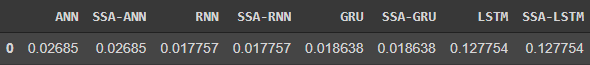

4. RNN & sin & linear & relu

Почему для x и y разные результаты ?

1. Длины окон L и r
2. Перевернуть ряды
3. Убирание тренд (L = 12)
4. Прогноз по точкам: 24, 36, ...

TODO: 

1. Модельный ряд sin T = 12, T = 12.5

# Results

## 1. Длины окон L и r


### X_pole

L = 12, r = 3 

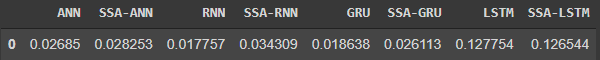

L = 36, r = 5 

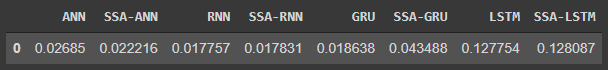

L = 72, r = 5, 22, 28

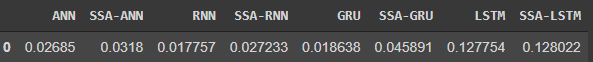

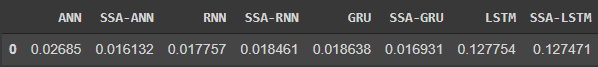

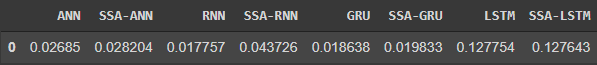

L = 120, r = 10, 26

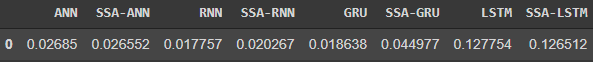

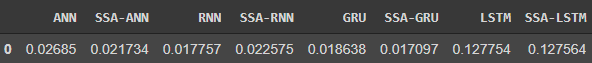

L = 240, r = 21, 27

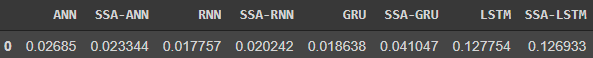

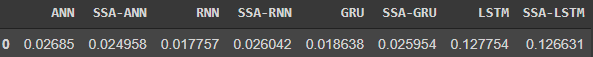


### Y_pole

L = 12, r = 3

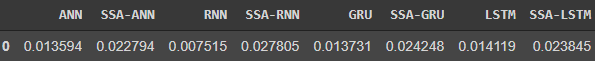

L = 36, r = 7

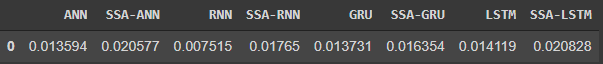

L = 72, r = 10, 17

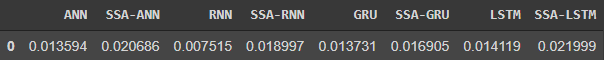

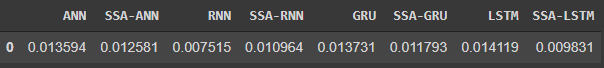


L = 120, r = 29

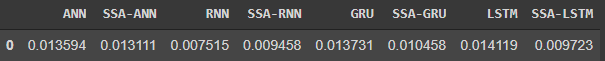


L = 240, r = 18, 33

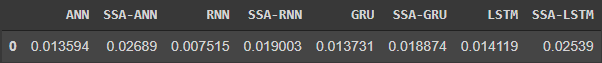

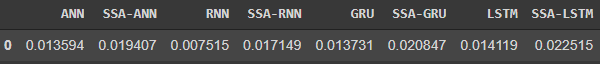

## 2. Перевернутые ряды

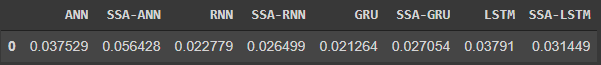

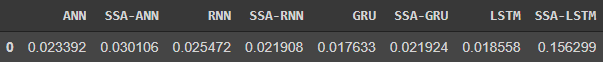

## 3. Без тренда

X_pole:

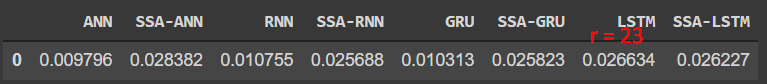

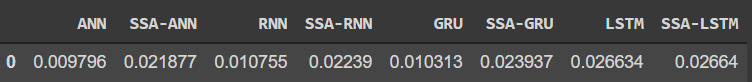

Y_pole:

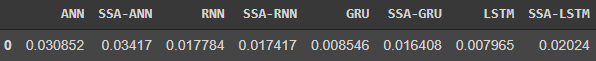

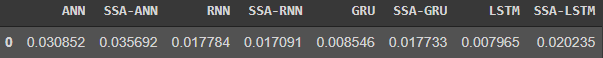